# Pei <i>et al.</i> (2019)
Resolving Fates and Single-Cell Transcriptomes of Hematopoietic Stem Cell Clones by PolyloxExpress Barcoding.


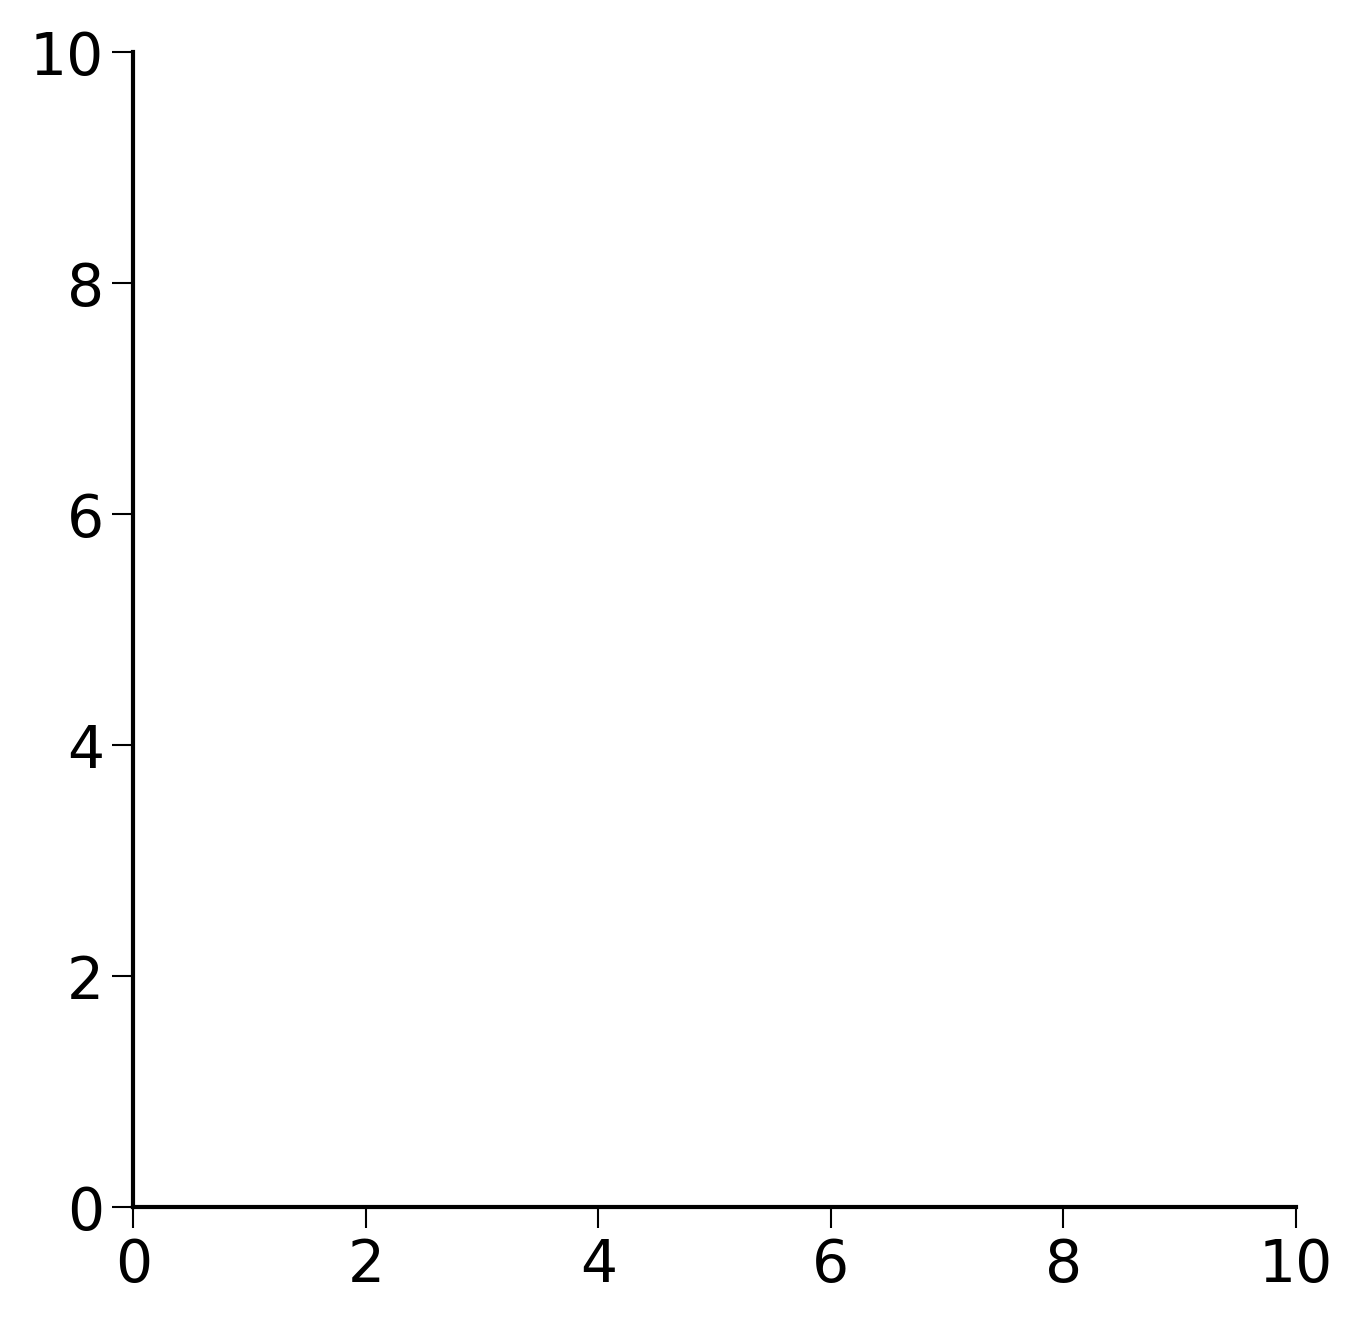

In [8]:
import scanpy as sc
import numpy as np
import operator
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import os
#setPltLinewidth(0)
# os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,6,7"

from torch.nn import DataParallel
import os
import anndata as ad
import cospar as cs
import scanpy as sc
def createFig(figsize=(8, 4)):
    fig,ax=plt.subplots()           
    ax.spines['right'].set_color('none')     
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')     
    #ax.spines['left'].set_color('none')
    for line in ax.yaxis.get_ticklines():
        line.set_markersize(5)
        line.set_color("#585958")
        line.set_markeredgewidth(0.5)
    for line in ax.xaxis.get_ticklines():
        line.set_markersize(5)
        line.set_markeredgewidth(0.5)
        line.set_color("#585958")
    ax.set_xbound(0,10)
    ax.set_ybound(0,10)
    fig.set_size_inches(figsize)
    return fig,ax
def setPltLinewidth(linewidth:float):
    mpl.rcParams['axes.linewidth'] = linewidth
import matplotlib as mpl
fig,ax=createFig()
fig.set_size_inches(5,5)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
setPltLinewidth(1)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1


In [9]:
def ScanpyVolcanoPlot(adata, axis, use_adjusted_p=True, show_label=True, label_fold_change=2, label_log_p=80, add_grid=True, label_size=4, filter_labels=None, kept_labels=None, color1='#F09D30', color2='#3D5FA6', label_excludes=None):
    fig, ax = createFig()
    names = list(map(lambda x: x[axis], adata.uns['rank_genes_groups']['names']))
    log2foldchanges = list(map(lambda x: x[axis], adata.uns['rank_genes_groups']['logfoldchanges']))
    
    if use_adjusted_p:
        log10adjp = -np.log10(list(map(lambda x: x[axis], adata.uns['rank_genes_groups']['pvals_adj'])))
    else:
        log10adjp = -np.log10(list(map(lambda x: x[axis], adata.uns['rank_genes_groups']['pvals'])))
    
    # Filter out excluded genes
    if label_excludes is not None:
        include_indices = [i for i, name in enumerate(names) if name not in label_excludes]
        log2foldchanges = [log2foldchanges[i] for i in include_indices]
        log10adjp = [log10adjp[i] for i in include_indices]
        names = [names[i] for i in include_indices]
    
    ax.scatter(
        x=log2foldchanges,
        y=log10adjp,
        s=12,
        alpha=0.8,
        linewidth=0,
        c=list(map(lambda x: color2 if abs(x[0]) > label_fold_change and x[1] > label_log_p and x[0] < 0
                   else color1 if abs(x[0]) > label_fold_change and x[1] > label_log_p and x[0] > 0
                   else 'gray', zip(log2foldchanges, log10adjp)))
    )
    
    if add_grid:
        ax.axvline(-label_fold_change, color ="black", alpha = 0.8, lw = 0.8, ls='--')
        ax.axvline(label_fold_change, color ="black", alpha = 0.8, lw = 0.8, ls='--')
        ax.axhline(label_log_p, color ="black", alpha = 0.8, lw = 0.8, ls='--')
        ax.grid(alpha=0.4)
    if show_label:
        indices = list(map(lambda x: abs(x[0]) > label_fold_change and x[1] > label_log_p, zip(log2foldchanges, log10adjp)))
        for i, j, s in zip(np.array(log2foldchanges)[indices], np.array(log10adjp)[indices], np.array(names)[indices]):
            if label_excludes is not None and s in label_excludes:
                continue
            if filter_labels is not None and s in filter_labels:
                continue
            if kept_labels is not None and s not in kept_labels:
                continue
            ax.text(i, j, s=s, size=label_size)
    
    return fig, ax

In [10]:
adata=cs.hf.read("/home/zhengtuo/songtao/1523_filter_pei.h5ad")
#adata.obs['index']=range(adata.shape[0])
#adata2=cs.hf.read("./pei8.28.h5ad")

adata2=cs.hf.read("/home/zhengtuo/songtao/pei9.15.h5ad")
adata2

AnnData object with n_obs × n_vars = 1366 × 1427
    obs: 'sample_name', 'CI', 'max.barcode', 'type', 'leiden', 'cell_type', 'batch_name', 'fate_bias', 'HSC_preference', 'index', 'prob', 'fate_pred'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'HSC_preference_colors', 'batch_name_colors', 'cell_type_colors', 'fate_bias_colors', 'fate_pred_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'sample_name_colors', 'umap'
    obsm: 'X_emb', 'X_emb_old', 'X_pca', 'X_scanorama', 'X_umap', 'geneEnc', 'genemap'
    obsp: 'connectivities', 'distances'

In [11]:
pei_all = cs.hf.read("/home/zhengtuo/songtao/GSE144273_merged_normalized.h5ad")
adata2.raw = pei_all[adata2.obs.index,adata2.var.index]

In [12]:
adata2.obs['HSC_preference'].value_counts()

ME    267
Ly    210
Name: HSC_preference, dtype: int64

In [13]:
from math import sqrt

import torch
import torch.nn as nn
num_relations=3
len_geneExp=1427
len_embedding=256
learning_rate=0.0001
num_epoch=10
batchsize=512
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.LeakyReLU(inplace=False),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        #print('channel:',c)
        #print('size:',x.shape)
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        #print('y_size:',y.shape)
        return x * y.expand_as(x)
class MutiheadAttention(nn.Module):
    def __init__(self, input_dim, dim_k, dim_v,num_heads):
        super(MutiheadAttention, self).__init__()
        self.dim_q = dim_k 
        self.dim_k = dim_k
        self.dim_v = dim_v
        self.num_units=dim_k
        self.num_heads=num_heads
        self.linear_q = nn.Linear(input_dim, dim_k, bias=False)
        self.linear_k = nn.Linear(input_dim, dim_k, bias=False)
        self.linear_v = nn.Linear(input_dim, dim_v, bias=False)
        self._norm_fact = 1 / sqrt(dim_k)

    def forward(self, x):
        # x: batch_size, seq_len, input_dim
        q = self.linear_q(x)  # batch_size, seq_len, dim_k
        k = self.linear_k(x)  # batch_size, seq_len, dim_k
        v = self.linear_v(x)  # batch_size, seq_len, dim_v
        split_size = self.num_units // self.num_heads
        q = torch.stack(torch.split(q, split_size, dim=2), dim=0)  # [h, N, T_q, num_units/h]
        k = torch.stack(torch.split(k, split_size, dim=2), dim=0)  # [h, N, T_k, num_units/h]
        v = torch.stack(torch.split(v, split_size, dim=2), dim=0)  # [h, N, T_k, num_units/h]

        scores = torch.matmul(q, k.transpose(2, 3))
        scores = scores / (self.dim_k ** 0.5)
        
        scores = F.softmax(scores, dim=3)
        ## out = score * V
        out = torch.matmul(scores, v)  # [h, N, T_q, num_units/h]
        out = torch.cat(torch.split(out, 1, dim=0), dim=3).squeeze(0) 

        return out

class ResidualBlock(torch.nn.Module):
    def __init__(self,channels):
        super(ResidualBlock,self).__init__()
        self.channels = channels
        
        self.conv1 = nn.Conv1d(channels,channels,kernel_size=3,padding=1)
        self.conv2 = nn.Conv1d(channels,channels,kernel_size=3,padding=1)
        self.se=SELayer(channels,16)
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        y=self.se(y)
        return F.relu(x+y)

class CNN(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.att=MutiheadAttention(len_embedding*2,512,512,64)
        self.layernorm=nn.LayerNorm(512)
        self.conv1 = nn.Conv1d(1, 32, 4) 
        self.relu1=nn.LeakyReLU(0.2, inplace=True)
        self.rblock1 = ResidualBlock(32)
        self.conv2 = nn.Conv1d(32,64, 4)  
        self.batchn1=nn.BatchNorm1d(64)
        self.relu2= nn.LeakyReLU(0.2, inplace=True)
        self.rblock2 = ResidualBlock(64)
        self.conv3=nn.Conv1d(64,128,4)
        self.batchn2=nn.BatchNorm1d(128)
        self.relu3= nn.LeakyReLU(0.2, inplace=True)
        self.rblock3 = ResidualBlock(128)
        self.conv4=nn.Conv1d(128,256,4)
        self.batchn3=nn.BatchNorm1d(256)
        self.relu4= nn.LeakyReLU(0.2, inplace=True)
        self.rblock4 = ResidualBlock(256)
        self.dropout=nn.Dropout()
        self.fc1 = nn.Linear(7424, num_relations)
        
    def forward(self, x):
        x=self.att(x)+x
        x=self.layernorm(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock1(x)
        x = self.conv2(x)
        x=self.batchn1(x)
        x=self.relu2(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock2(x)
        
        x = self.conv3(x)
        x=self.batchn2(x)
        x=self.relu3(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock3(x)
        
        x = self.conv4(x)
        x=self.batchn3(x)
        x=self.relu4(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock4(x)
        x = x.view(x.size()[0], -1)
        x=self.dropout(x)
        x=self.fc1(x)
        return x
geneEnc=nn.Sequential(
    nn.Dropout(),
    nn.Linear(len_geneExp, 100),
    nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
     nn.Linear(100, 100),
            nn.ReLU(),
    nn.Linear(100, 100),
            nn.ReLU(),
    nn.Linear(100, len_embedding),
)
geneDec = nn.Sequential(
    nn.Linear(len_embedding, len_geneExp),

)
genemap = nn.Sequential(
    #nn.Dropout(),
     nn.Linear(len_embedding, 100),
     nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
   nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
   nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, len_embedding),

)



model=CNN()
device = torch.device("cuda:7")
device2 = torch.device("cuda:7")
path='/home/zhengtuo/songtao/pei9.14.pth'
pretrained_weights = torch.load(path)
model.load_state_dict(pretrained_weights['model'])
geneEnc.load_state_dict(pretrained_weights['geneEnc'])
genemap.load_state_dict(pretrained_weights['genemap'])
geneDec.load_state_dict(pretrained_weights['geneDec'])

model.to(device2)
geneEnc.to(device2)
geneDec.to(device2)
genemap.to(device2)


genemap.eval()
model.eval()
geneEnc.eval()
geneDec.eval()


Sequential(
  (0): Linear(in_features=256, out_features=1427, bias=True)
)

In [649]:

Embeddings_path = '/home/zhengtuo/songtao/dynamic2.txt.npz' # txt dir to save cell embeddings
from tqdm import trange
geneEnc.to(device2)
all_embeddings = []
with torch.no_grad():
    for i in trange(adata2.shape[0]):
        x = 1*adata2.X[i].toarray()
        geneExp = torch.tensor(x).to(device2)
        geneExp=torch.reshape(geneExp,(1,1427))
        geneExp = geneExp.to(torch.float32)
        geneEmbedding = geneEnc(geneExp)
        geneEmbedding = geneEmbedding.cpu().detach().numpy() # or any other data type
        all_embeddings.append(geneEmbedding)
    np.savez(Embeddings_path,all_embeddings)

mapembedding = []
with torch.no_grad():
    for i in trange(adata2.shape[0]):
        x = 1*adata2.X[i].toarray()
        geneExp = torch.tensor(x).to(device2)
        geneExp = geneExp.to(torch.float32)
        geneEmbedding = geneEnc(geneExp)
        geneEmbedding=genemap(geneEmbedding)
        geneEmbedding = geneEmbedding.cpu().detach().numpy() # or any other data type
        mapembedding.append(geneEmbedding)

        
    

100%|█████████████████████████████████████| 1366/1366 [00:01<00:00, 1173.55it/s]


In [391]:
# n= np.load( '/home/zhengtuo/songtao/dynamic2.txt.npz')
# n=torch.tensor(n['arr_0'])
# n=torch.reshape(n,(1366,256))
# adata2.obsm["X_pca"] = n
# cs.pp.get_X_emb(adata2, n_neighbors=20, umap_min_dist=2)
# # cs.pl.embedding(adata2, color="deep")
# sc.pl.umap(adata2, color="HSC_preference", s=50)


In [392]:
# sc.pl.umap(adata2, color="cell_type", s=50)n= np.load( '/home/zhengtuo/songtao/dynamic2.txt.npz')
# n=torch.tensor(n['arr_0'])
# n=torch.reshape(n,(1366,256))
# adata2.obsm["X_pca"] = n
# cs.pp.get_X_emb(adata2, n_neighbors=20, umap_min_dist=2)
# # cs.pl.embedding(adata2, color="deep")
# sc.pl.umap(adata2, color="HSC_preference", s=50)



/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


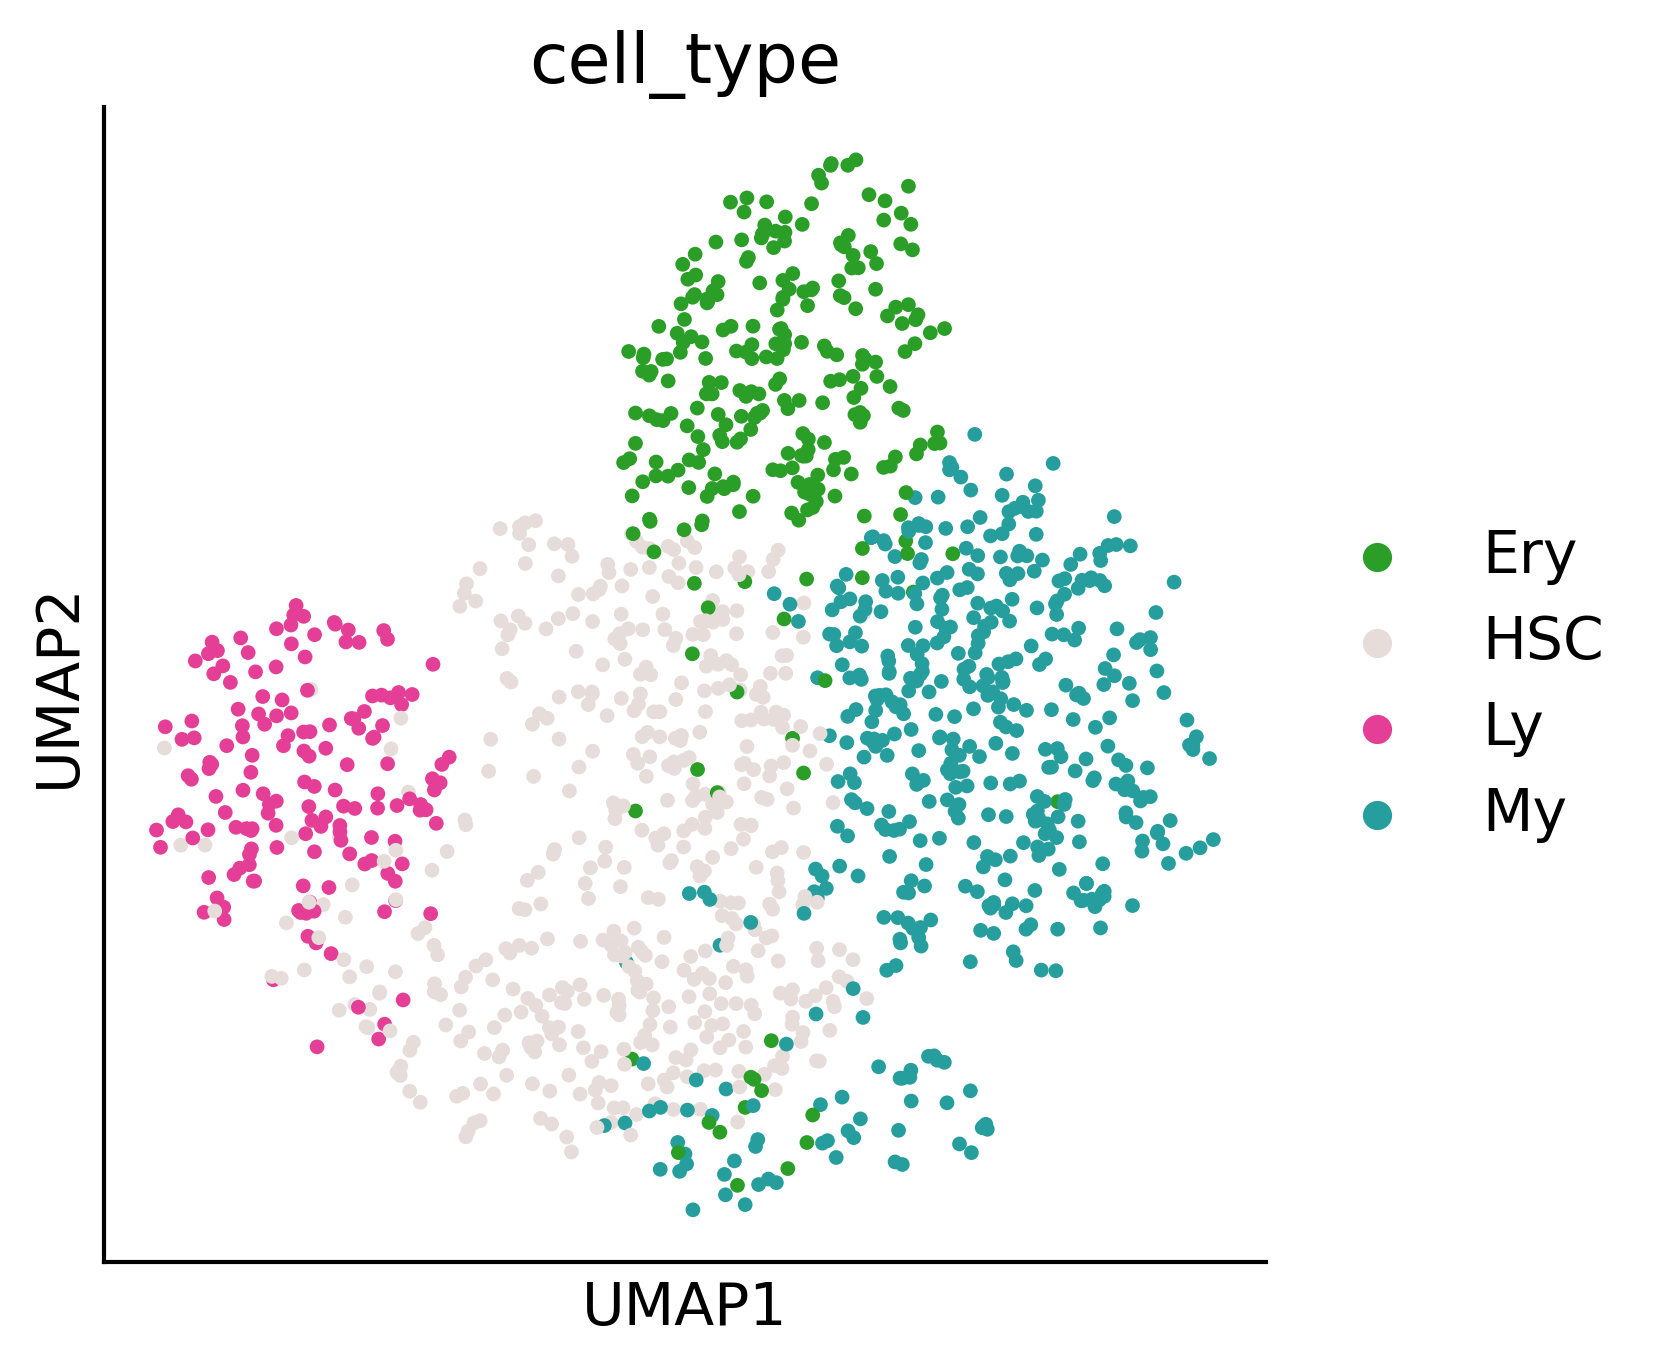

In [650]:
fig,ax=createFig((5,5))
sc.pl.umap(adata2, color='cell_type', palette={
 'Ery': '#2A9E27',
 'Lymphoid': '#E43E96',
 'Mast': '#B5BD61',
 'My': '#279E9E',
 'Mo': '#50C3C6',
 'Neu': '#FAA339',
 'ME': '#279E8F',
 'Ly': '#E43E96',
 'HSC': '#E6DCD9'
}, ax=ax, s=50)
ax.figure.savefig('/home/zhengtuo/songtao/DestinyNet/pei_figure/pei_fate_clustering.pdf', bbox_inches='tight')  


/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


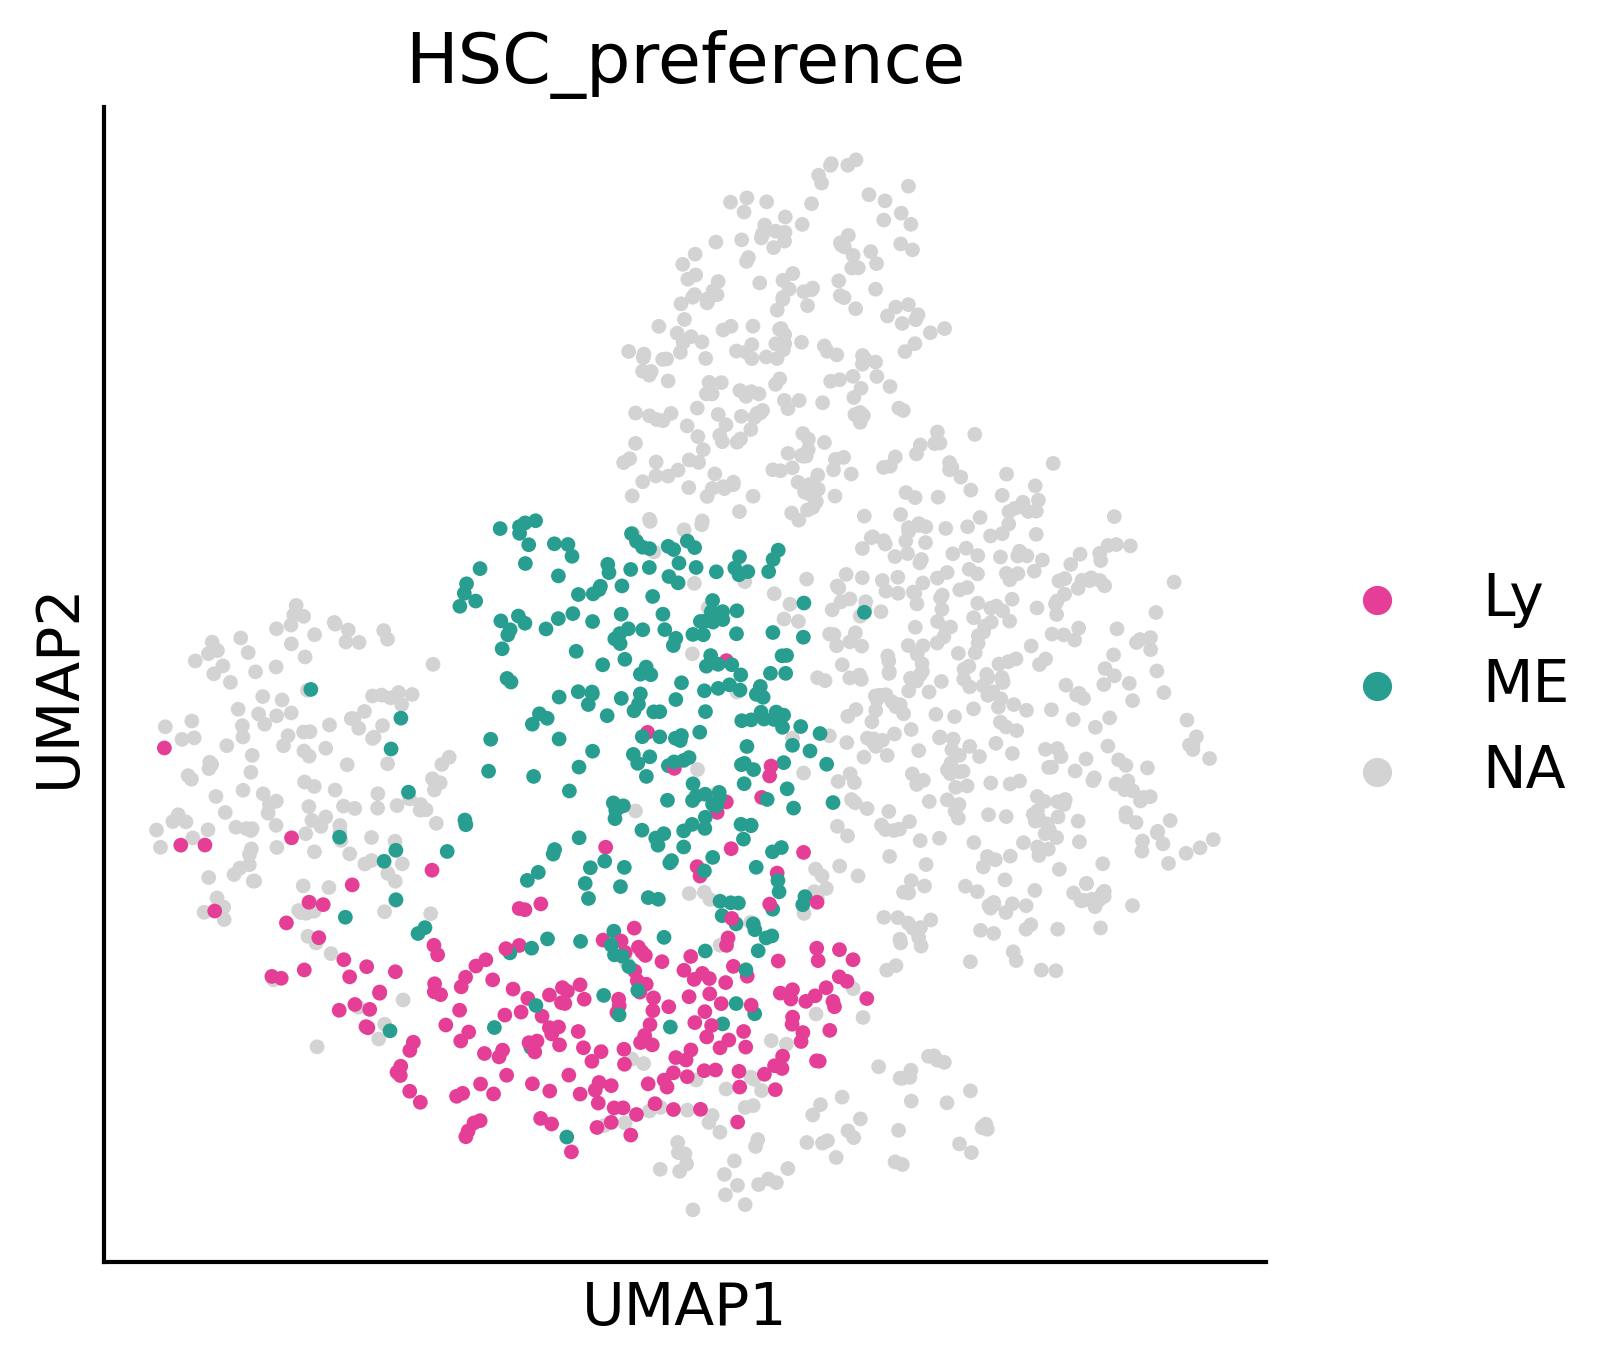

In [653]:
fig,ax=createFig((5,5))
sc.pl.umap(adata2, color='HSC_preference', palette={
 'Ery': '#2A9E27',
 'Lymphoid': '#E43E96',
 'Mast': '#B5BD61',
 'My': '#279E9E',
 'Mo': '#50C3C6',
 'Neu': '#FAA339',
 'ME': '#279E8F',
 'Ly': '#E43E96',
 'HSC': '#E6DCD9'
}, ax=ax, s=50)
ax.figure.savefig('/home/zhengtuo/songtao/DestinyNet/pei_figure/pei_GT(0.30).pdf', bbox_inches='tight') 


In [5]:
import sklearn
sklearn.metrics.silhouette_score(
    adata2[adata2.obs['HSC_preference'].isin(['Ly','ME'])].obsm["X_umap"],
    adata2[adata2.obs['HSC_preference'].isin(['Ly','ME'])].obs['HSC_preference']
)

0.30329853

In [654]:
def compute_velocity_on_grid(
    X_emb,
    M_emb,
    density=None,
    smooth=None,
    n_neighbors=None,
    min_mass=None,
    autoscale=True,
    adjust_for_stream=False,
    cutoff_perc=None,
):
    # remove invalid cells
    idx_valid = np.isfinite(X_emb.sum(1) + M_emb.sum(1))
    X_emb = X_emb[idx_valid]
    M_emb = M_emb[idx_valid]

    # prepare grid
    n_obs, n_dim = X_emb.shape
    density = 0.5 if density is None else density
    smooth = 0.5 if smooth is None else smooth

    grs = []
    for dim_i in range(n_dim):
        m, M = np.min(X_emb[:, dim_i]), np.max(X_emb[:, dim_i])
        m = m - 0.01 * np.abs(M - m)
        M = M + 0.01 * np.abs(M - m)
        gr = np.linspace(m, M, int(50 * density))
        grs.append(gr)

    meshes_tuple = np.meshgrid(*grs)
    X_grid = np.vstack([i.flat for i in meshes_tuple]).T

    # estimate grid velocities
    if n_neighbors is None:
        n_neighbors = int(n_obs / 50)
    nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
    nn.fit(X_emb)
    dists, neighs = nn.kneighbors(X_grid)

    scale = np.mean([(g[1] - g[0]) for g in grs]) * smooth
    weight = normal.pdf(x=dists, scale=scale)
    p_mass = weight.sum(1)

    V_grid = (M_emb[neighs] * weight[:, :, None]).sum(1)
    V_grid /= np.maximum(1, p_mass)[:, None]
    if min_mass is None:
        min_mass = 1

    if adjust_for_stream:
        X_grid = np.stack([np.unique(X_grid[:, 0]), np.unique(X_grid[:, 1])])
        ns = int(np.sqrt(len(V_grid[:, 0])))
        V_grid = V_grid.T.reshape(2, ns, ns)

        mass = np.sqrt((V_grid ** 2).sum(0))
        min_mass = 10 ** (min_mass - 6)  # default min_mass = 1e-5
        min_mass = np.clip(min_mass, None, np.max(mass) * 0.9)
        cutoff = mass.reshape(V_grid[0].shape) < min_mass

        if cutoff_perc is None:
            cutoff_perc = 5
        length = np.sum(np.mean(np.abs(M_emb[neighs]), axis=1), axis=1).T
        length = length.reshape(ns, ns)
        cutoff |= length < np.percentile(length, cutoff_perc)

        V_grid[0][cutoff] = np.nan
    else:
        min_mass *= np.percentile(p_mass, 99) / 100
        X_grid, V_grid = X_grid[p_mass > min_mass], V_grid[p_mass > min_mass]

        if autoscale:
            V_grid /= 3 * quiver_autoscale(X_grid, V_grid)

    return X_grid, V_grid

def quiver_autoscale(X_emb, V_emb):
    import matplotlib.pyplot as pl

    scale_factor = np.abs(X_emb).max()  # just so that it handles very large values
    fig, ax = pl.subplots()
    Q = ax.quiver(
        X_emb[:, 0] / scale_factor,
        X_emb[:, 1] / scale_factor,
        V_emb[:, 0],
        V_emb[:, 1],
        angles="xy",
        scale_units="xy",
        scale=None,
    )
    Q._init()
    fig.clf()
    pl.close(fig)
    return Q.scale / scale_factor


In [655]:
adata2.obsm['X_pca']=adata2.obsm['X_pca'].cpu().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

100%|██████████████████████████████████████| 1366/1366 [00:01<00:00, 801.56it/s]


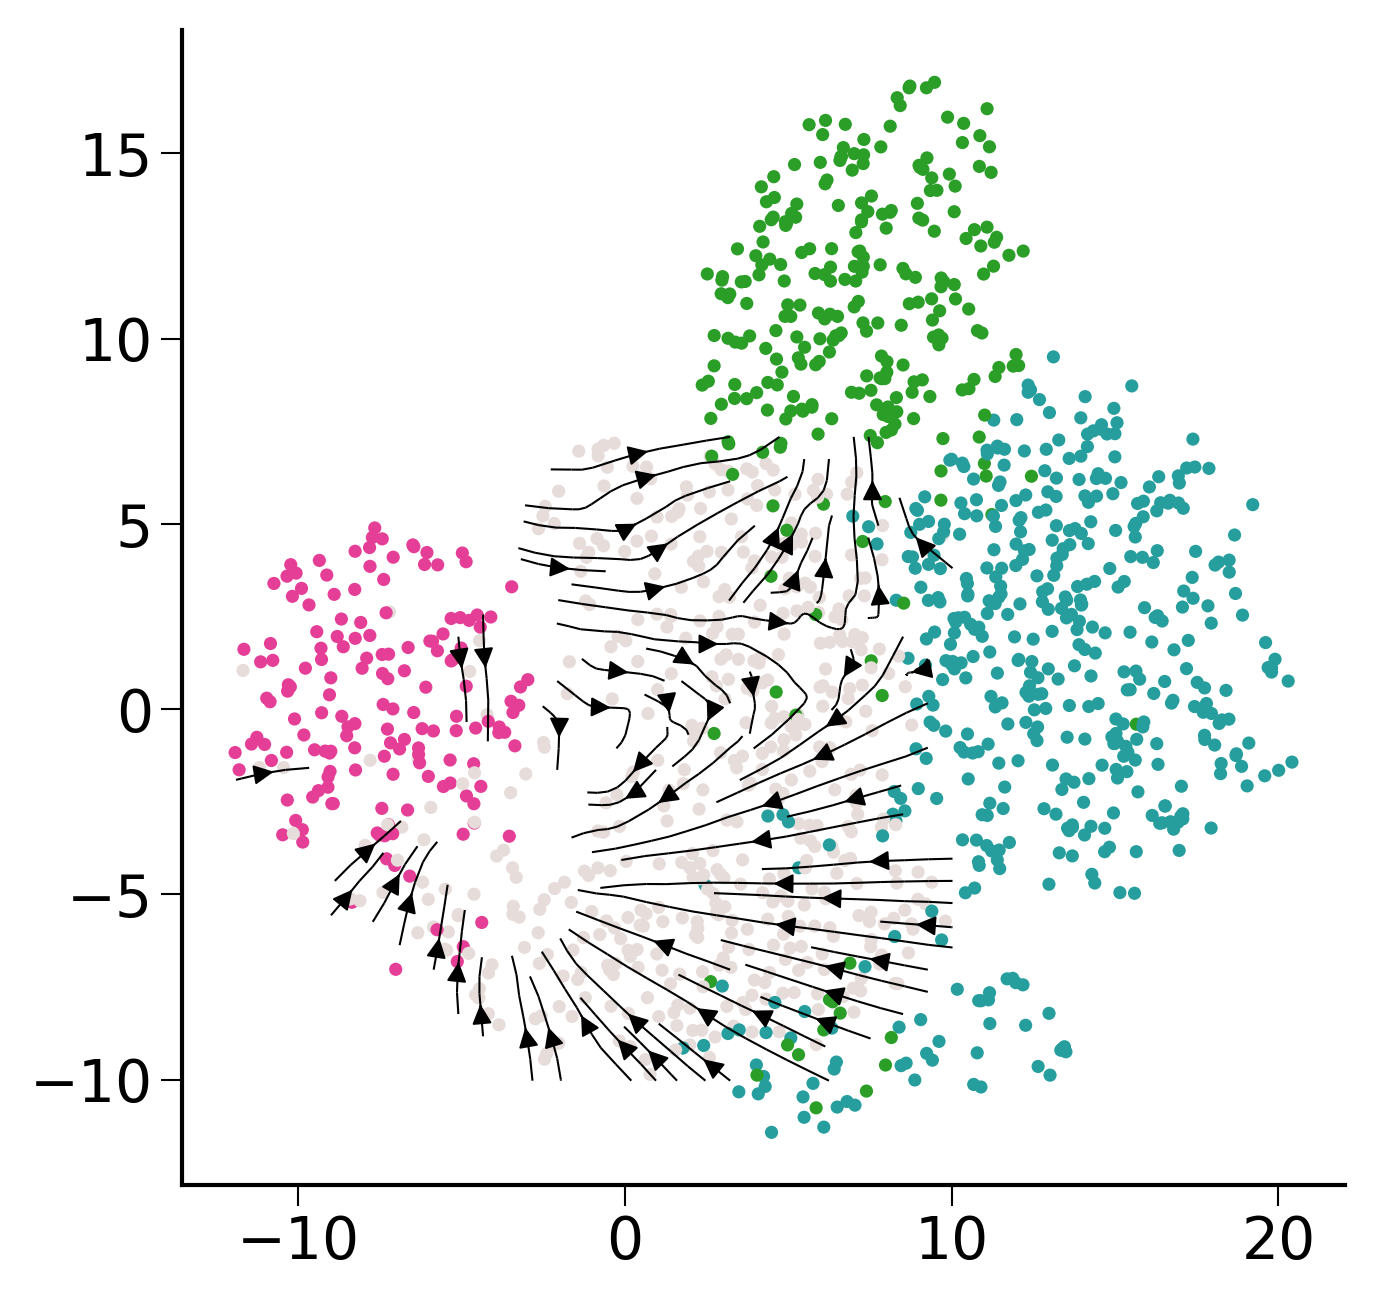

In [656]:
pei_adata=adata2
def compute_velocity_on_grid(
    X_emb,
    M_emb,
    density=None,
    smooth=None,
    n_neighbors=None,
    min_mass=None,
    autoscale=True,
    adjust_for_stream=False,
    cutoff_perc=None,
):
    # remove invalid cells
    idx_valid = np.isfinite(X_emb.sum(1) + M_emb.sum(1))
    X_emb = X_emb[idx_valid]
    M_emb = M_emb[idx_valid]

    # prepare grid
    n_obs, n_dim = X_emb.shape
    density = 0.5 if density is None else density
    smooth = 0.5 if smooth is None else smooth

    grs = []
    for dim_i in range(n_dim):
        m, M = np.min(X_emb[:, dim_i]), np.max(X_emb[:, dim_i])
        m = m - 0.01 * np.abs(M - m)
        M = M + 0.01 * np.abs(M - m)
        gr = np.linspace(m, M, int(50 * density))
        grs.append(gr)

    meshes_tuple = np.meshgrid(*grs)
    X_grid = np.vstack([i.flat for i in meshes_tuple]).T

    # estimate grid velocities
    if n_neighbors is None:
        n_neighbors = int(n_obs / 50)
    nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
    nn.fit(X_emb)
    dists, neighs = nn.kneighbors(X_grid)

    scale = np.mean([(g[1] - g[0]) for g in grs]) * smooth
    weight = normal.pdf(x=dists, scale=scale)
    p_mass = weight.sum(1)

    V_grid = (M_emb[neighs] * weight[:, :, None]).sum(1)
    V_grid /= np.maximum(1, p_mass)[:, None]
    if min_mass is None:
        min_mass = 1

    if adjust_for_stream:
        X_grid = np.stack([np.unique(X_grid[:, 0]), np.unique(X_grid[:, 1])])
        ns = int(np.sqrt(len(V_grid[:, 0])))
        V_grid = V_grid.T.reshape(2, ns, ns)

        mass = np.sqrt((V_grid ** 2).sum(0))
        min_mass = 10 ** (min_mass - 6)  # default min_mass = 1e-5
        min_mass = np.clip(min_mass, None, np.max(mass) * 0.9)
        cutoff = mass.reshape(V_grid[0].shape) < min_mass

        if cutoff_perc is None:
            cutoff_perc = 5
        length = np.sum(np.mean(np.abs(M_emb[neighs]), axis=1), axis=1).T
        length = length.reshape(ns, ns)
        cutoff |= length < np.percentile(length, cutoff_perc)

        V_grid[0][cutoff] = np.nan
    else:
        min_mass *= np.percentile(p_mass, 99) / 100
        X_grid, V_grid = X_grid[p_mass > min_mass], V_grid[p_mass > min_mass]

        if autoscale:
            V_grid /= 3 * quiver_autoscale(X_grid, V_grid)

    return X_grid, V_grid

def quiver_autoscale(X_emb, V_emb):
    import matplotlib.pyplot as pl

    scale_factor = np.abs(X_emb).max()  # just so that it handles very large values
    fig, ax = pl.subplots()
    Q = ax.quiver(
        X_emb[:, 0] / scale_factor,
        X_emb[:, 1] / scale_factor,
        V_emb[:, 0],
        V_emb[:, 1],
        angles="xy",
        scale_units="xy",
        scale=None,
    )
    Q._init()
    fig.clf()
    pl.close(fig)
    return Q.scale / scale_factor
import numpy as np
from scipy.stats import norm as normal
from sklearn.neighbors import NearestNeighbors
import tqdm
sc.pp.neighbors(pei_adata)

X = pei_adata.obsm['geneEnc'][:,0,:]
M = pei_adata.obsm['genemap'][:,0,:]
N = pei_adata.obsp['connectivities']
E = pei_adata.obsm["X_umap"]
norm = lambda x: (x-min(x))/(max(x)-min(x))
nn = NearestNeighbors(n_neighbors=20)
nn.fit(X)
dE = []


for i in tqdm.trange(N.shape[0]):
    D,I = nn.kneighbors( np.array([M[i]]) )
    dE.append( (E[I][0] - E[i]).mean(0))

dE = np.vstack(dE)
E = E[pei_adata.obs['cell_type'] == 'HSC']
dE = dE[pei_adata.obs['cell_type'] == 'HSC']

gE, gdE = compute_velocity_on_grid(E,dE,density=2, adjust_for_stream=True,smooth=True)

fig,ax=createFig(figsize=(5, 5))
fig.set_size_inches(5,5)
palette = sc.pl._tools.scatterplots._get_palette(pei_adata, 'cell_type')
ax.scatter(pei_adata.obsm["X_umap"][:,0],pei_adata.obsm["X_umap"][:,1],s=10, linewidths=0,c=list(map(lambda x: palette[x], pei_adata.obs['cell_type'])))
stream_kwargs = {
        "linewidth": 0.5,
        "density": 1,
        "zorder": 3,
        "color": "black",
        "arrowsize":  1,
    
        "arrowstyle": "-|>",
        "maxlength":  10,
        "integration_direction":  "both",
}

ax.streamplot(gE[0],gE[1],gdE[0],gdE[1],**stream_kwargs)
#plt.savefig("/home/zhengtuo/songtao/DestinyNet/pei_figure/flow.pdf")

In [657]:
indices = (np.array(pei_adata.obs['cell_type'] == 'HSC'))
sc.tl.leiden(pei_adata, resolution=0.3)
pei_adata.obs['fate_pred'].cat.add_categories(['-'], inplace=True)

pei_adata.obs['fate_pred'] = pei_adata.obs['fate_pred'].fillna('-')


/tmp/ipykernel_111981/2731666883.py:4: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  pei_adata.obs['fate_pred'].cat.add_categories(['-'], inplace=True)


/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


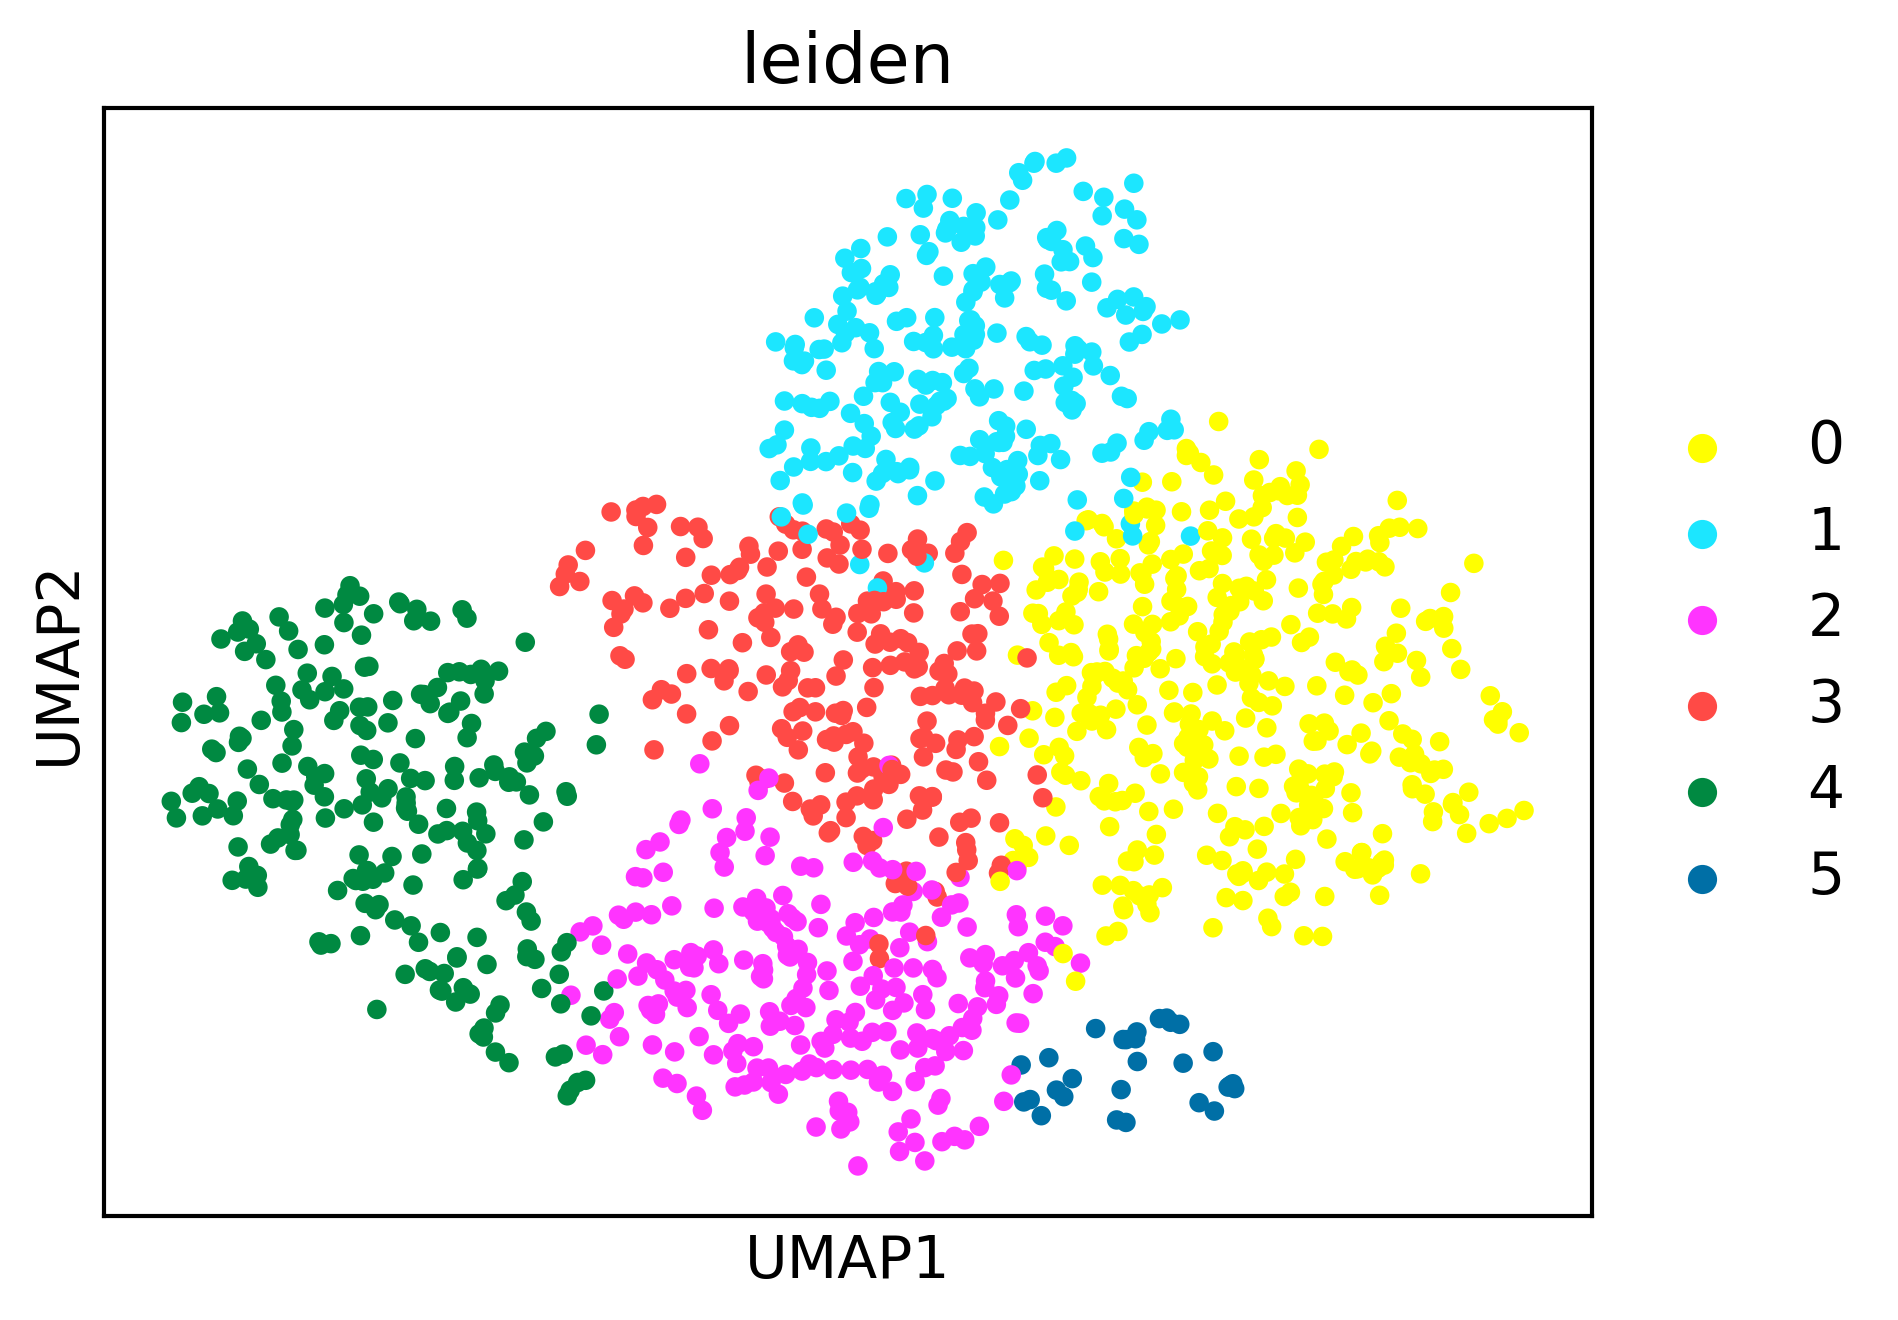

In [658]:
sc.pl.umap(pei_adata,color='leiden')


In [185]:
pei_adata.obs['leiden'][5]

'5'

<Axes: >

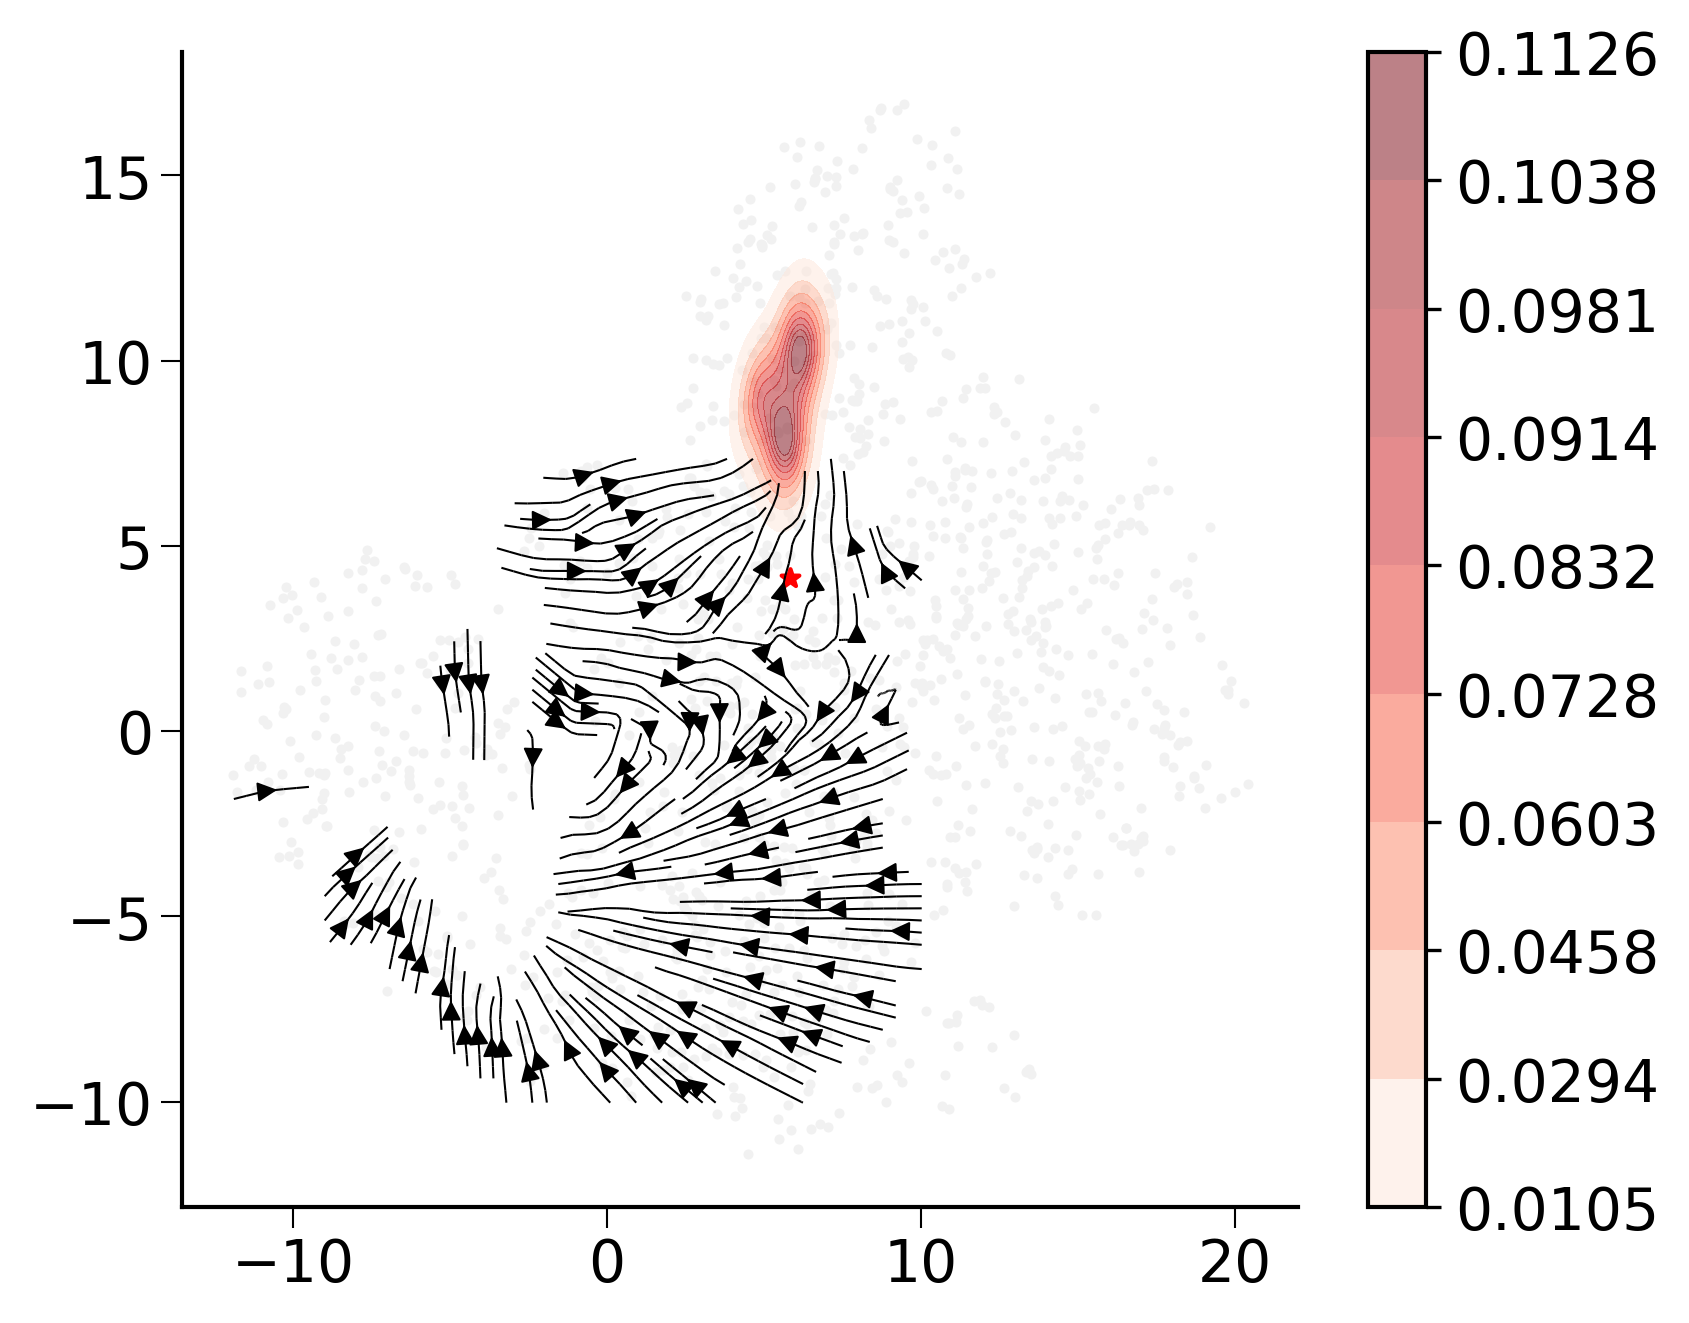

In [672]:
import seaborn as sns

xkey = 'geneEnc'
mkey = 'genemap'
X = pei_adata.obsm['geneEnc'][:,0,:]
M = pei_adata.obsm['genemap'][:,0,:]
N = pei_adata.obsp['connectivities']
E = pei_adata.obsm["X_umap"]



# gE, gdE = biddy_adata.uns['gE'], biddy_adata.uns['gdE']
# gE, gdE = compute_velocity_on_grid(E,dE,density=2, adjust_for_stream=True,smooth=True)
fig,ax=createFig()
fig.set_size_inches(6, 5)
palette={
 'Ery': '#2A9E27',
 'Lymphoid': '#E43E96',
 'Mast': '#B5BD61',
 'My': '#279E9E',
 'Mo': '#50C3C6',
 'Neu': '#FAA339',
 'ME': '#279E8F',
 'Ly': '#E43E96',
 'HSC': '#E6DCD9',
    '-':'#E6DCD9'
}
ax.scatter(E[:,0],E[:,1],s=1, linewidths=0,c=list(map(lambda x: palette[x], pei_adata.obs['fate_pred'])))
# ax.scatter(E[:,0],E[:,1],s=1, linewidths=0,c=list(map(lambda x: sc.pl._tools.scatterplots._get_palette(biddy_adata, 'leiden')[x], biddy_adata.obs['leiden'])))
tmp = pei_adata.obs

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
# sc.pl.umap(weinreb_adata, ax=ax, color='Gata2')

i=np.random.choice(list(map(lambda z: z[0], 
                            filter(lambda x: x[1] == '3', 
                                   enumerate(pei_adata.obs['leiden'])))), 1)
i
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X)
D,I = nn.kneighbors(M[i])
e = E[I][0]


E = pei_adata.obsm["X_umap"]

ax.scatter(
    pei_adata.obsm["X_umap"][:,0],
    pei_adata.obsm["X_umap"][:,1],
    color='#F1F1F1',
    s=2
)

stream_kwargs = {
        "linewidth": 0.5,
        "density": 1.8,
        "zorder": 3,
        "color": "black",
        "arrowsize":  1,
        "arrowstyle": "-|>",
        "maxlength":  10,
        "integration_direction":  "both",
}
ax.streamplot(gE[0],gE[1],gdE[0],gdE[1],**stream_kwargs)

ax.scatter(E[i,0],E[i,1],color='red',s=20,marker='*')
# sns.kdeplot(e[:,0],e[:,1],ax=ax, fill=True, alpha=0.5, cmap='Reds',cbar=True)

sns.kdeplot(x=e[:,0], y=e[:,1], ax=ax, fill=True, alpha=0.5, cmap='Reds', cbar=True)


In [673]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('/home/zhengtuo/songtao/DestinyNet/pei_figure/fateflow_hotpot4.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')

/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


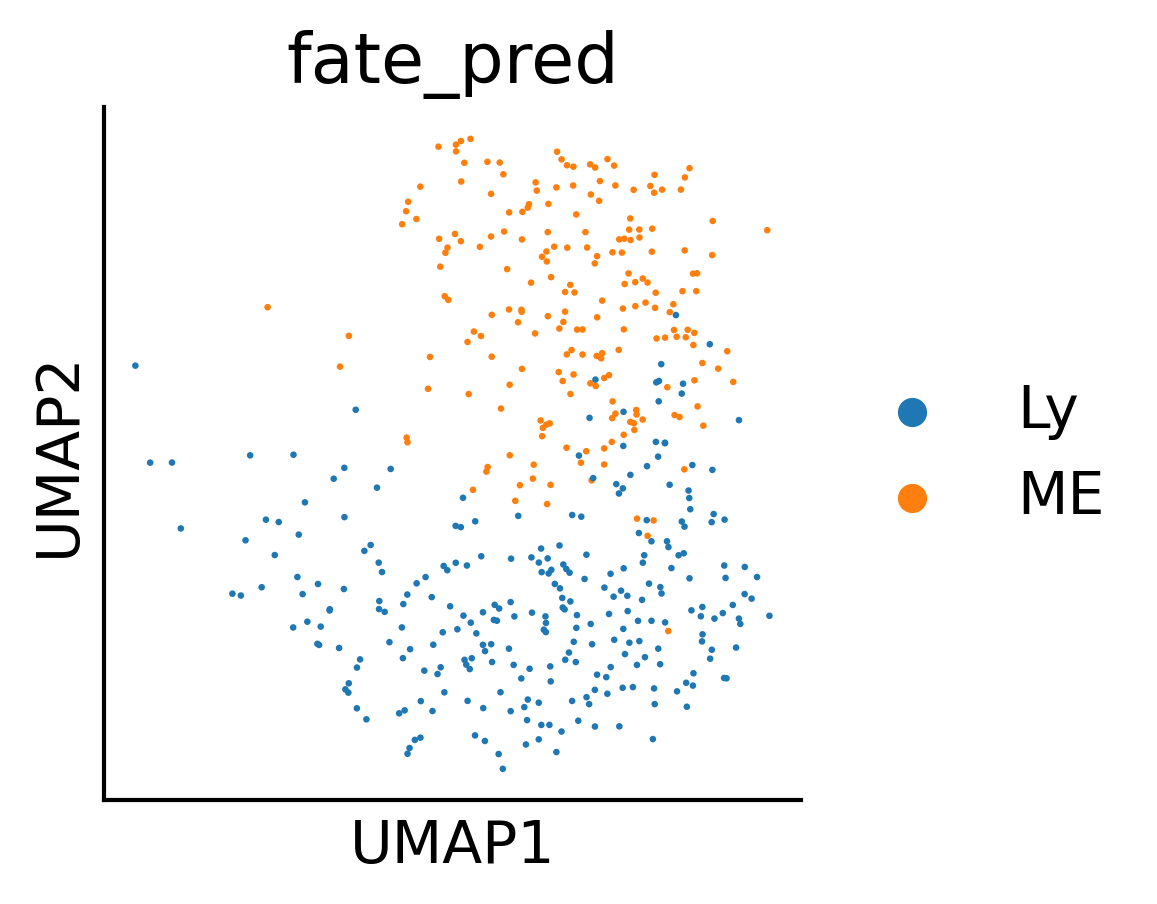

/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


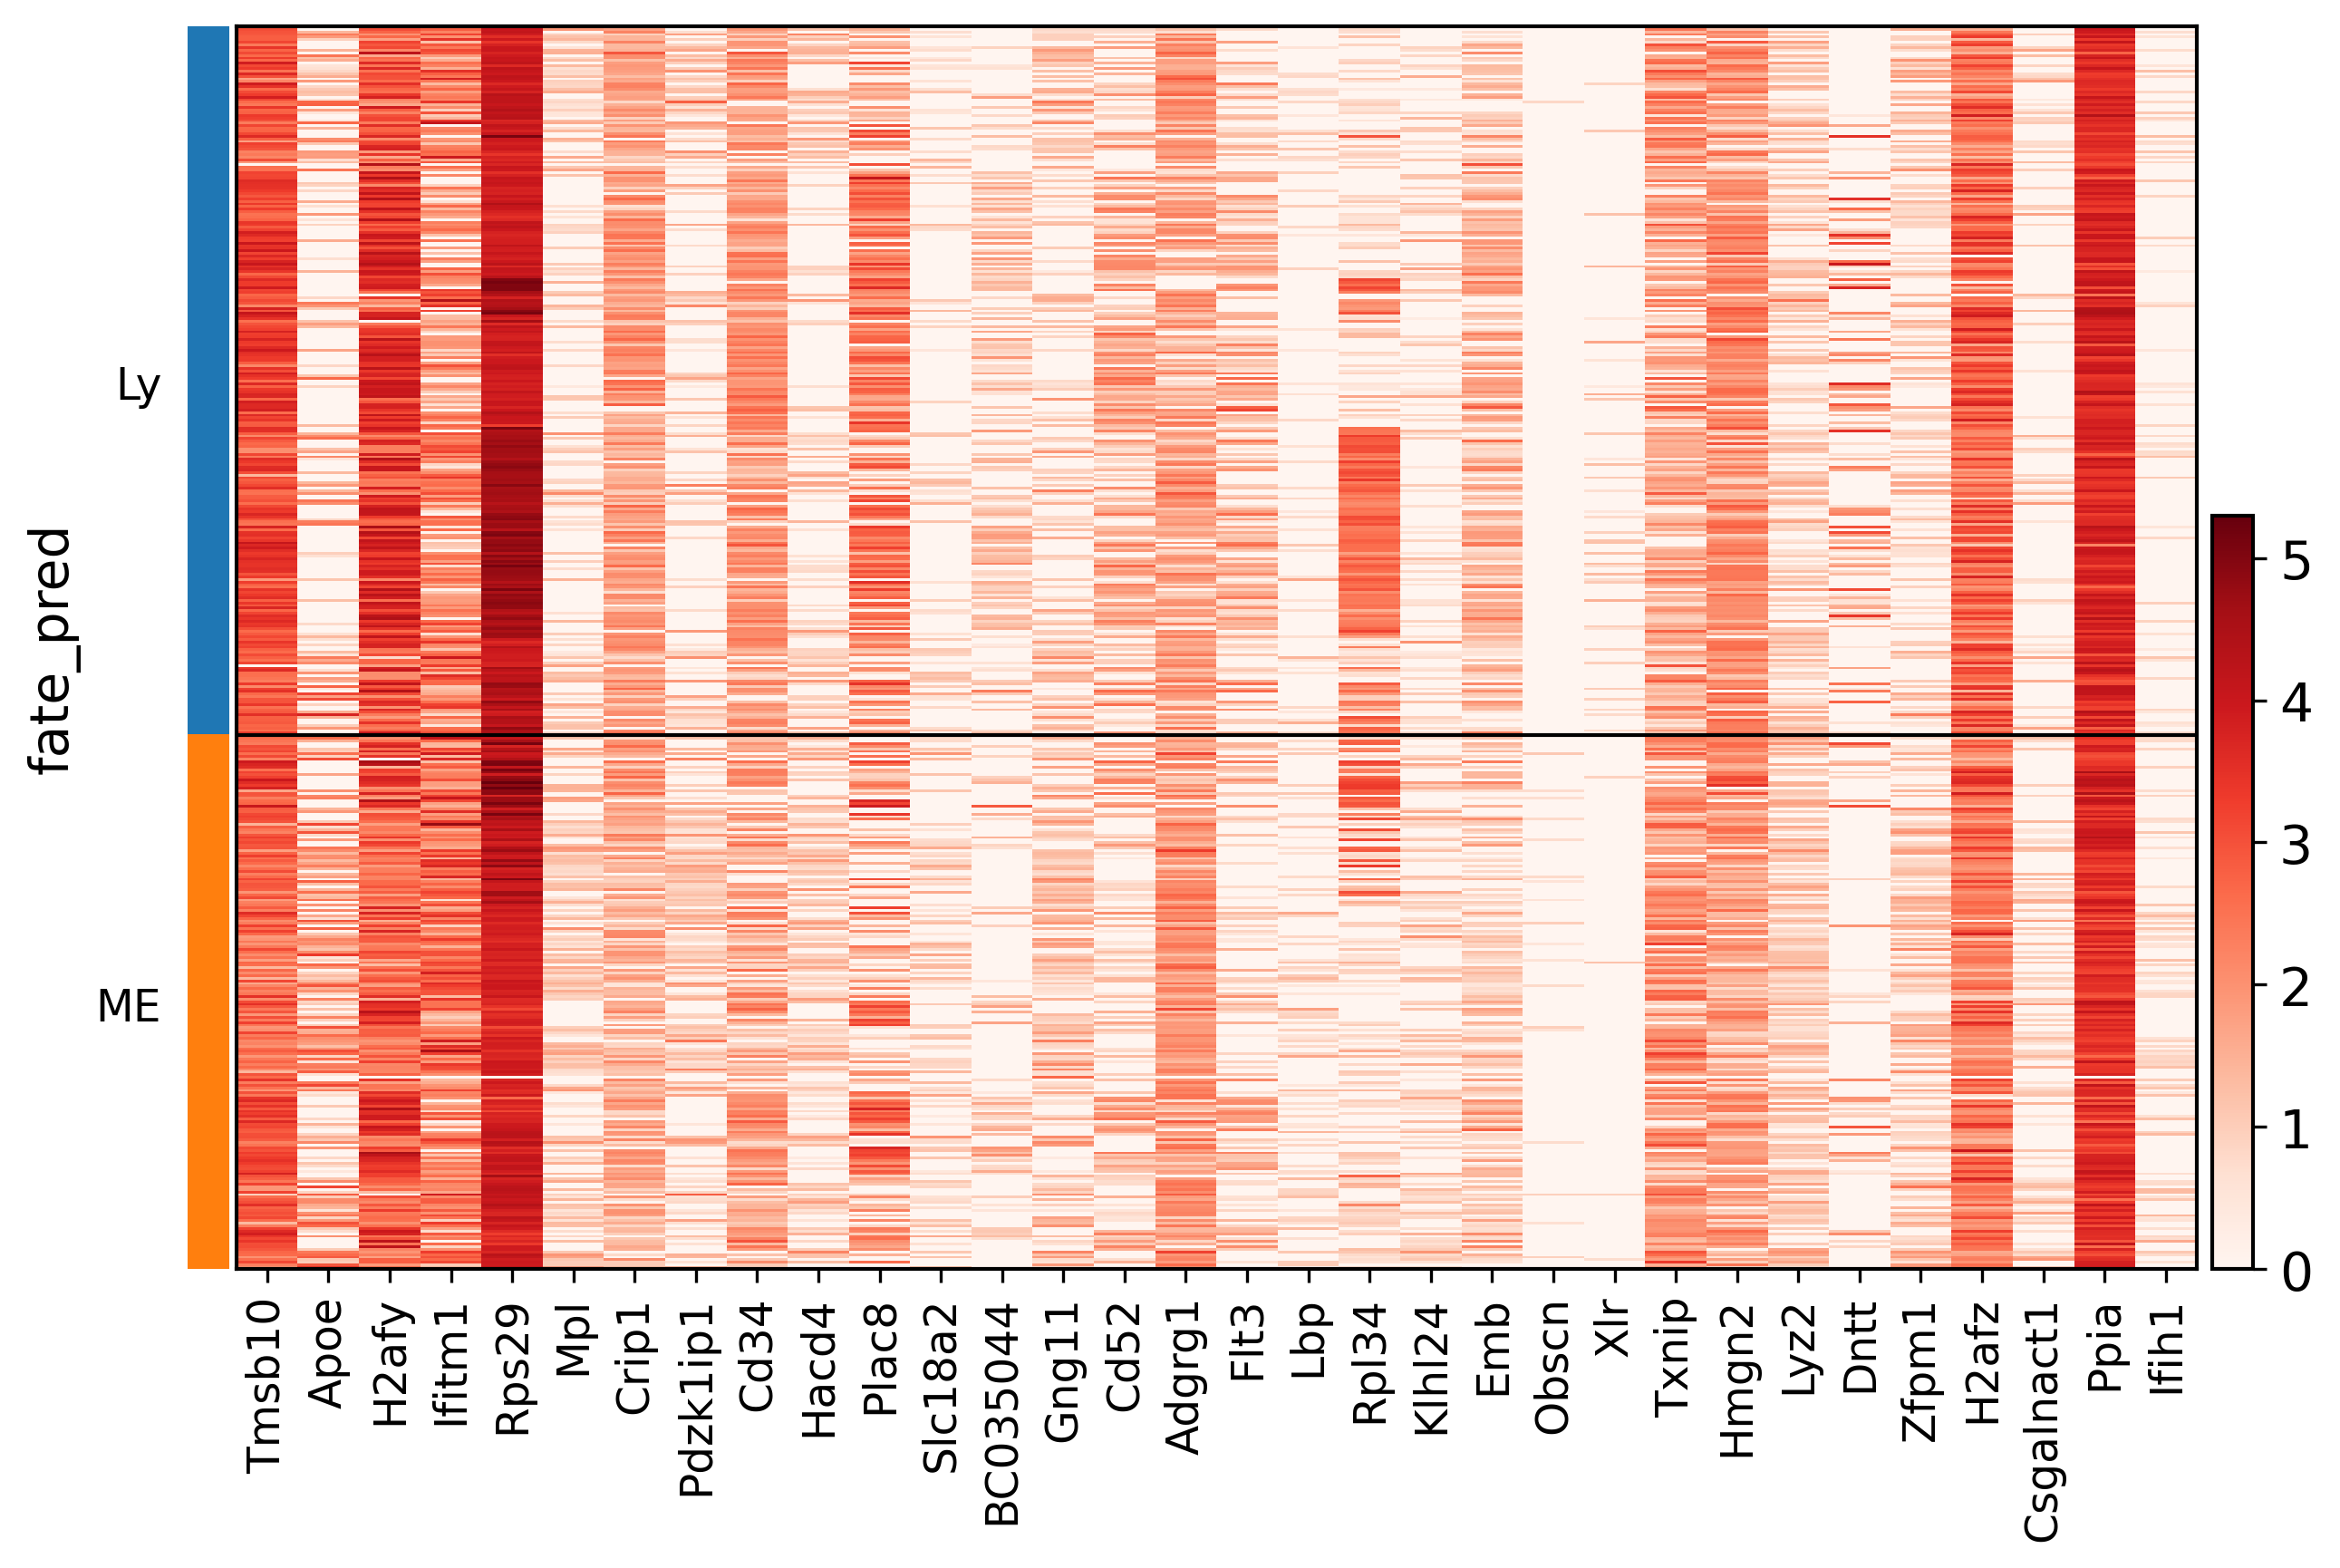

In [787]:

adata3=adata2[(adata2.obs['cell_type']=='HSC')&(adata2.obs['fate_pred'].isin(['ME','Ly']))].copy()
adata3 = adata3[:, ~adata3.var.index.isin(['Xist'])]

from sklearn.neighbors import KNeighborsClassifier
plt.rcParams['font.size'] = 14
fig,ax=createFig(figsize=(3,3))
sc.pl.umap(adata3,color=['fate_pred'],ax=ax,s=10)
sc.tl.rank_genes_groups(adata3, groupby='fate_pred', method='t-test_overestim_var')

sc.pl.heatmap(
    adata3[list(map(lambda x: type(x) == str, adata3.obs['fate_pred']))],  
    pd.DataFrame(adata3.uns['rank_genes_groups']['names']).head(16).to_numpy().flatten(), 
    groupby='fate_pred', cmap='Reds'
    
)

/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


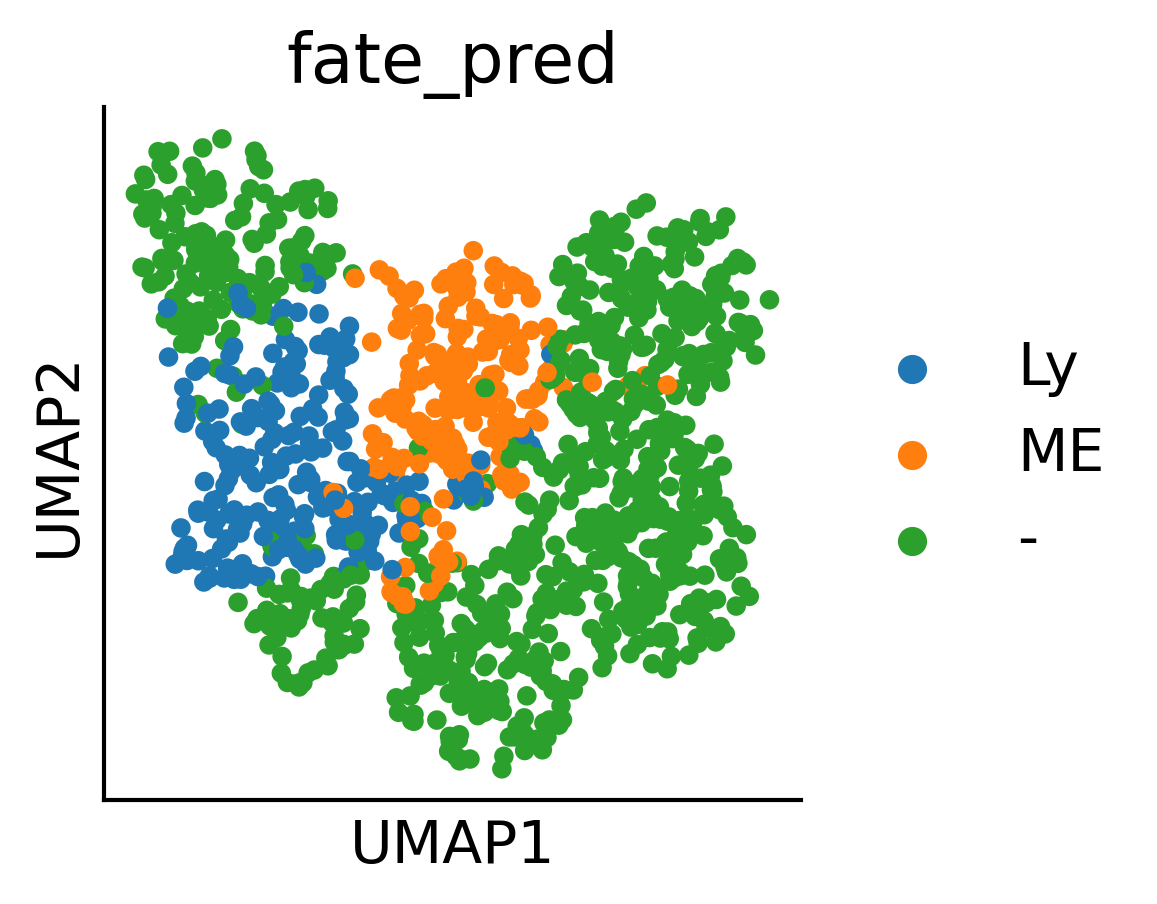

In [607]:
fig,ax=createFig(figsize=(3,3))
sc.pl.umap(adata2,color='fate_pred',ax=ax)#Apoe,Ifitm1,Mpl,Dntt


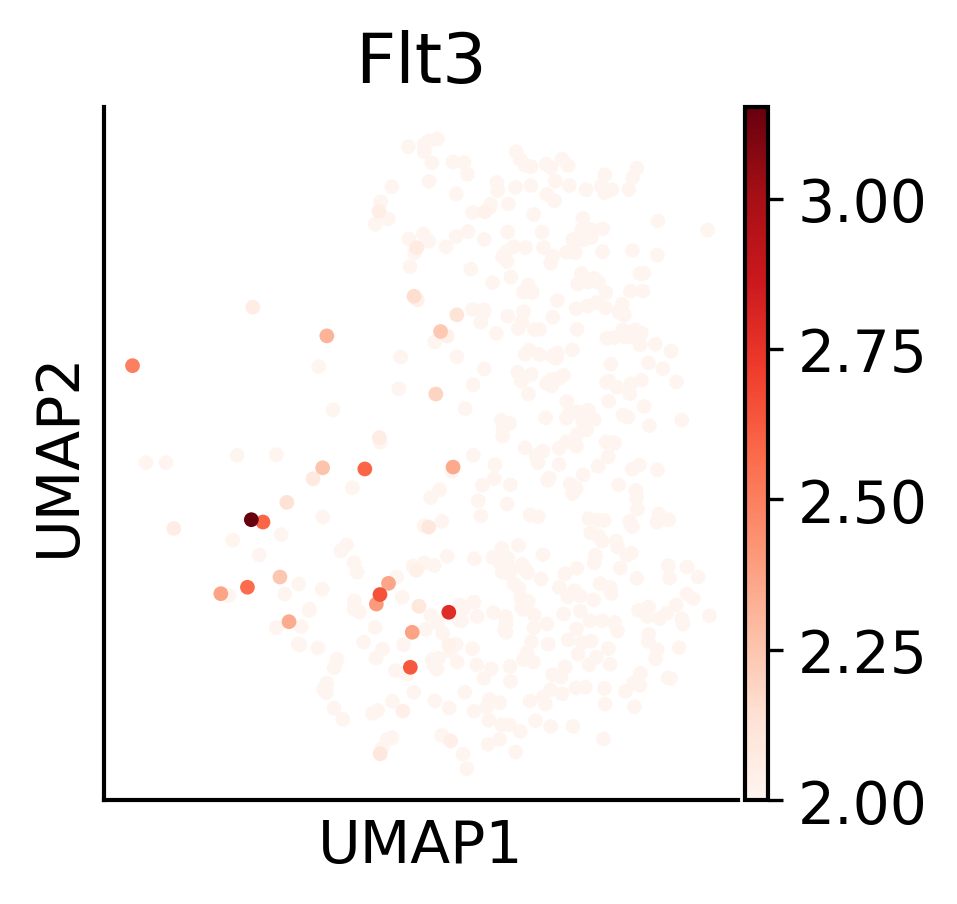

In [722]:
fig,ax=createFig(figsize=(3,3))
sc.pl.umap(adata3,color='Flt3',ax=ax,s=50,cmap='Reds',vmin=1)#Apoe,Ifitm1,Mpl,Dntt


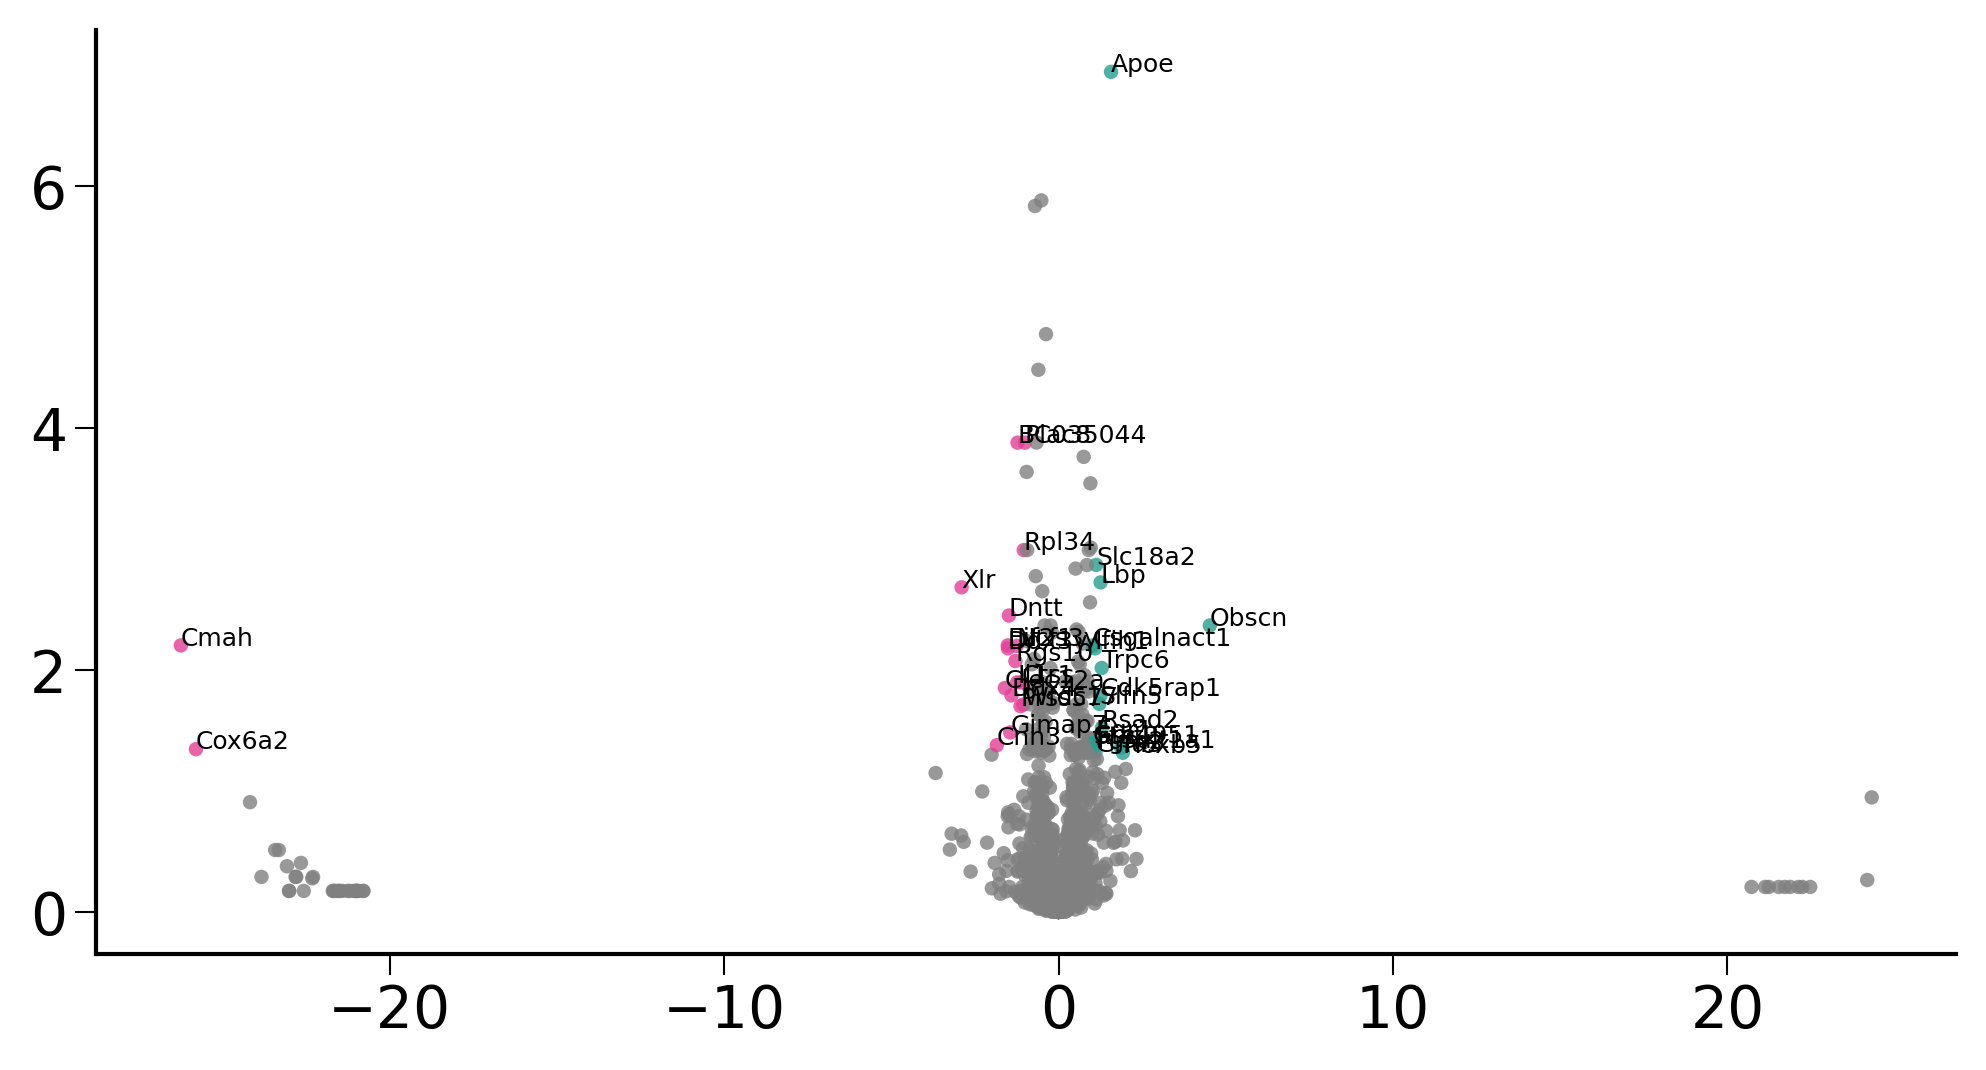

In [677]:
plt.rcParams['font.size'] = 14

fig, ax = ScanpyVolcanoPlot(
    adata3, 
    1, 
    label_log_p=1.3, 
    show_label=True, 
    label_fold_change=1, 
    label_size=6,
    label_excludes=['Xist'],
    add_grid=False,
     color1='#279E8F',
    color2='#E43E96',
)

fig.savefig("/home/zhengtuo/songtao/DestinyNet/pei_figure/pei_volcano.pdf", dpi=1000)

plt.show()


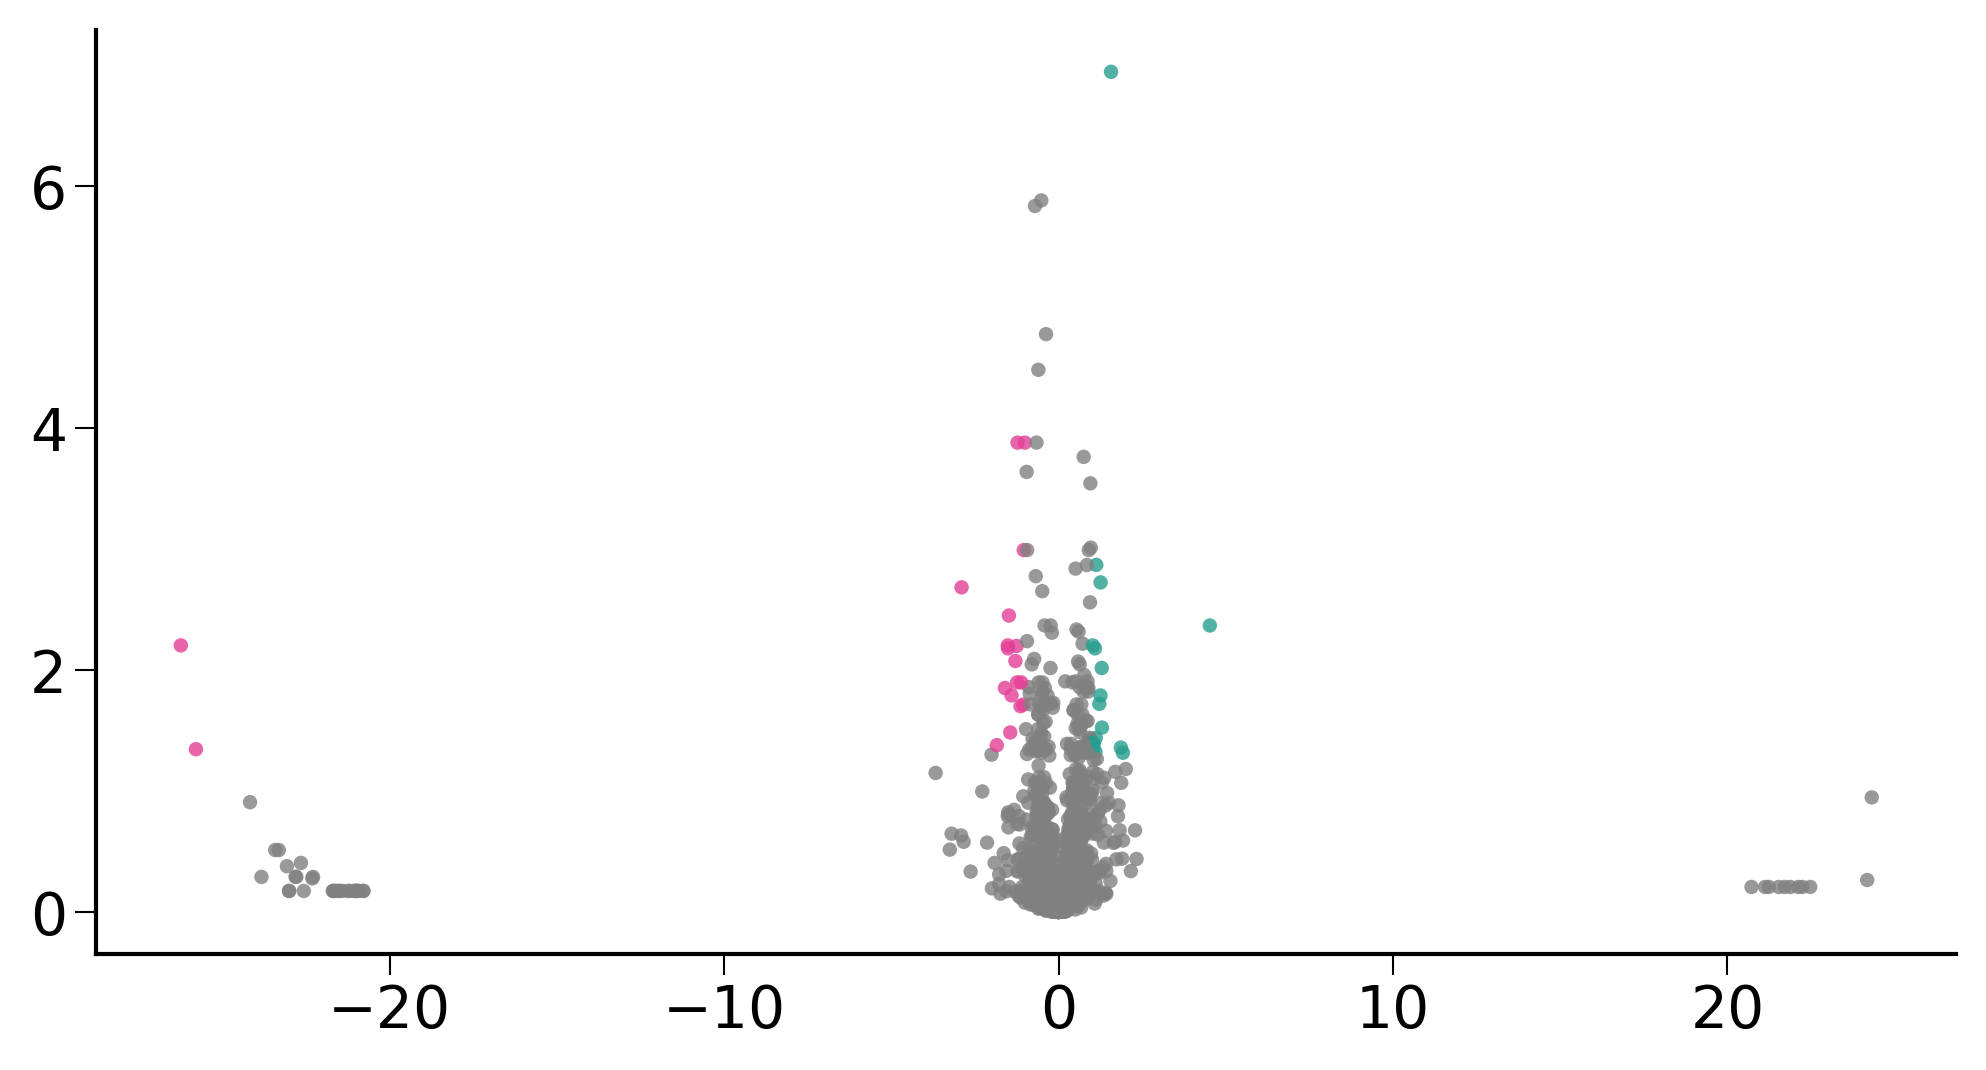

In [678]:
plt.rcParams['font.size'] = 14

fig, ax = ScanpyVolcanoPlot(
    adata3, 
    1, 
    label_log_p=1.3, 
    show_label=False, 
    label_fold_change=1, 
    label_size=6,
    label_excludes=['Xist'],
    add_grid=False,
     color1='#279E8F',
    color2='#E43E96',
)

fig.savefig("/home/zhengtuo/songtao/DestinyNet/pei_figure/pei_volcano_nowords.pdf", dpi=1000)
plt.show()



In [116]:
adata2.obs

sample_name                     CI  \
TTGCATTGTGCGGCTT-Exp1.CLP  GSM4284759.Exp1.CLP  TTGCATTGTGCGGCTT-Exp1   
ACCTGTCGTGGATCAG-Exp1.CLP  GSM4284759.Exp1.CLP  ACCTGTCGTGGATCAG-Exp1   
GATGAGGGTACACGTT-Exp1.CLP  GSM4284759.Exp1.CLP  GATGAGGGTACACGTT-Exp1   
TCCGGGACAAGGTCAG-Exp1.CLP  GSM4284759.Exp1.CLP  TCCGGGACAAGGTCAG-Exp1   
CCTTGTGGTGCCTGCA-Exp1.CLP  GSM4284759.Exp1.CLP  CCTTGTGGTGCCTGCA-Exp1   
...                                        ...                    ...   
ATTCCCGTCAACCGAT-Exp4.MPP  GSM4284780.Exp4.MPP  ATTCCCGTCAACCGAT-Exp4   
TGGGAGACAATCGAAA-Exp4.MPP  GSM4284780.Exp4.MPP  TGGGAGACAATCGAAA-Exp4   
AAAGGGCGTTTCCCAC-Exp4.MPP  GSM4284780.Exp4.MPP  AAAGGGCGTTTCCCAC-Exp4   
TGGCGTGCACCCTGAG-Exp4.MPP  GSM4284780.Exp4.MPP  TGGCGTGCACCCTGAG-Exp4   
GACCCAGCAAATACAG-Exp4.MPP  GSM4284780.Exp4.MPP  GACCCAGCAAATACAG-Exp4   

                          max.barcode      type leiden cell_type batch_name  \
TTGCATTGTGCGGCTT-Exp1.CLP         1H9  Exp1_CLP     14        Ly      Exp.1   
ACCTGTCGTGGATCAG-Exp1.CLP         1F7  Exp1_CLP     10        Ly      Exp.1   
GATGAGGGTACACGTT-Exp1.CLP         389  Exp1_CLP     14        Ly      Exp.1   
TCCGGGACAAGGTCAG-Exp1.CLP         A69  Exp1_CLP     10        Ly      Exp.1   
CCTTGTGGTGCCTGCA-Exp1.CLP         1H9  Exp1_CLP      3        My      Exp.1   
...                               ...       ...    ...       ...        ...   
ATTCCCGTCAACCGAT-Exp4.MPP       123HG  Exp4_MPP      5       HSC      Exp.4   
TGGGAGACAATCGAAA-Exp4.MPP       123H9  Exp4_MPP      1       HSC      Exp.4   
AAAGGGCGTTTCCCAC-Exp4.MPP       14569  Exp4_MPP      5       HSC      Exp.4   
TGGCGTGCACCCTGAG-Exp4.MPP       12GD3  Exp4_MPP      6        My      Exp.4   
GACCCAGCAAATACAG-Exp4.MPP       IH127  Exp4_MPP      1       HSC      Exp.4   

                          fate_bias  index HSC_preference fate_pred  
TTGCATTGTGCGGCTT-Exp1.CLP       NaN     15            NaN       NaN  
ACCTGTCGTGGATCAG-Exp1.CLP       NaN     41            NaN       NaN  
GATGAGGGTACACGTT-Exp1.CLP       NaN     57            NaN       NaN  
TCCGGGACAAGGTCAG-Exp1.CLP       NaN     78            NaN       NaN  
CCTTGTGGTGCCTGCA-Exp1.CLP       NaN     83            NaN       NaN  
...                             ...    ...            ...       ...  
ATTCCCGTCAACCGAT-Exp4.MPP       NaN  23645             ME        Ly  
TGGGAGACAATCGAAA-Exp4.MPP       NaN  23665             ME        ME  
AAAGGGCGTTTCCCAC-Exp4.MPP       NaN  23688             Ly        Ly  
TGGCGTGCACCCTGAG-Exp4.MPP       NaN  23724            NaN       NaN  
GACCCAGCAAATACAG-Exp4.MPP       NaN  23742             ME        Ly  

[1366 rows x 11 columns]

In [794]:
adata3_GT=adata2[adata2.obs['HSC_preference'].isin(['Ly','ME'])]
sc.tl.rank_genes_groups(adata3_GT, groupby='HSC_preference', method='t-test_overestim_var')


/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


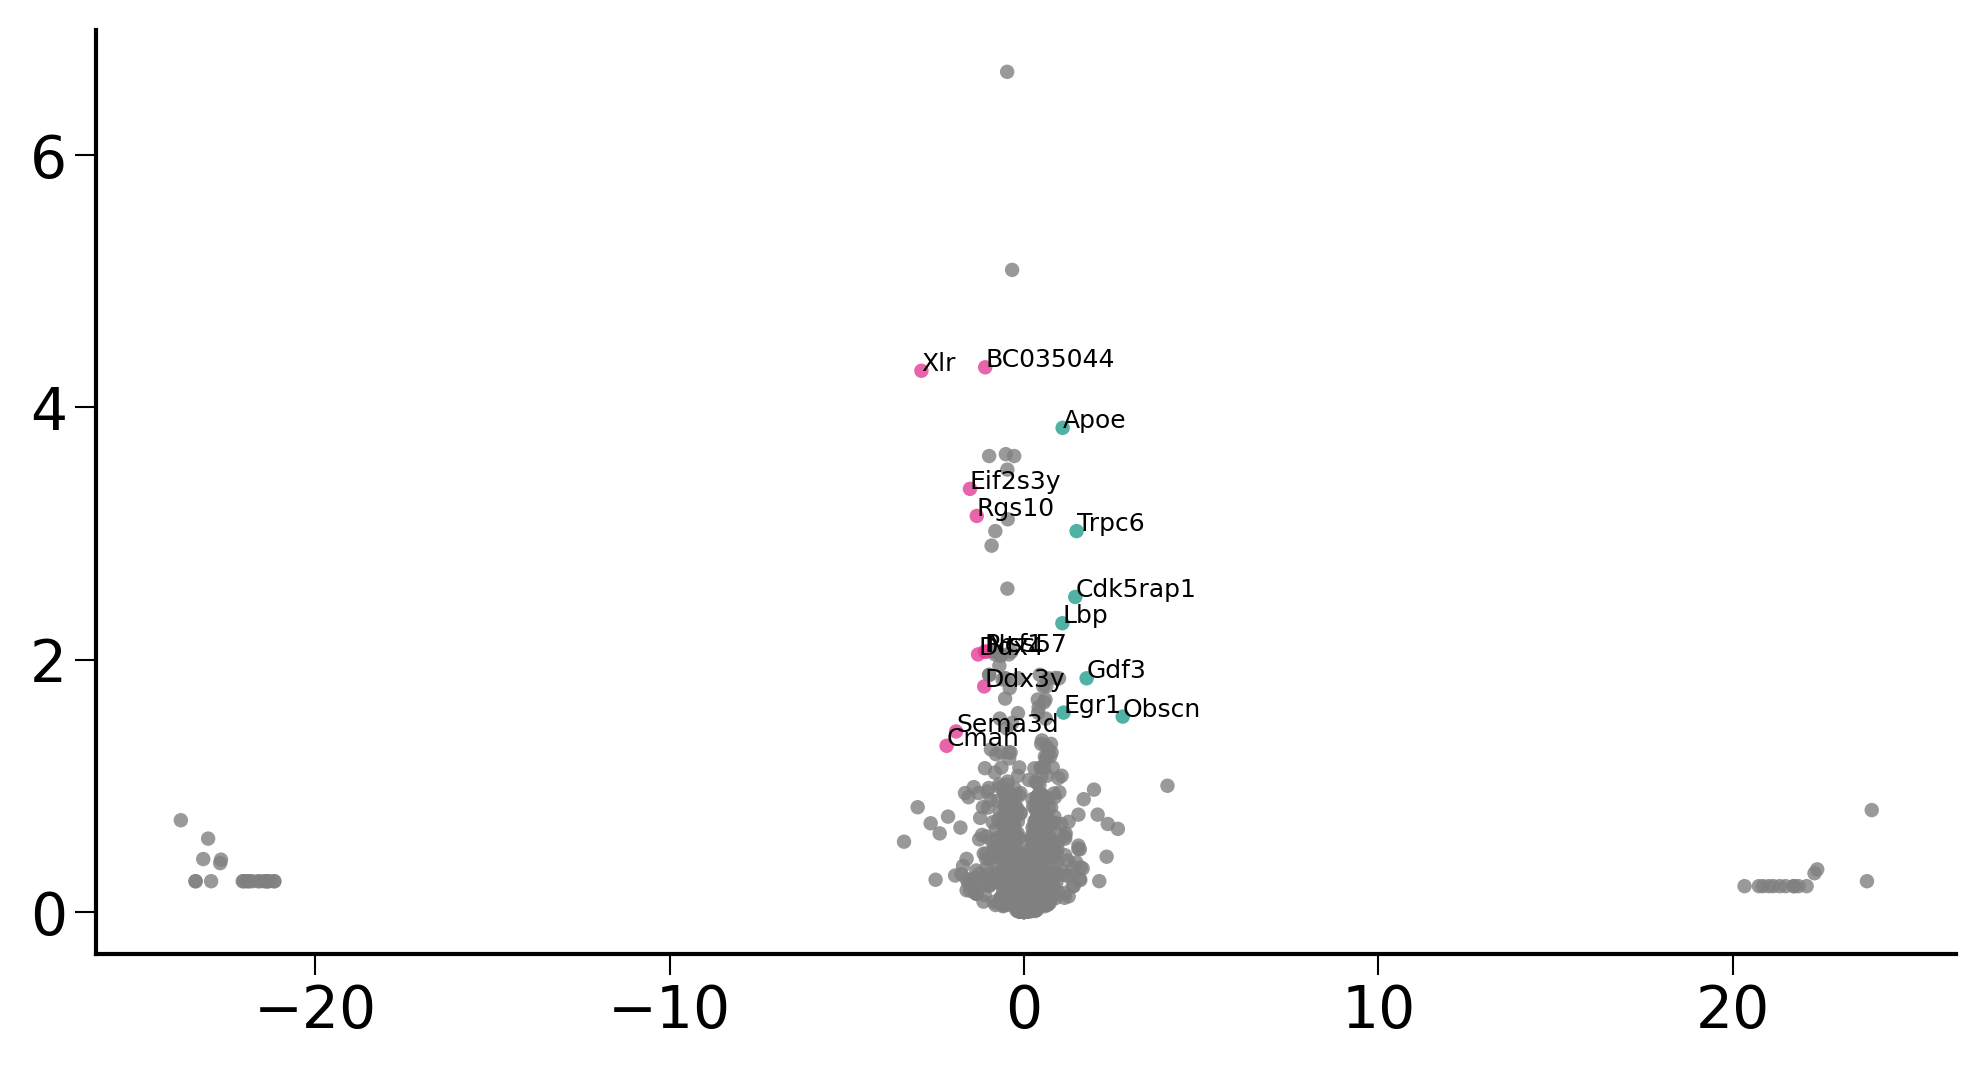

In [680]:
plt.rcParams['font.size'] = 14

fig, ax = ScanpyVolcanoPlot(
    adata3_GT, 
    1, 
    label_log_p=1.3, 
    show_label=True, 
    label_fold_change=1, 
    label_size=6,
    label_excludes=['Xist'],
    add_grid=False,
     color1='#279E8F',
    color2='#E43E96',
)

fig.savefig("/home/zhengtuo/songtao/DestinyNet/pei_figure/pei_volcano_GT.pdf", dpi=1000)
plt.show()


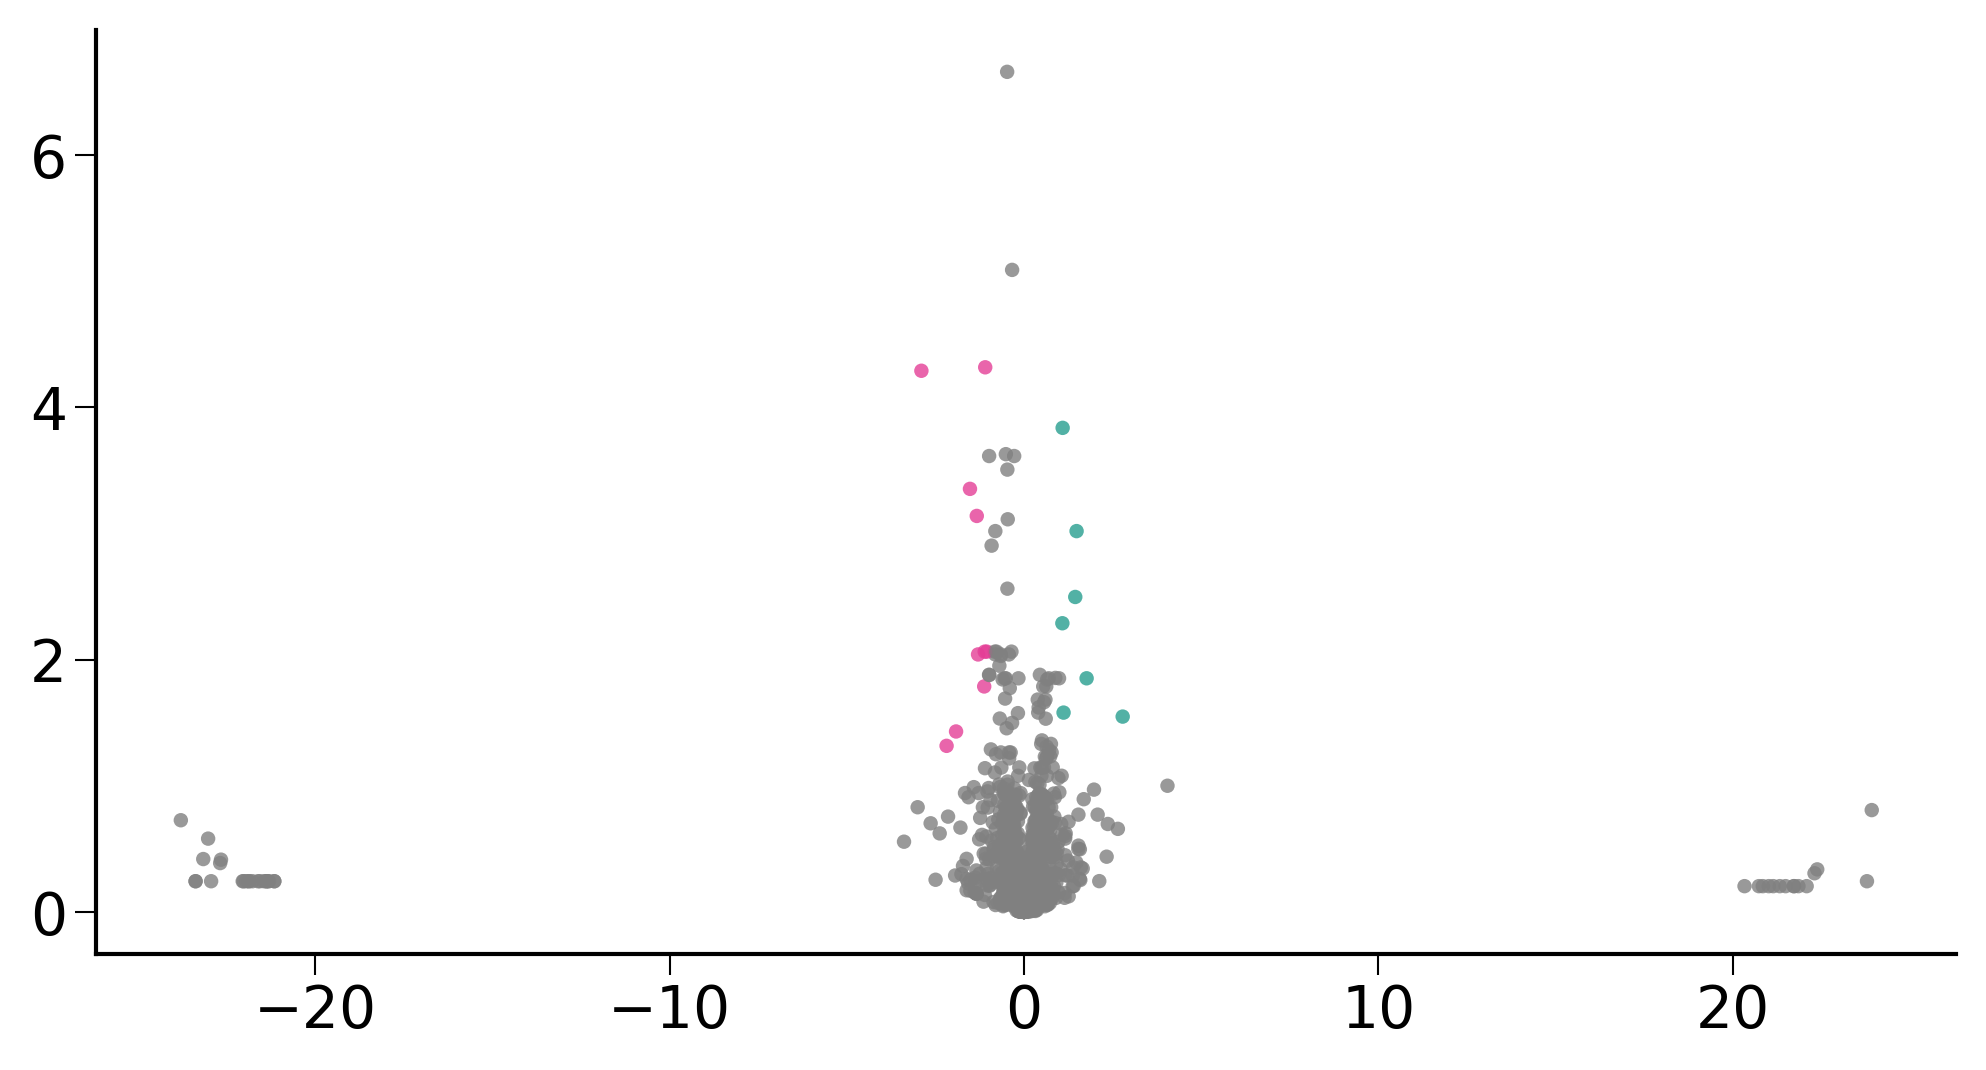

In [681]:
plt.rcParams['font.size'] = 14

fig, ax = ScanpyVolcanoPlot(
    adata3_GT, 
    1, 
    label_log_p=1.3, 
    show_label=False, 
    label_fold_change=1, 
    label_size=6,
    label_excludes=['Xist'],
    add_grid=False,
     color1='#279E8F',
    color2='#E43E96',
)

fig.savefig("/home/zhengtuo/songtao/DestinyNet/pei_figure/pei_volcano_GT_nowords.pdf", dpi=1000)
plt.show()



In [14]:
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import torch.nn as nn

def compute_gradients_for_label(target_label, data, model_encoder, model_decoder):
    mask = data.obs['fate_pred'] == target_label
    filtered_data = data[mask]
    
    geneex_data = torch.tensor(filtered_data.X.toarray(), dtype=torch.float32).to(device2)
    
    dataset = TensorDataset(geneex_data)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=False)
    
    total_gradients = torch.zeros(len_geneExp).to(device2)
    for batch in dataloader:
        geneExp = batch[0]
        geneExp = Variable(geneExp, requires_grad=True)
        output_data = model_encoder(geneExp)
        output_data = model_decoder(output_data)
        
        loss_function = nn.MSELoss()
        loss = loss_function(output_data, geneExp)
        
        model_encoder.zero_grad()
        model_decoder.zero_grad()
        loss.backward()

        total_gradients += geneExp.grad.abs().mean(dim=0)

    average_gradients = total_gradients / len(dataloader)
    
    return average_gradients

labels = ['Ly', 'ME']
gradients_per_label = {}

for label in labels:
    gradients_per_label[label] = compute_gradients_for_label(label, adata2, geneEnc, geneDec)


In [15]:
num_key_genes = 100 

key_genes_per_label = {}

for label, gradients in gradients_per_label.items():
    df = pd.DataFrame({
        'gene_ids': adata2.var.index.values,
        'importance': gradients.cpu().detach().numpy()
    })

    sorted_df = df.sort_values(by="importance", ascending=False)
    
    key_genes = sorted_df['gene_ids'].head(num_key_genes).tolist() 
    key_genes_per_label[label] = key_genes

for label, genes in key_genes_per_label.items():
    print(f"Key genes for label {label}:")
    print(', '.join(genes))
    print("\n")


Key genes for label Ly:
Rpl34, Rps27, Rpl39, Rps24, Ifitm1, Rps29, Rps21, Rplp1, Rpl37a, Rpl38, Rpl37, Rpl32, Rps7, Eef1a1, Rplp0, Rpl41, Ptma, Rps12, Ctla2a, Rpl3, Ifitm3, Tmsb10, Rps18, Hlf, Rpl17, Ppia, Tmsb4x, H2afy, Nrgn, Gcnt2, Vamp5, Cdk6, Adgrg1, Hsp90ab1, Hmgn2, Ptprcap, Tmem176b, Angpt1, Npm1, Txnip, Dut, Srgn, Adgrl4, Mif, Marcksl1, Tsc22d3, Ly6a, Plac8, Dapp1, Alyref, H3f3b, Cd34, Ltb, Dntt, Tsc22d1, Pdcd4, Bst2, Hsp90aa1, Emb, Manf, Bcl11a, Kit, Nme1, Tspan32, S100a10, Msi2, H2afz, Ctla2b, Ifi27, Shisa5, Hspa8, Clk1, Meis1, S100a11, Egfl7, Cdv3, Tubb4b, Vezf1, Fxyd5, Lst1, Ifitm2, H2-K1, Lmo2, Hspa5, Myc, Irf2, Hmgb3, Gpx1, Fkbp1a, Bin2, Dek, Rgs18, Stmn1, Ncl, Cd37, Ptpn18, Cbfa2t3, H2-T23, Samsn1, Pnrc1


Key genes for label ME:
Eef1a1, Rplp1, Rps24, Ifitm1, Rplp0, Rps7, Rpl32, Rpl39, Ctla2a, Hlf, Rpl3, Rpl17, Rps12, Rps21, Rps18, Rpl37a, Car2, Rpl41, Ptma, Rps29, Ifitm3, Angpt1, Rpl38, Hsp90ab1, Txnip, Rpl37, Adgrg1, H2-K1, H3f3b, Lmo2, Tmsb4x, Cd63, Ltb, Npm1, Apoe, Pp

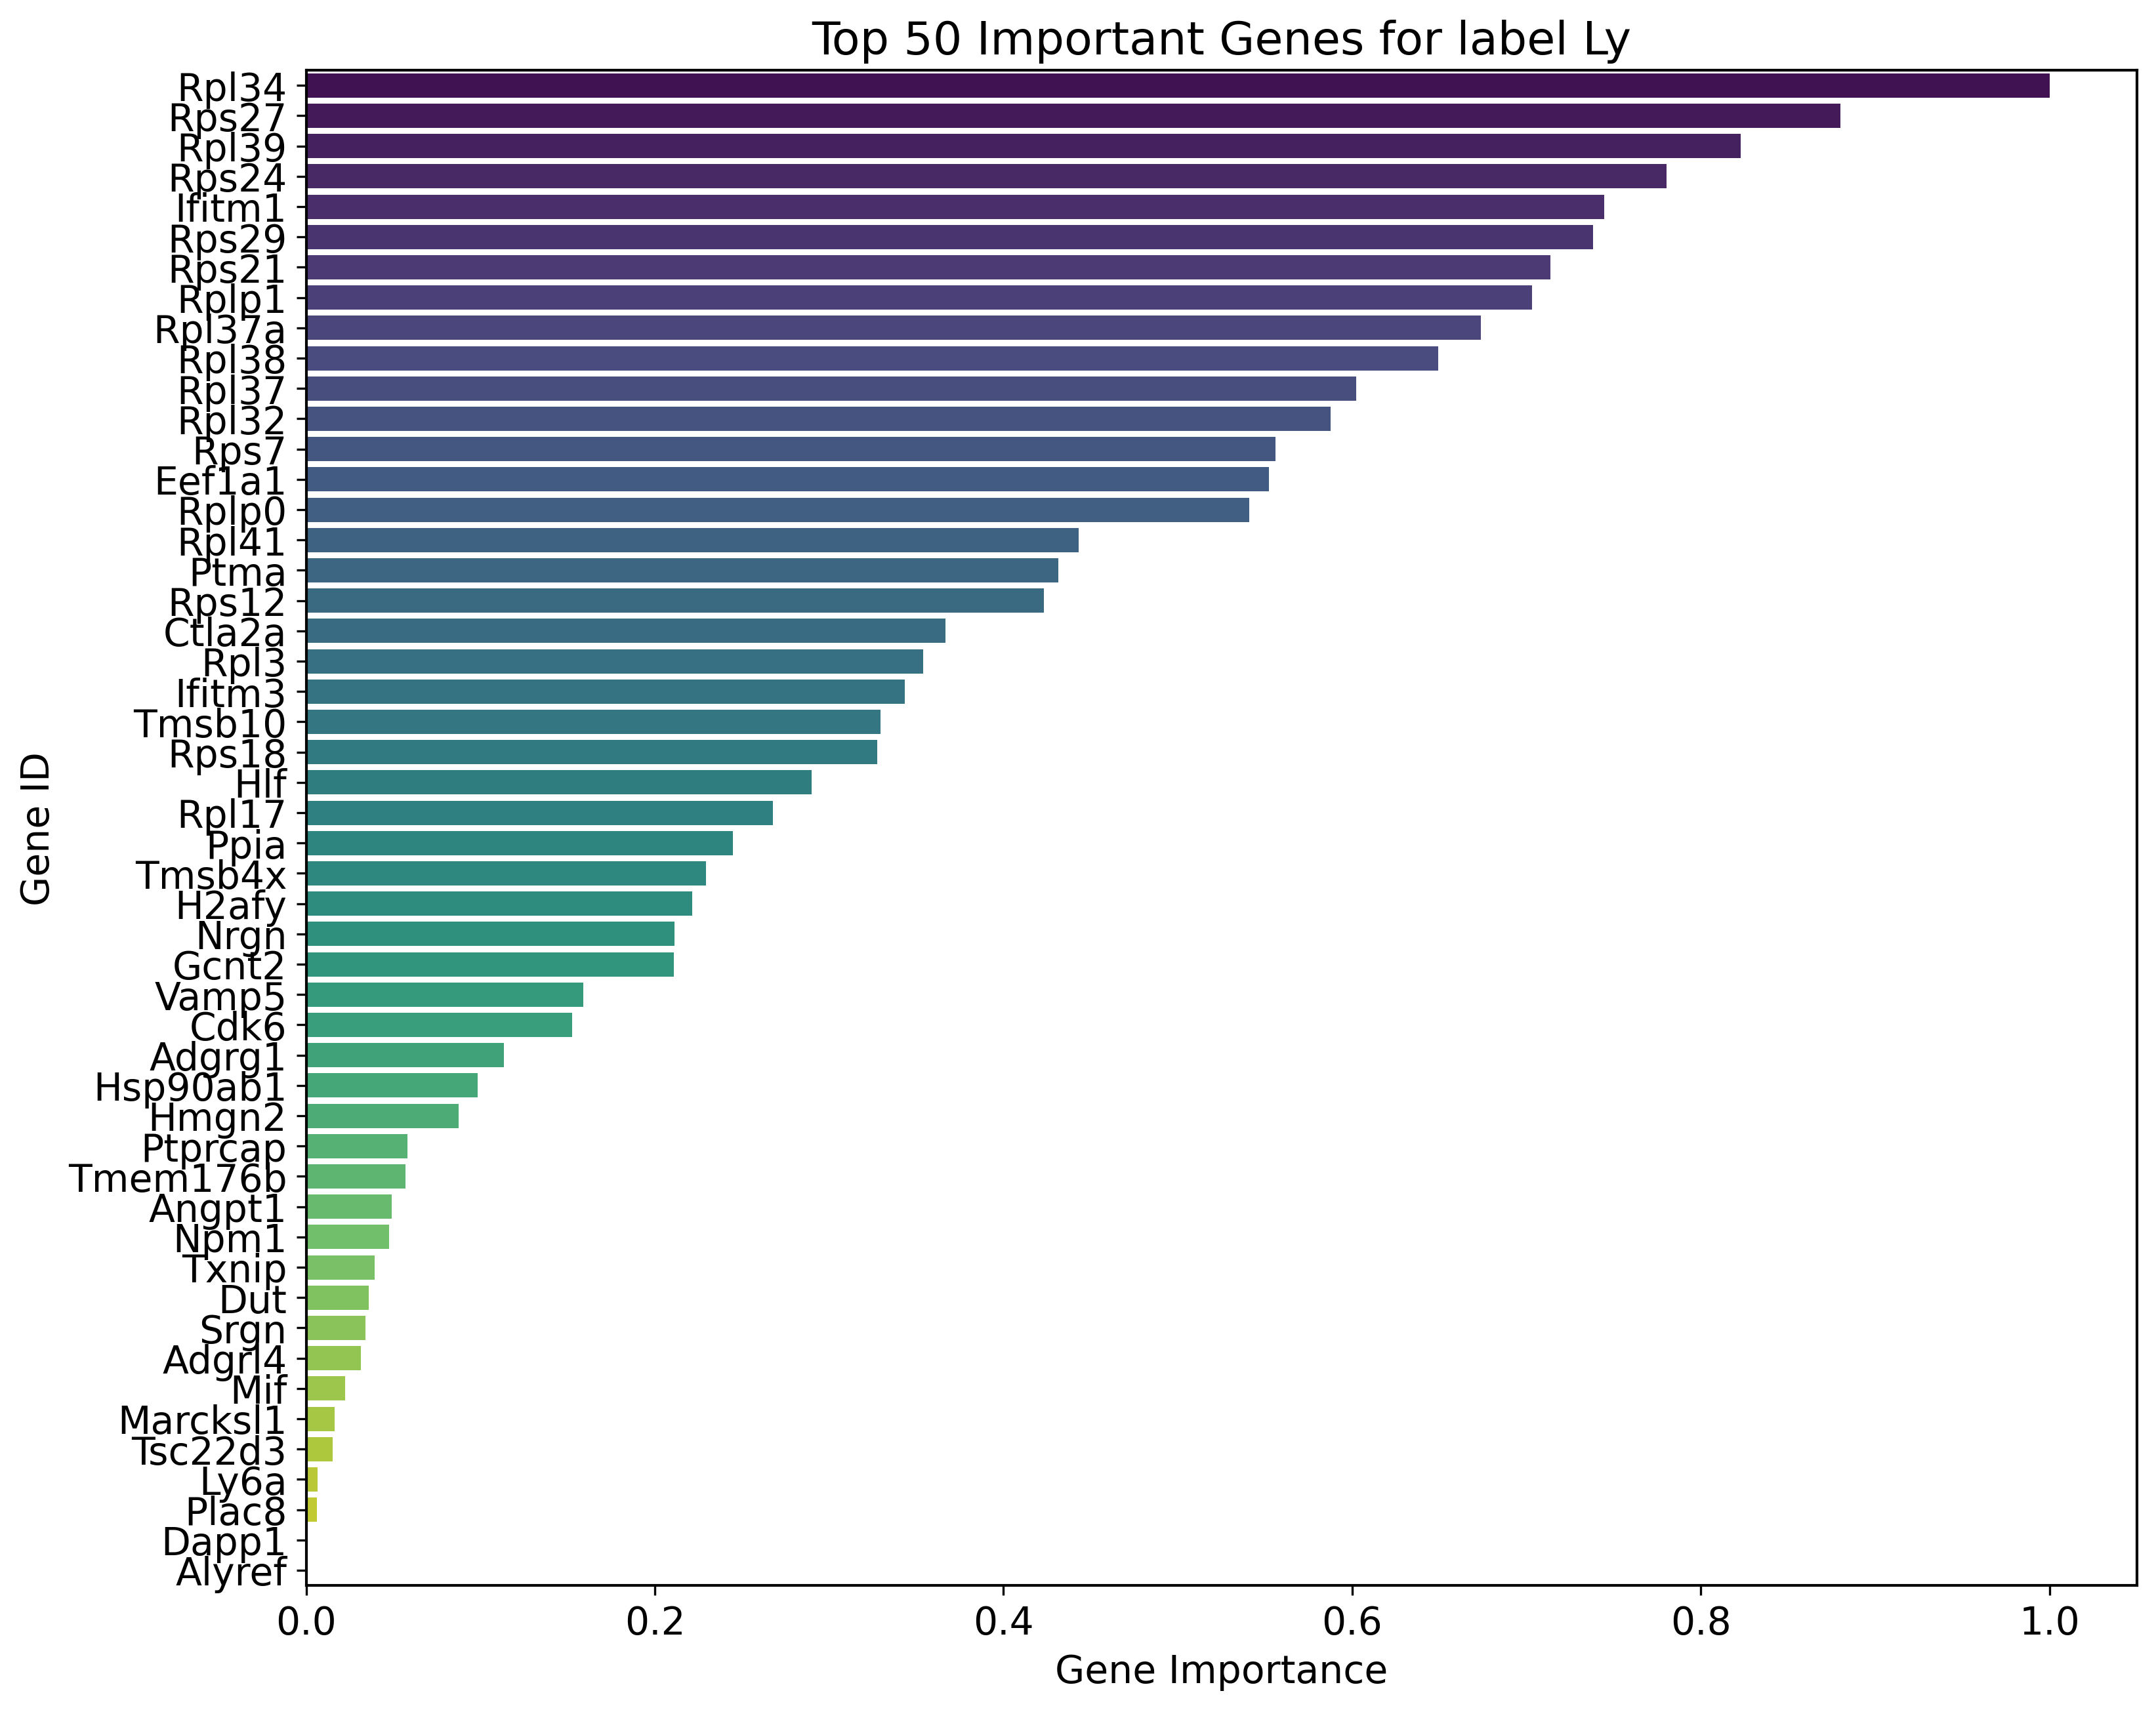

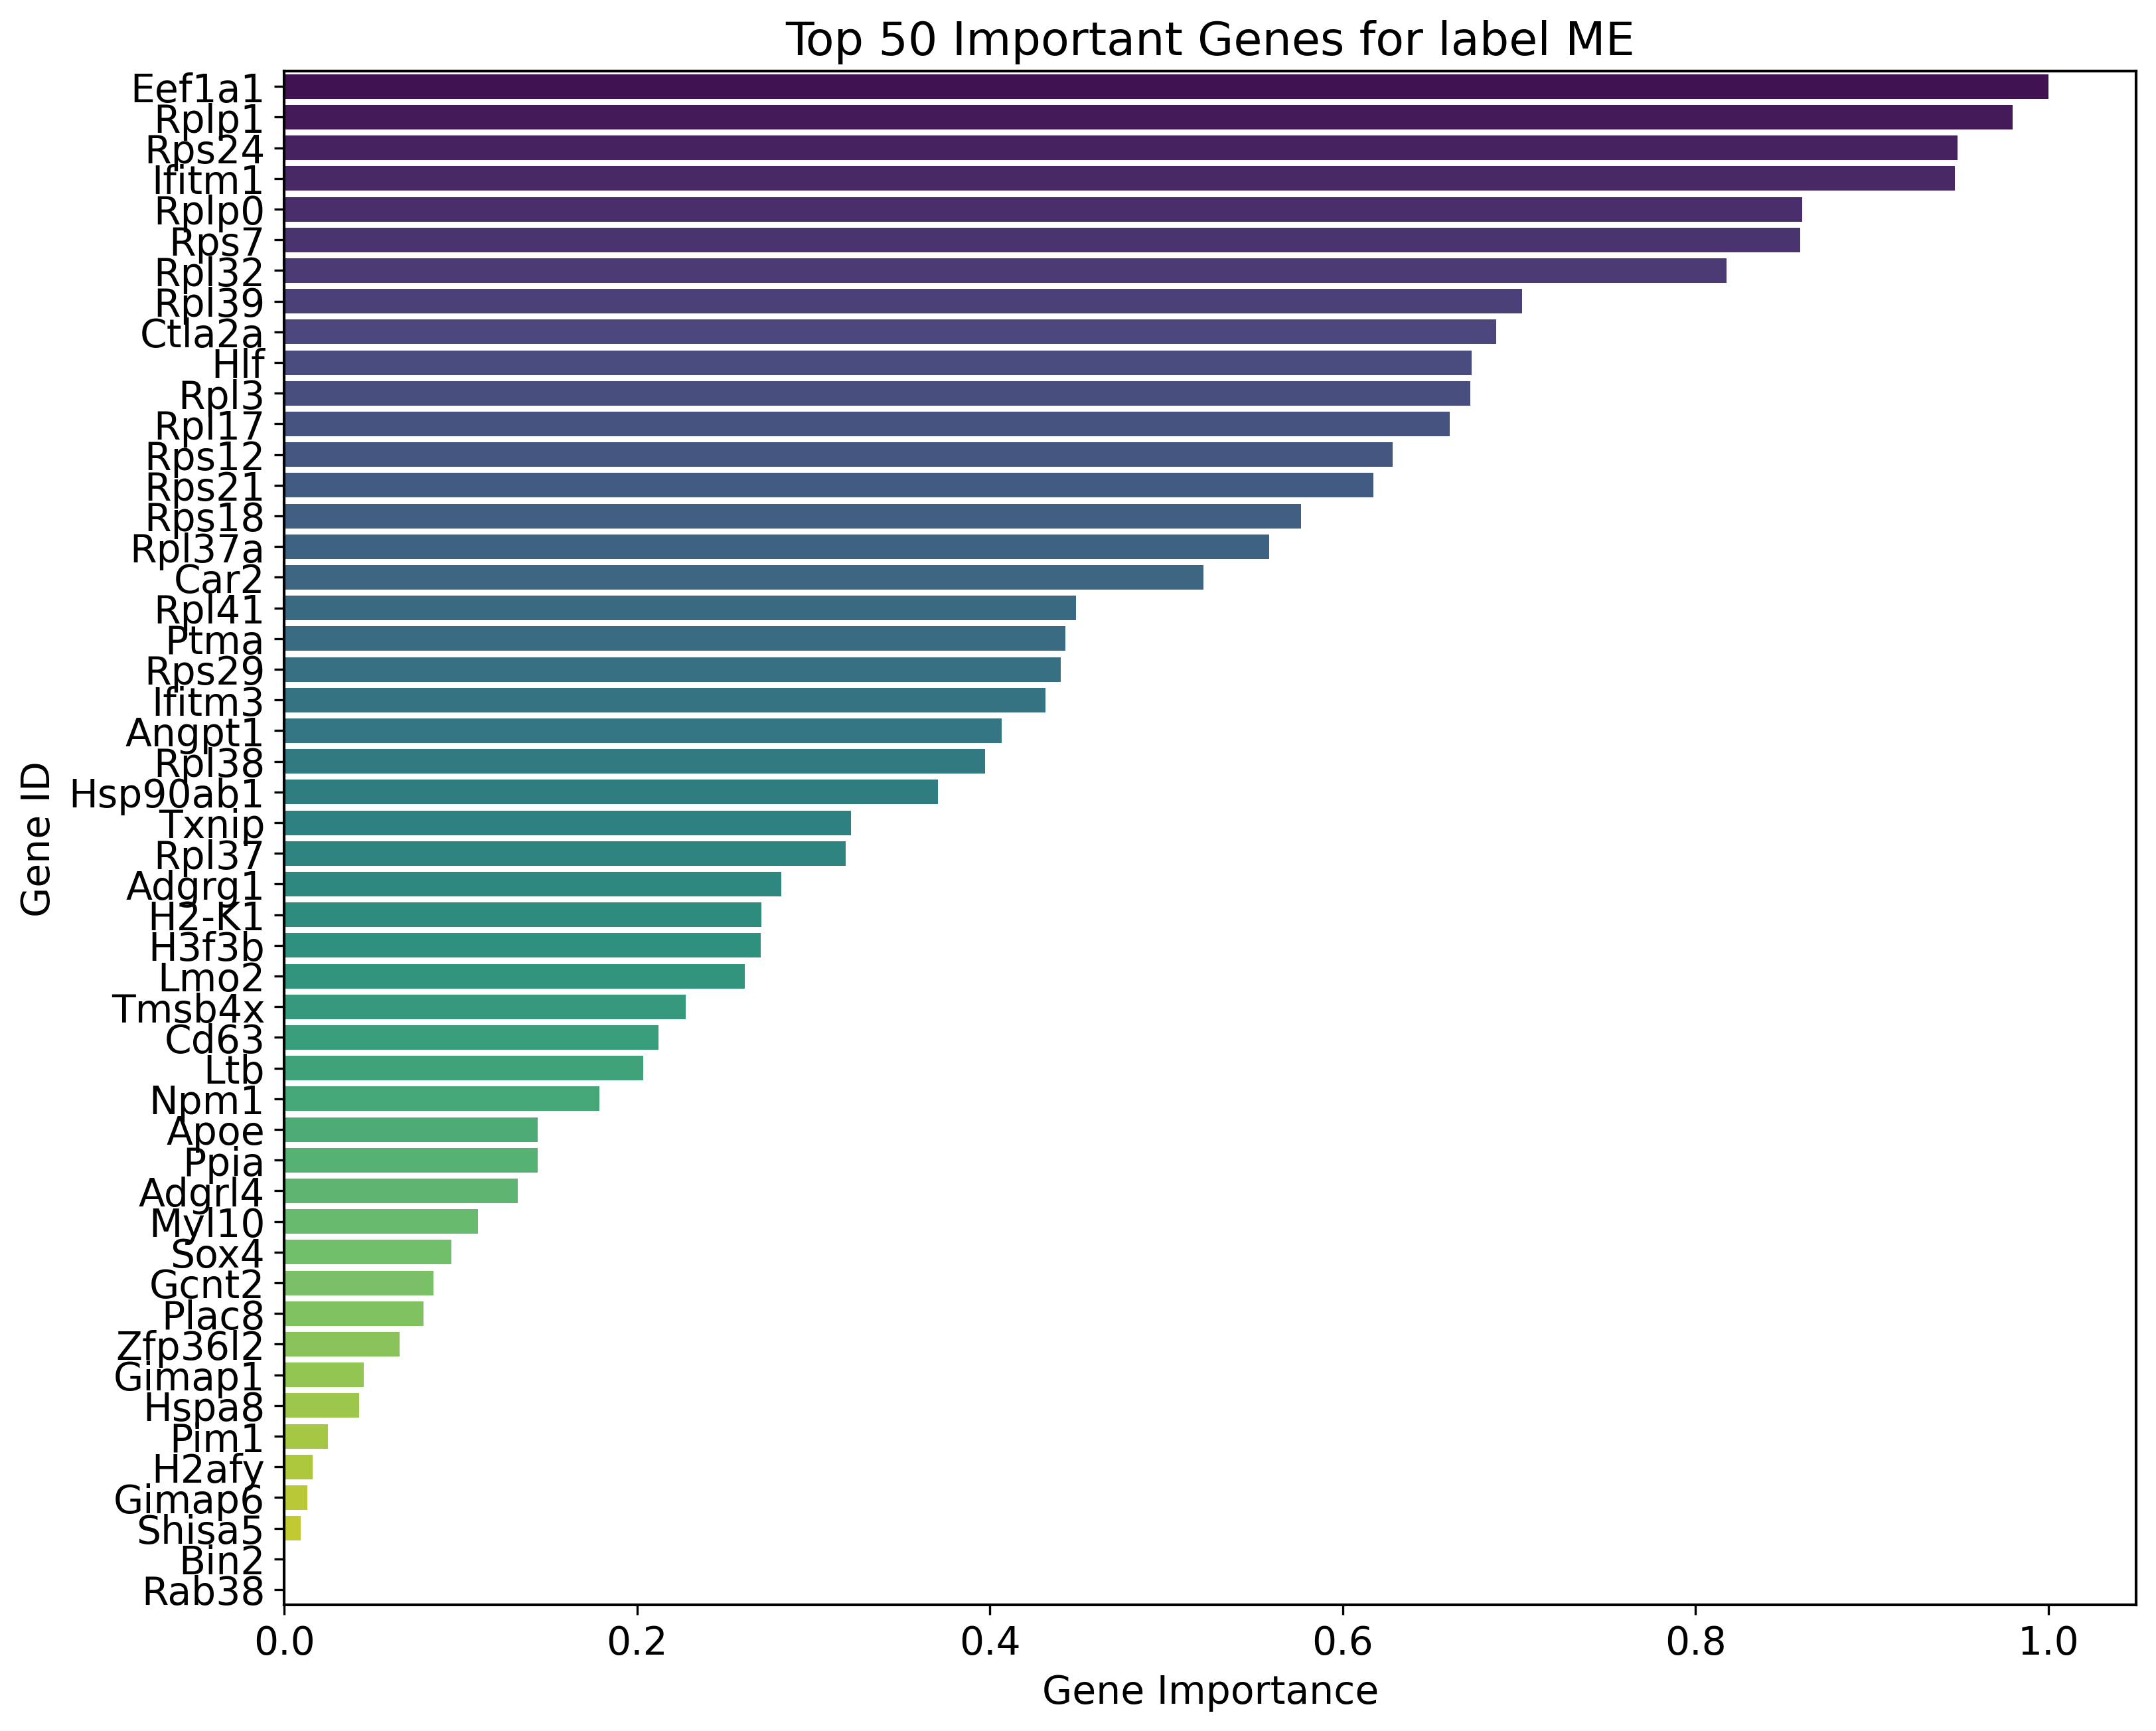

In [16]:
def normalize(array):
    min_val = array.min()
    max_val = array.max()
    return (array - min_val) / (max_val - min_val)

num_key_genes = 50

for label, gradients in gradients_per_label.items():
    df = pd.DataFrame({
        'gene_ids': adata2.var.index.values,
        'importance': gradients.cpu().detach().numpy()
    })

    sorted_df = df.sort_values(by="importance", ascending=False).head(num_key_genes)
    sorted_df['gene_importance'] = normalize(sorted_df['importance'])

    plt.figure(figsize=(12, 10))
    
    sns.barplot(x='gene_importance', y='gene_ids', data=sorted_df, palette='viridis')
    
    plt.title(f"Top {num_key_genes} Important Genes for label {label}")
    plt.xlabel('Gene Importance')
    plt.ylabel('Gene ID')
    plt.show()


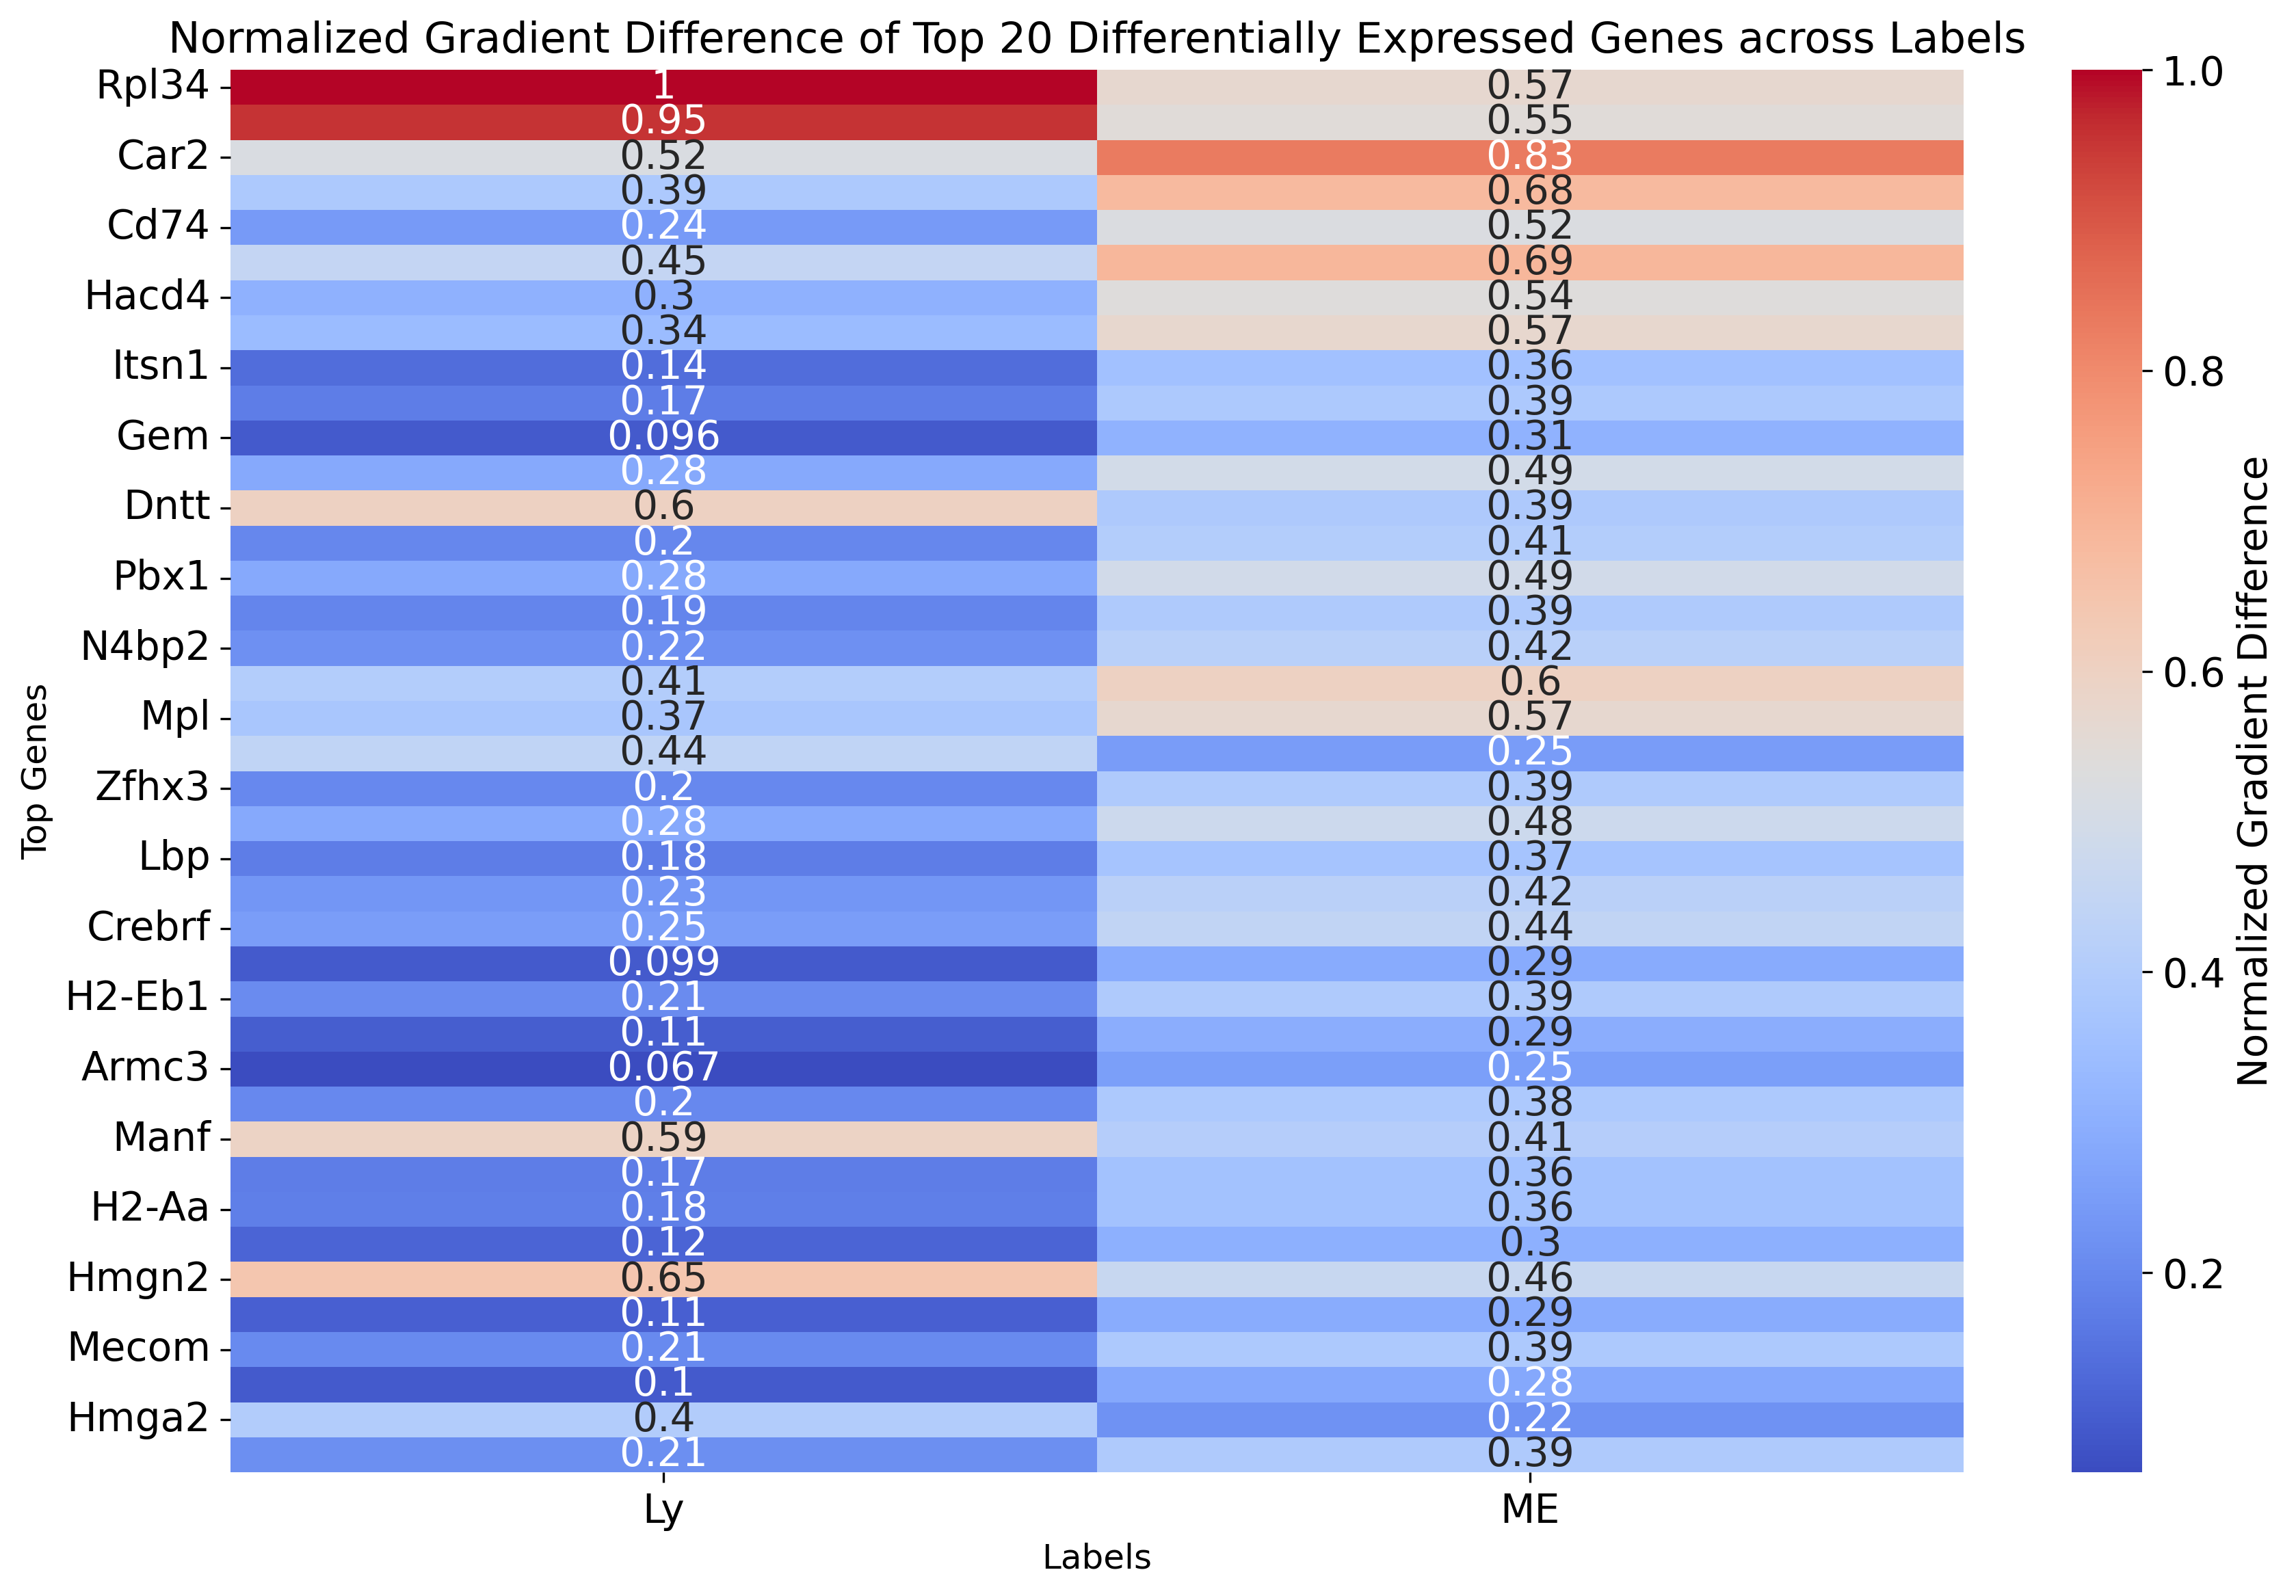

In [63]:
gradient_data = {}
for label, gradients in gradients_per_label.items():
    gradient_data[label] = gradients.cpu().detach().numpy()

df_gradients_all = pd.DataFrame(gradient_data, index=adata2.var.index.values)

def normalize(column):
    """Normalize a pandas column to range between 0 and 1"""
    min_val = column.min()
    max_val = column.max()
    return (column - min_val) / (max_val - min_val)

# Normalize gradients for each label
for label in labels:
    df_gradients_all[label] = normalize(df_gradients_all[label])

# Compute difference between normalized gradients for the two labels
df_gradients_all['diff'] = (df_gradients_all[labels[0]] - df_gradients_all[labels[1]])

# Select the top 20 genes with the largest gradient difference
top_genes = df_gradients_all['diff'].abs().nlargest(40).index

# Extract the normalized gradient values for the top genes
df_gradient_top = df_gradients_all.loc[top_genes, labels]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_gradient_top, cmap="coolwarm", annot=True, cbar_kws={'label': 'Normalized Gradient Difference'})
plt.title("Normalized Gradient Difference of Top 20 Differentially Expressed Genes across Labels", fontsize=15)
plt.ylabel('Top Genes', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.tight_layout()
plt.show()

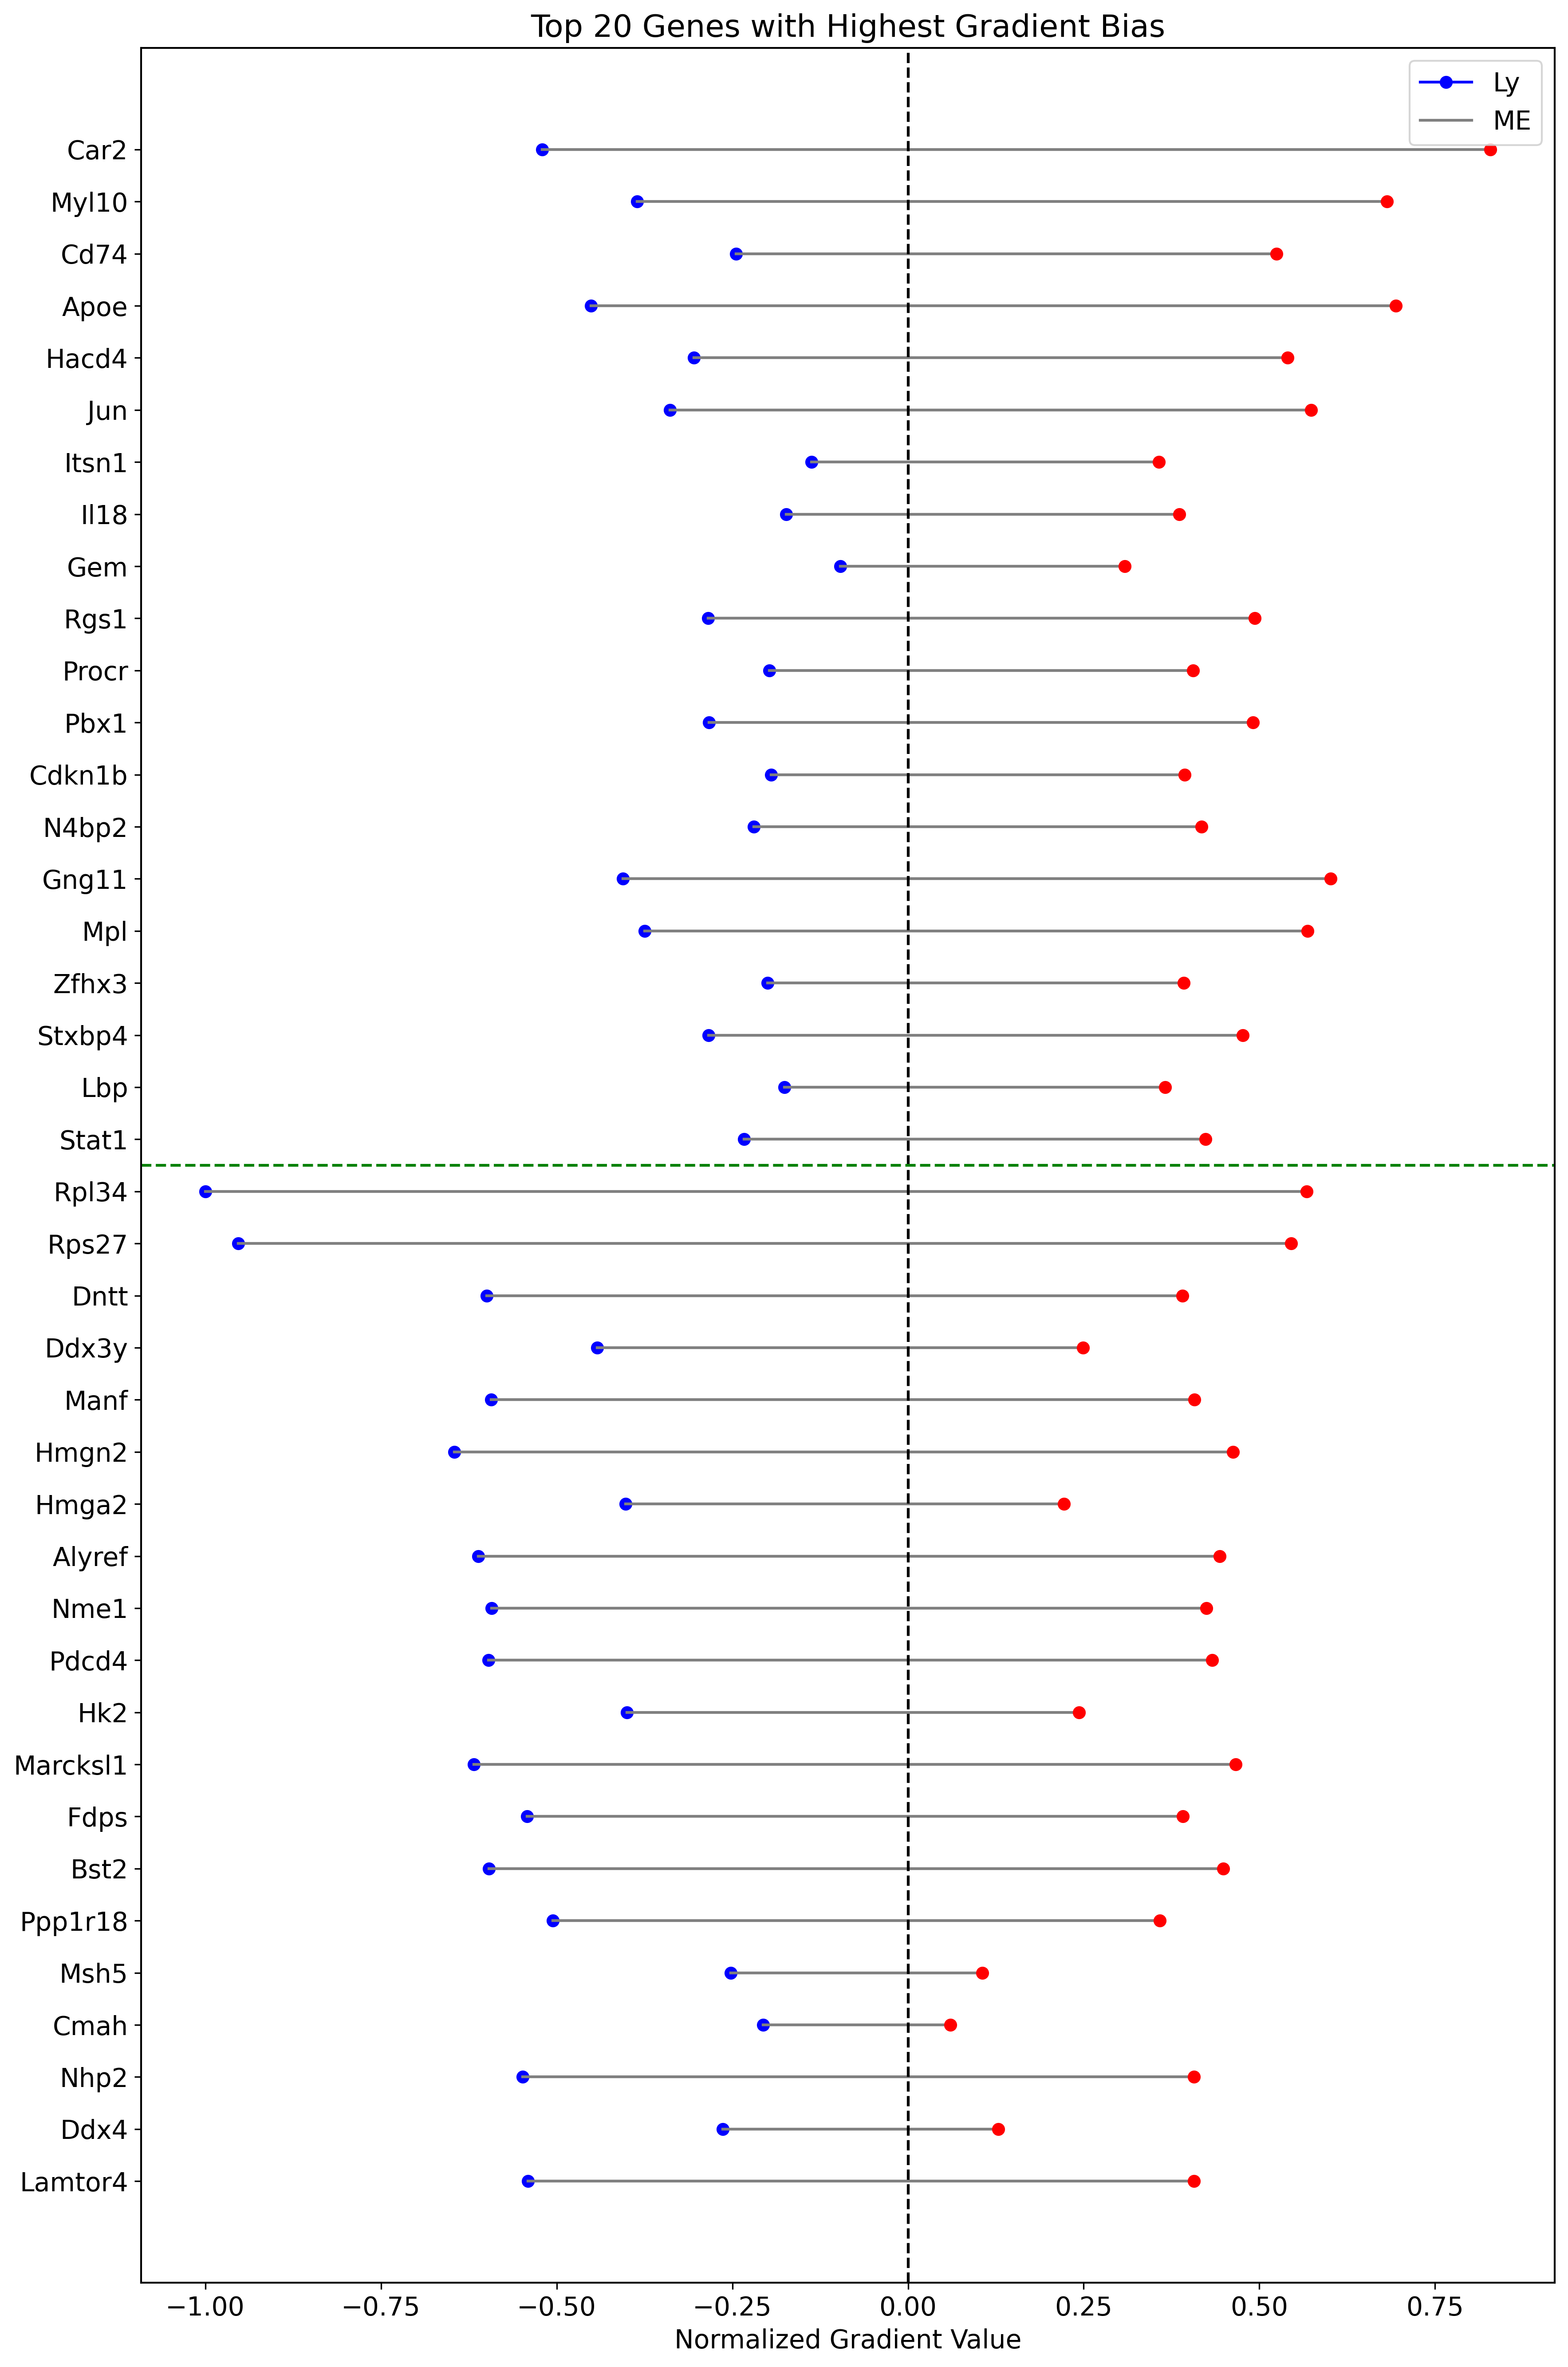

In [64]:
import matplotlib.pyplot as plt
df_gradients_all_normalized = df_gradients_all.copy()
# for label in labels:
#     df_gradients_all_normalized[label] = (df_gradients_all[label] - df_gradients_all[label].min()) / (df_gradients_all[label].max() - df_gradients_all[label].min())
num=20
df_gradients_all_normalized[labels[0]] = -df_gradients_all_normalized[labels[0]]

df_gradients_all_normalized['bias'] = df_gradients_all_normalized[labels[1]] + df_gradients_all_normalized[labels[0]]

sorted_df_right_bias = df_gradients_all_normalized.sort_values(by='bias', ascending=False).head(num)
sorted_df_right_bias =sorted_df_right_bias.sort_values(by='bias', ascending=True)

sorted_df_left_bias = df_gradients_all_normalized.sort_values(by='bias').head(num)
sorted_df_left_bias =sorted_df_left_bias.sort_values(by='bias', ascending=False)
top_genes_bias = pd.concat([sorted_df_left_bias, sorted_df_right_bias])
#top_genes_bias = top_genes_bias.sort_values(by='bias', key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(12, 18))

colors = ['blue', 'red']

for gene in top_genes_bias.index:
    for i, label in enumerate(labels):
        x_value = top_genes_bias.loc[gene, label]
        y_value = list(top_genes_bias.index).index(gene)
        ax.plot(x_value, y_value, marker='o', color=colors[i])
        if i == 0:
            x_values = [top_genes_bias.loc[gene, labels[0]], top_genes_bias.loc[gene, labels[1]]]
            y_values = [y_value, y_value]
            ax.plot(x_values, y_values, linestyle='-', color='grey')

ax.axvline(0, color='black', linestyle='--')

divider_position =num
ax.axhline(divider_position - 0.5, color='green', linestyle='--')

ax.set_yticks(range(len(top_genes_bias.index)))
ax.set_yticklabels(top_genes_bias.index)
ax.set_title('Top 20 Genes with Highest Gradient Bias')
ax.set_xlabel('Normalized Gradient Value')
ax.legend(labels, loc='upper right')

plt.tight_layout()
plt.show()
#fig.savefig("/home/zhengtuo/songtao/DestinyNet/pei_figure/pei_lolipop_plot_top50.pdf", dpi=1000)

In [317]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bins = 100
cmap_name = 'custom_div_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

In [48]:
import pandas as pd

df = pd.read_csv('/home/zhengtuo/songtao/tf.csv')

filtered_df = df[df['Symbol'].isin(top_genes)]['Symbol']

print(filtered_df.values)


['Stat1' 'Pbx1' 'Hlf' 'Zfp36l2' 'Zfhx3' 'Tgif1' 'Plek' 'Mecom' 'Jun'
 'Hmga2' 'Fos' 'Atxn7']


/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


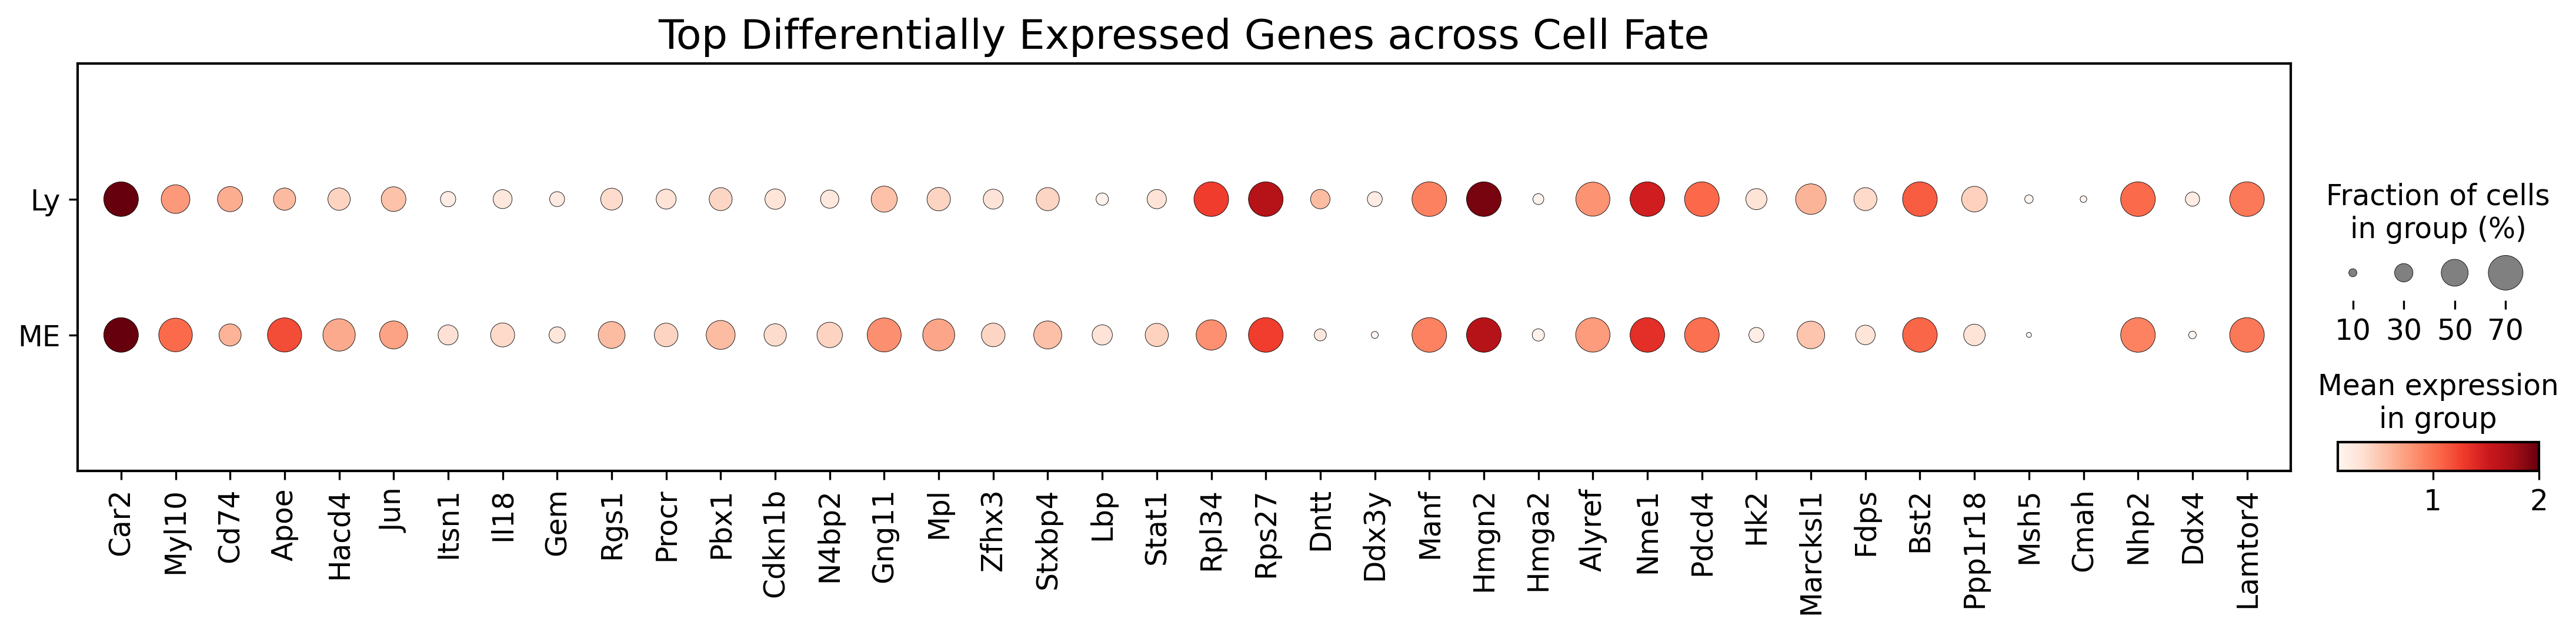

In [65]:

import anndata
# df_expression_all['diff'] = df_expression_all[labels[0]] - df_expression_all[labels[1]]
adata_raw = anndata.AnnData(X=adata2.raw.X, var=adata2.raw.var, obs=adata2.obs)
top_genes =  top_genes_bias[::-1].index

sc.pl.dotplot(adata_raw[adata_raw.obs['fate_pred']!='-'], 
              var_names=top_genes, 
              groupby='fate_pred', 
              figsize=(18, 3), 
              dot_max=0.7, 
              color_map='Reds',
              title="Top Differentially Expressed Genes across Cell Fate",
              vmin=0.1,
              vmax=2,
              save='pei_dotplot_top20.pdf')


In [ ]:
import tqdm
from scanpy.neighbors import _compute_connectivities_umap

weinreb_adata_to_plot=adata2[adata2.obs['cell_type']=='HSC'].copy()
weinreb_adata_mon =  weinreb_adata_to_plot[
        (np.array(weinreb_adata_to_plot.obs['cell_type'] == 'ME') | 
    np.array(weinreb_adata_to_plot.obs['fate_pred'] == 'ME') ) 
    #np.array(biddy_adata.obs['leiden'] != '9')  & np.array(biddy_adata.obs['leiden'] != '13')     
]

nn = NearestNeighbors(n_neighbors=20)
nn.fit(weinreb_adata_mon.obsm["geneEnc"][:,0,:])
D,I=nn.kneighbors(weinreb_adata_mon.obsm["geneEnc"][:,0,:])
# weinreb_adata_to_plot.uns['dE']
from scipy import spatial
II,DD=[],[]
pbar = tqdm.tqdm(total=len(weinreb_adata_mon))
idE = dE[(np.array(weinreb_adata_to_plot.obs['cell_type'] == 'ME') | 
    np.array(weinreb_adata_to_plot.obs['fate_pred'] == 'ME') ) ]

for i,d in zip(I,D):
    index = list(map(lambda x: spatial.distance.cosine(x-weinreb_adata_mon.obsm["X_umap"][i[0]], idE[i[0]] ) > 0, weinreb_adata_mon.obsm["X_umap"][i[1:]]))
    II.append(i[1:][index][:3])
    DD.append(d[1:][index][:3])
    pbar.update(1)
II,DD=np.vstack(II),np.vstack(DD)
import warnings
from scipy.sparse import coo_matrix
II,DD=np.vstack(II),np.vstack(DD)
Dc,Cc=_compute_connectivities_umap(II,DD,weinreb_adata_mon.shape[0],3)
Dc,Cc=_compute_connectivities_umap(I,D,weinreb_adata_mon.shape[0],3)
weinreb_adata_mon.obsp['connectivities']=Cc
weinreb_adata_mon.obsp['distances']=Dc

undiff_cells = weinreb_adata_mon[weinreb_adata_mon.obs['cell_type'] == 'HSC']
min_x_index = np.argmax(undiff_cells.obsm["X_umap"][:, 0])
root_cell_index = undiff_cells.obs.index[min_x_index]
weinreb_adata_mon.uns['iroot'] = np.where(weinreb_adata_mon.obs.index == root_cell_index)[0][0]



sc.tl.diffmap(weinreb_adata_mon)
sc.tl.dpt(weinreb_adata_mon)


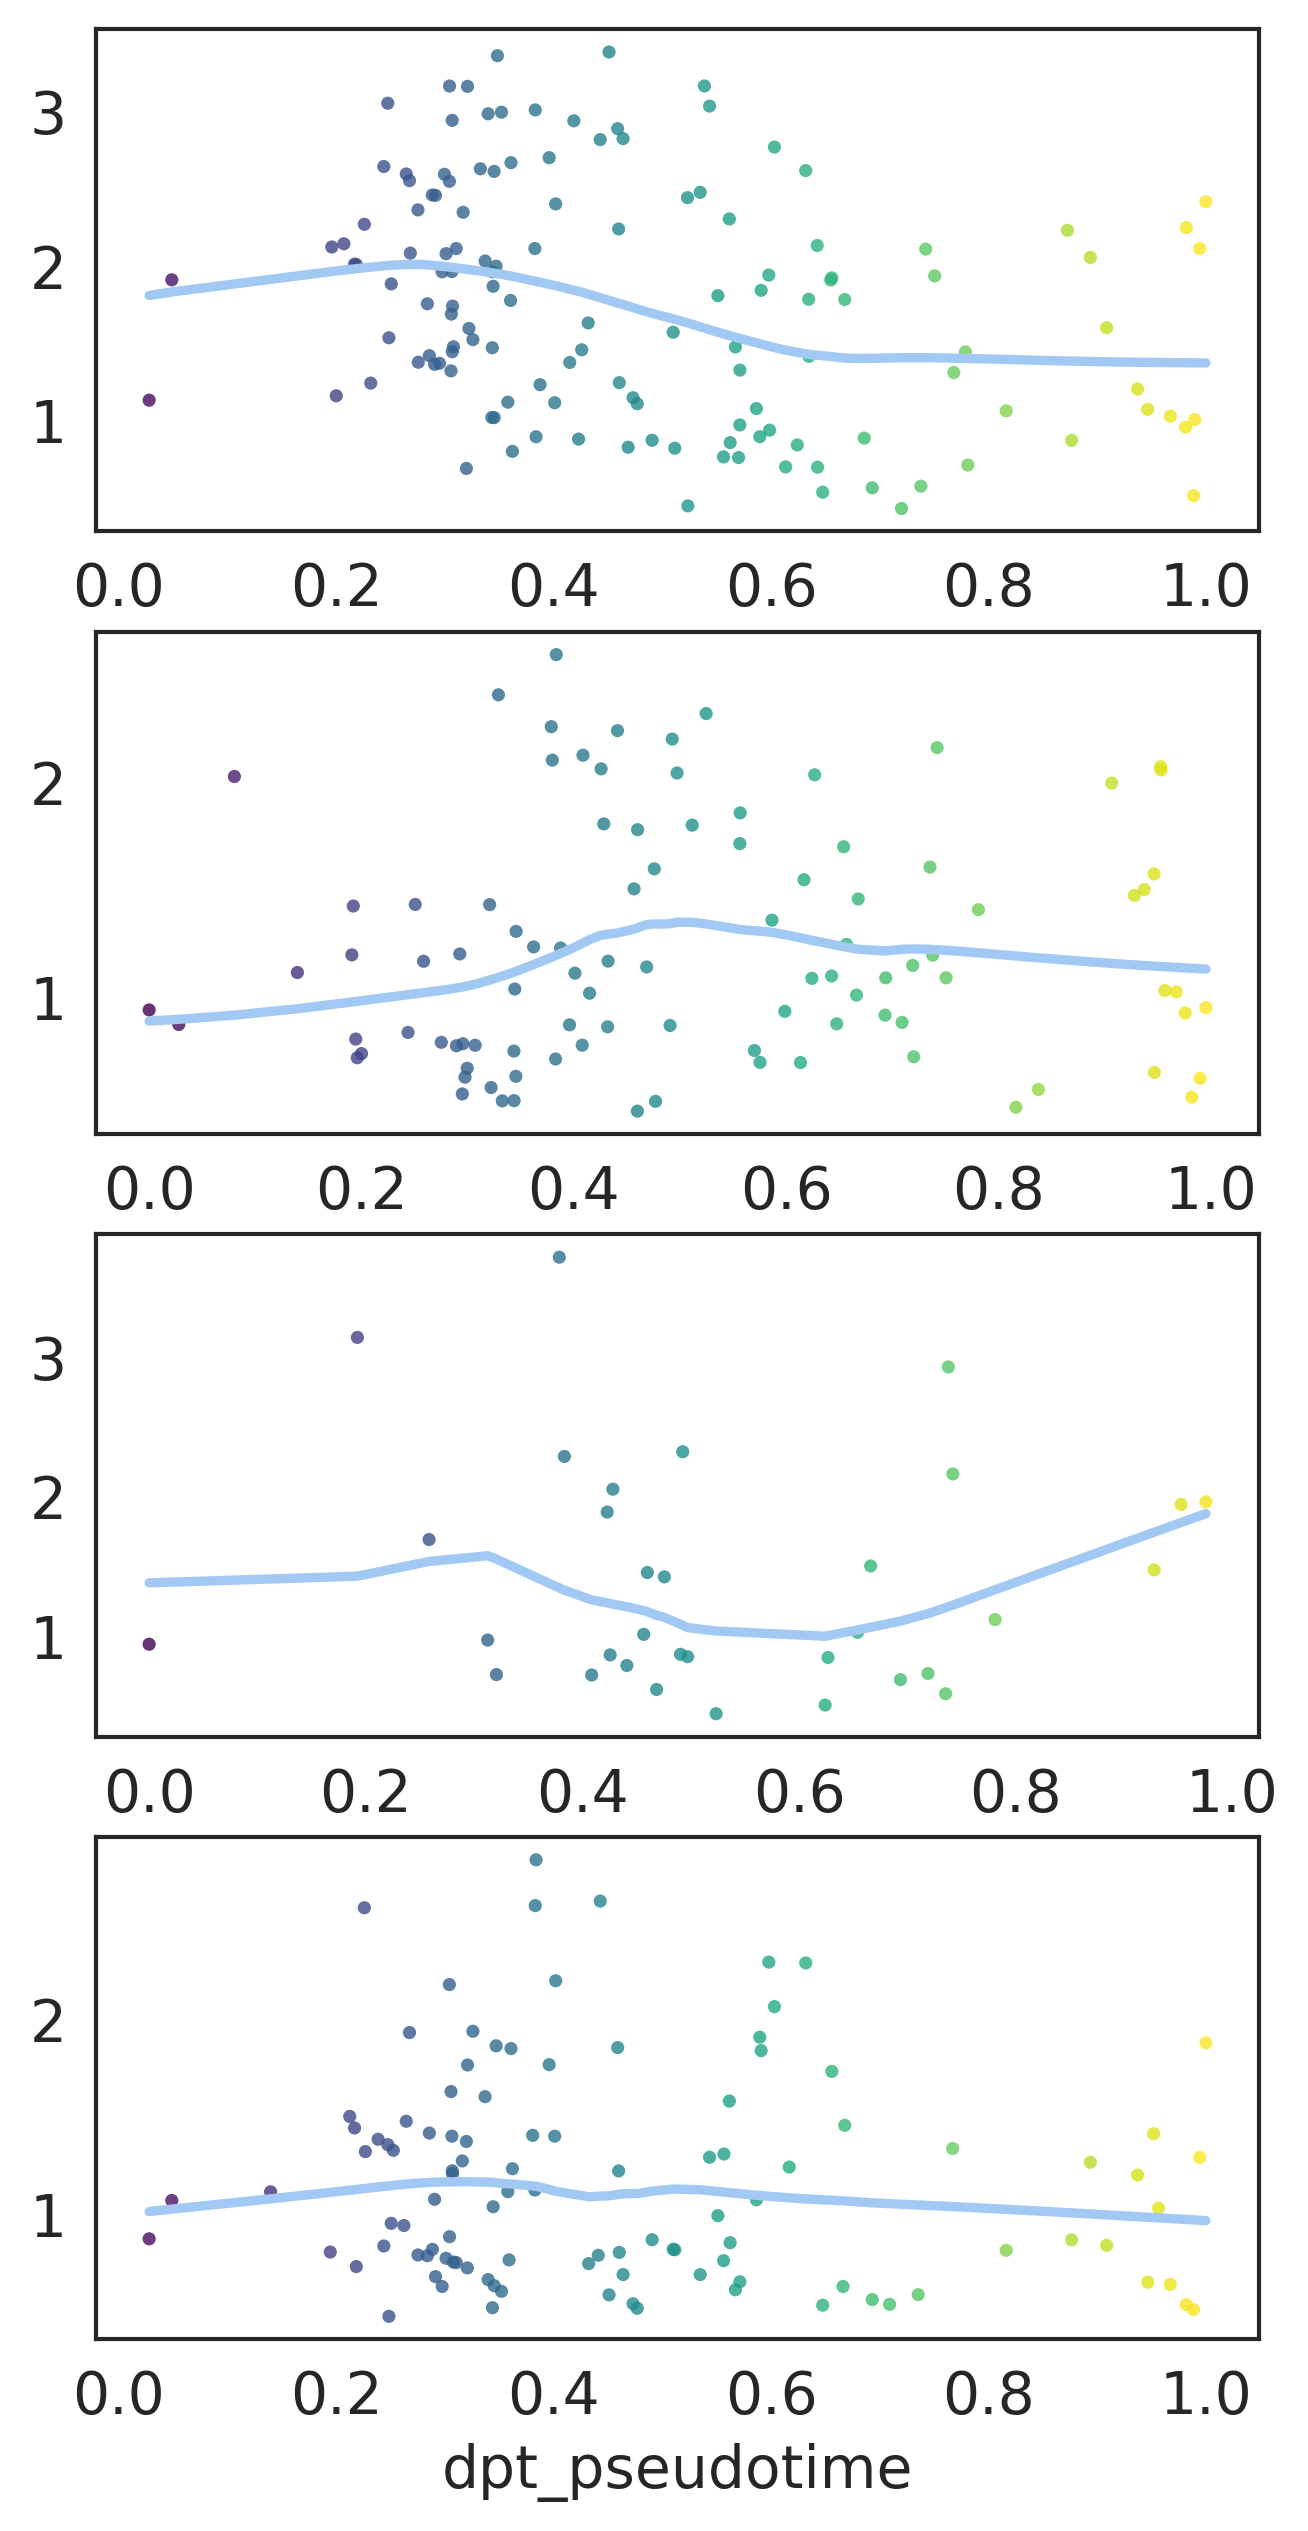

In [532]:
fig, axes = plt.subplots(4, 1)
fig.set_size_inches(5, 10)
for i, ax in zip(['Apoe', 'Flt3', 'Dntt','Mllt3'], axes):
    varindex = list(weinreb_adata_mon.var.index).index(i)
    indices = weinreb_adata_mon[:, varindex].X.toarray().ravel() != 0
    sns.regplot(
        x=weinreb_adata_mon.obs.loc[indices, 'dpt_pseudotime'],
        y=weinreb_adata_mon[indices].X.toarray()[:, varindex].ravel(),
        scatter_kws={
            's': 10,
            'linewidth': 0,
            'color': list(map(lambda x: plt.cm.viridis(x), weinreb_adata_mon.obs.loc[indices, 'dpt_pseudotime']))
        },
        lowess=True,
        ax=ax
    )


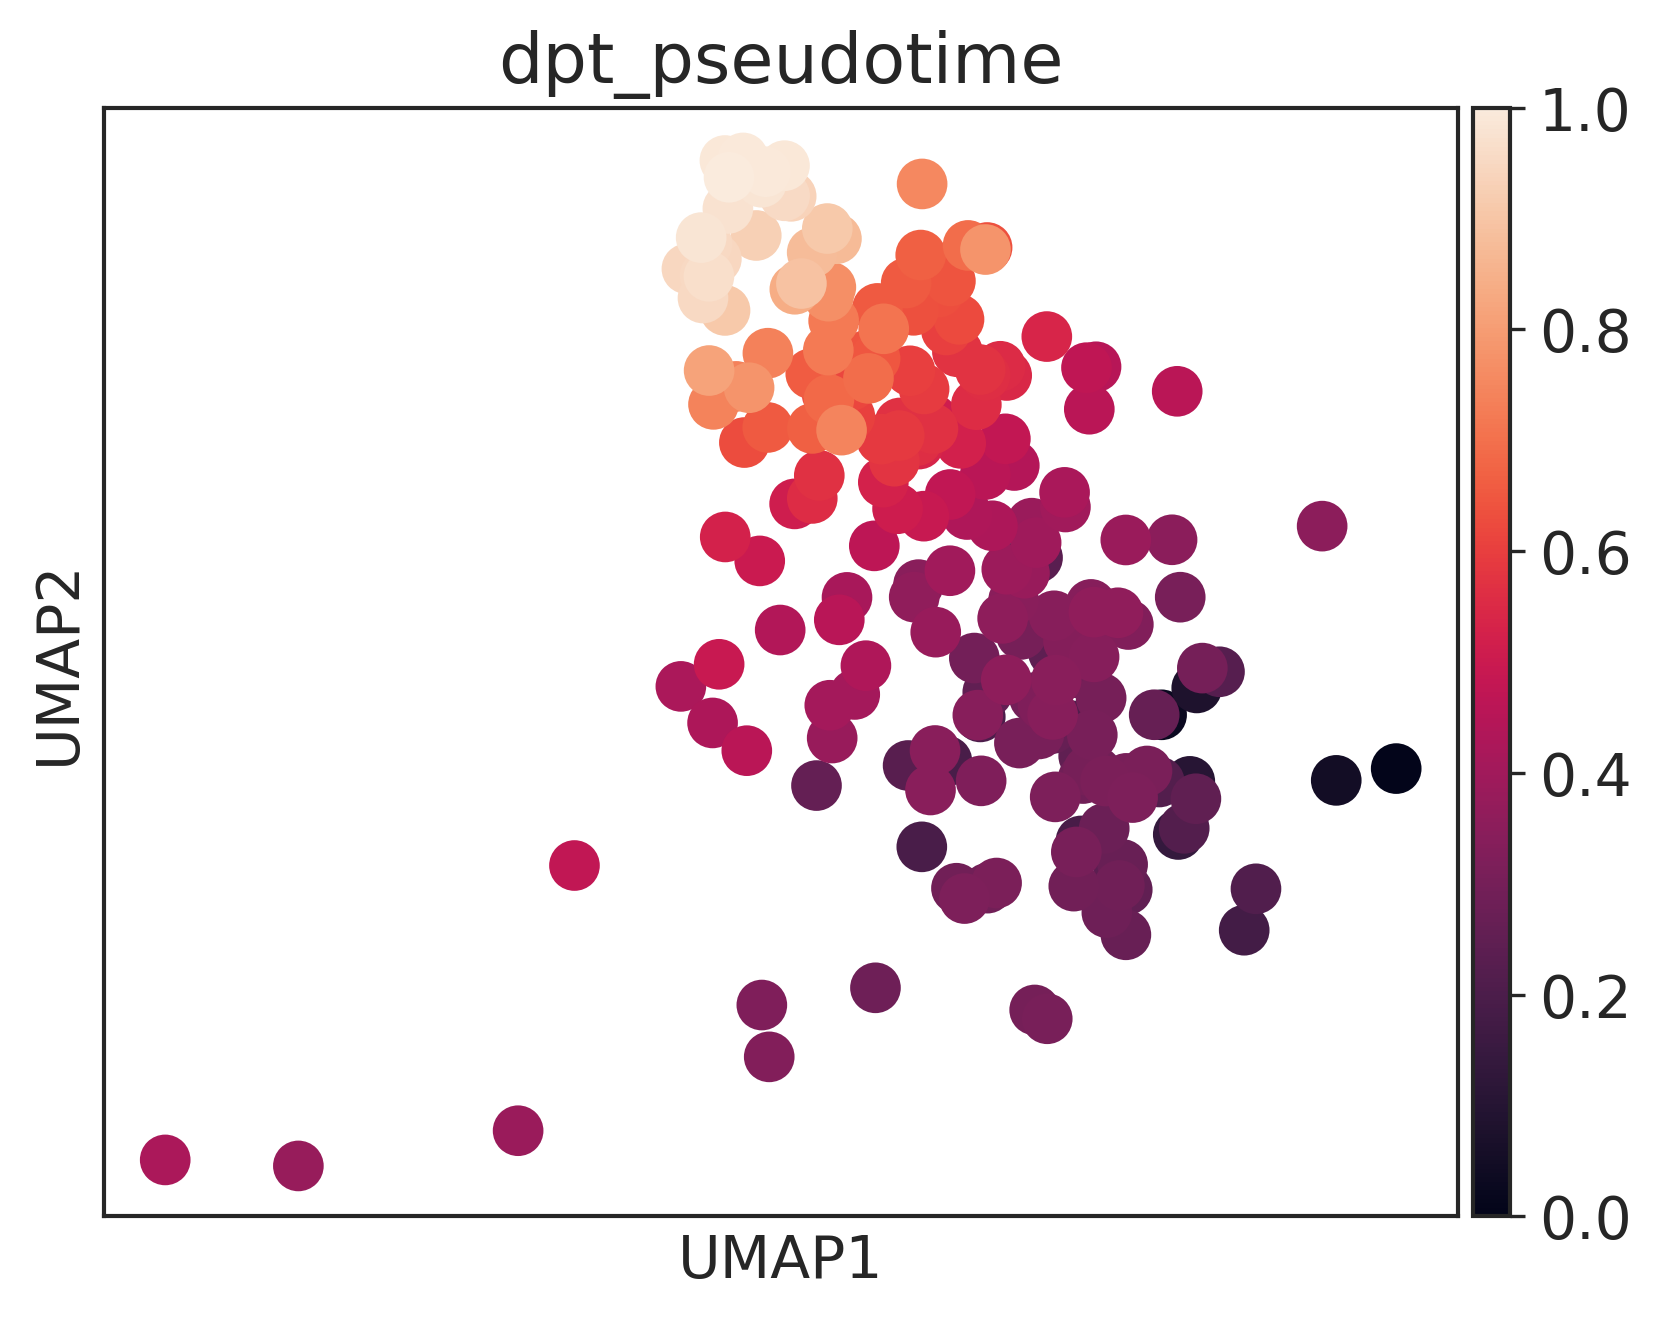


100%|████████████████████████████████████████| 203/203 [00:13<00:00, 689.75it/s]

In [533]:
sc.pl.umap(weinreb_adata_mon,color='dpt_pseudotime')

/home/zhengtuo/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  def _inplace_subset_var(self, index: Index1D):
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


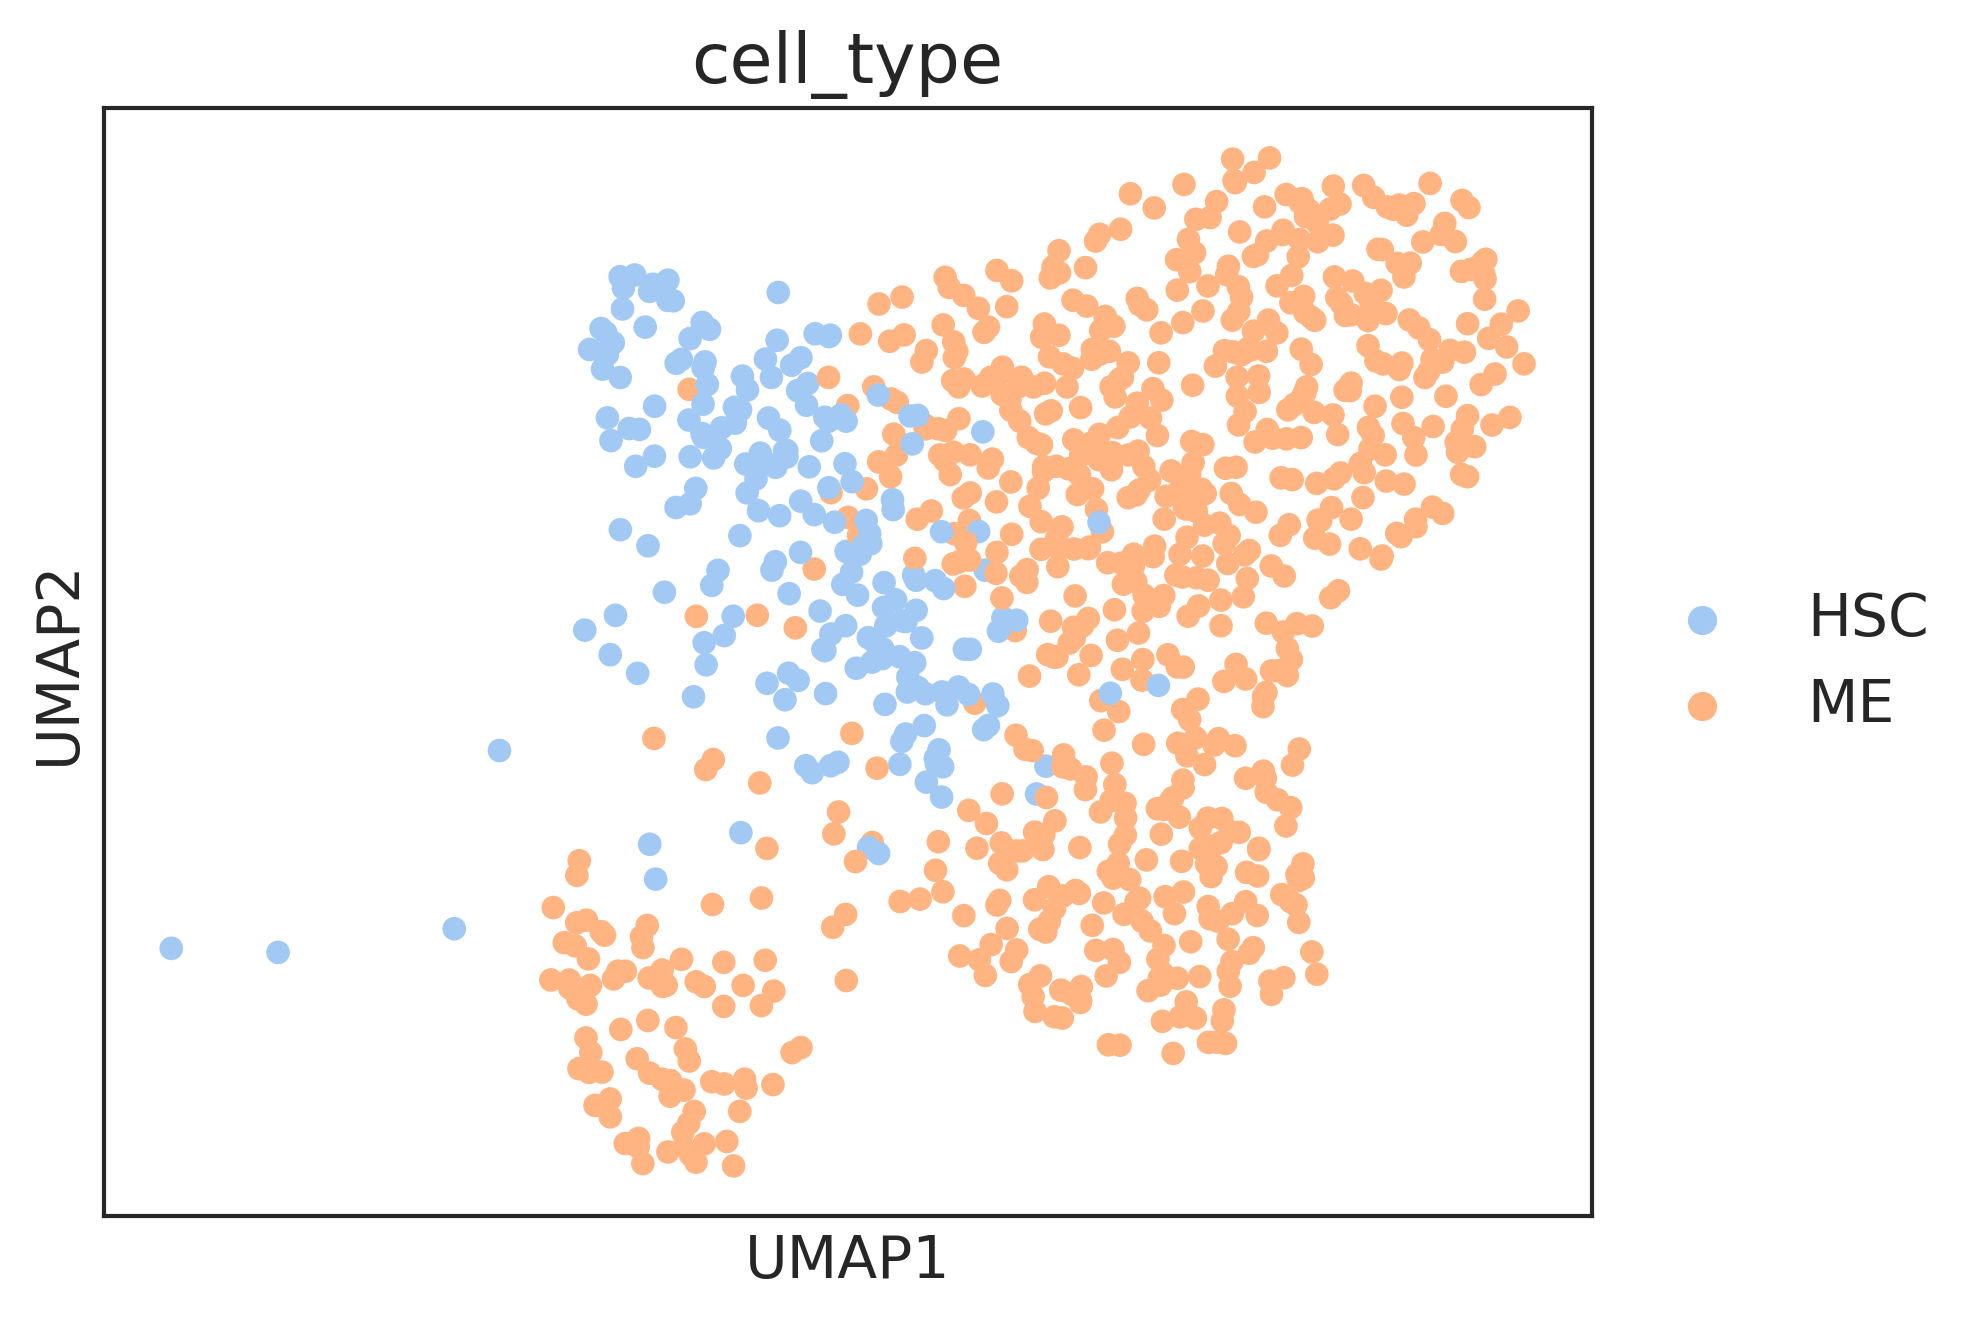

In [530]:
sc.pl.umap(adata2[
        (np.array(adata2.obs['cell_type'] == 'ME') | 
    np.array(adata2.obs['fate_pred'] == 'ME') )] ,color='cell_type')

In [580]:
traincell1=np.loadtxt('/home/zhengtuo/songtao/3traincell1.txt')
traincell2=np.loadtxt('/home/zhengtuo/songtao/3traincell2.txt')
testcell1=np.loadtxt('/home/zhengtuo/songtao/3testcell1.txt')
testcell2=np.loadtxt('/home/zhengtuo/songtao/3testcell2.txt')
train_rel=np.loadtxt('/home/zhengtuo/songtao/3trainrel.txt',dtype=int)
test_rel=np.loadtxt('/home/zhengtuo/songtao/3testrel.txt',dtype=int)
dic_train={}
dic_test={}
for i in train_rel:  
    dic_train[i] = dic_train.get(i, 0) + 1
print(dic_train)
for i in test_rel:  
    dic_test[i] = dic_test.get(i, 0) + 1
print(dic_test)

{0: 48210, 1: 31180, 2: 8975}
{0: 15240, 1: 3000, 2: 2950}


In [280]:
adata=cs.hf.read("/home/zhengtuo/songtao/1523_filter_pei.h5ad")
adata.obs['index']=range(adata.shape[0])

In [581]:
dic_true={}
for i in range((adata.shape[0])):
    if(adata.obs['HSC_preference'][i]=='Ly'):
        dic_true[adata.obs['index'][i]]=1
    else:
        dic_true[adata.obs['index'][i]]=0


In [582]:
#all_cell1=[]
# all_cell2=[]
all_cell1=list(set(list(traincell1)+list(testcell1)))
all_cell2=list(set(list(traincell2)+list(testcell2)))

from torch.utils.data import Dataset, DataLoader
class UndiffDataset(Dataset):
    def __init__(self,length):
        self.length=length

    def __getitem__(self, idx):
        i=int(list((all_cell1))[idx])
        gene=adata.X[i].toarray()
        gene=torch.tensor(gene)
        true_fate=dic_true[i]
        #genetype=dic1[genetype]
        true_fate=torch.tensor(true_fate)
        return gene,true_fate

    def __len__(self):
        return self.length
class otherDataset(Dataset):
    def __init__(self,length):
        self.length=length

    def __getitem__(self, idx):
        i=int(list((all_cell2))[idx])
        gene=adata.X[i].toarray()
        gene=torch.tensor(gene)
        genetype=adata.obs['cell_type'][i]
        genetype=dic[genetype]
        genetype=torch.tensor(genetype)
        return gene,genetype

    def __len__(self):
        return self.length
def dup_rows(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)


unidffdataset = UndiffDataset(len(all_cell1))
otherdataset=otherDataset(len(all_cell2))
Undiffdataloader = DataLoader(unidffdataset, batch_size=len((all_cell1)), num_workers=2, shuffle=False, drop_last=False)
otherdataloader=DataLoader(otherdataset, batch_size=1, num_workers=4, shuffle=False, drop_last=False)

In [584]:
true=0
dic={'HSC':3,'My':0,'Ery':0,'Ly':1}
cudaid = 'cuda:1'
# dic={'Monocyte':0, 'Neutrophil':1, 'Lymphoid':2,'Mast':3, 'Ccr7_DC':4,
#        'Baso':5, 'Eos':6}
device2 = torch.device(cudaid)
geneEnc.to(device2)
model.to(device2)
for i, onebatch1 in enumerate(Undiffdataloader):
    print(1)
    cell1=onebatch1[0].to(device2)
    cell1=geneEnc(cell1)
    hang=cell1.shape[0]
    #cell1=torch.reshape(cell1,(hang,256))
    true_labels=onebatch1[1]
    #print(cell1)
    #print(true_labels)
    pre=torch.zeros(hang)
    pre_labels=torch.zeros((hang,3))
    print(i)
    for j, onebatch2 in enumerate(otherdataloader):
        print(j)
        cell2=onebatch2[0].to(device2)
        cell2=geneEnc(cell2)
        cell2=dup_rows(cell2.cpu().detach().numpy(), indx=0,num_dups=hang-1)
        cell2=torch.tensor(cell2).to(device2)
        genetype=onebatch2[1]
        geneEmbs = torch.cat((cell1, cell2), 2)
        outputs = model(geneEmbs)
        outputs=torch.reshape(outputs,(hang,3))
        #print(outputs)
        outputs=outputs.argmax(-1)
        #print(outputs)
        for num in range(hang):
            if(int(outputs[num])!=2):
                pre_labels[num][int(outputs[num])]+=1
        del outputs,cell2,genetype,geneEmbs
        torch.cuda.empty_cache()
    matrix1=pre_labels
    #print(pre_labels)
    #print(pre_labels)
    pre_labels=np.argsort(-pre_labels)
    #print(pre_labels)
    pre_labels=pre_labels.T[0]
    #print(pre_labels)
    true+=np.count_nonzero(pre_labels==true_labels)
    #np.savetxt('/home/songtao/matrix.txt',matrix1)
    del cell1
    torch.cuda.empty_cache()
     


In [690]:
pei_adata

AnnData object with n_obs × n_vars = 1366 × 1427
    obs: 'sample_name', 'CI', 'max.barcode', 'type', 'leiden', 'cell_type', 'batch_name', 'fate_bias', 'HSC_preference', 'index', 'prob', 'fate_pred'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'HSC_preference_colors', 'batch_name_colors', 'cell_type_colors', 'fate_bias_colors', 'fate_pred_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'sample_name_colors', 'umap'
    obsm: 'X_emb', 'X_emb_old', 'X_pca', 'X_scanorama', 'X_umap', 'geneEnc', 'genemap'
    obsp: 'connectivities', 'distances'

In [693]:
sc.tl.pca(pei_adata)
sc.pp.neighbors(pei_adata)
sc.tl.umap(pei_adata)

/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


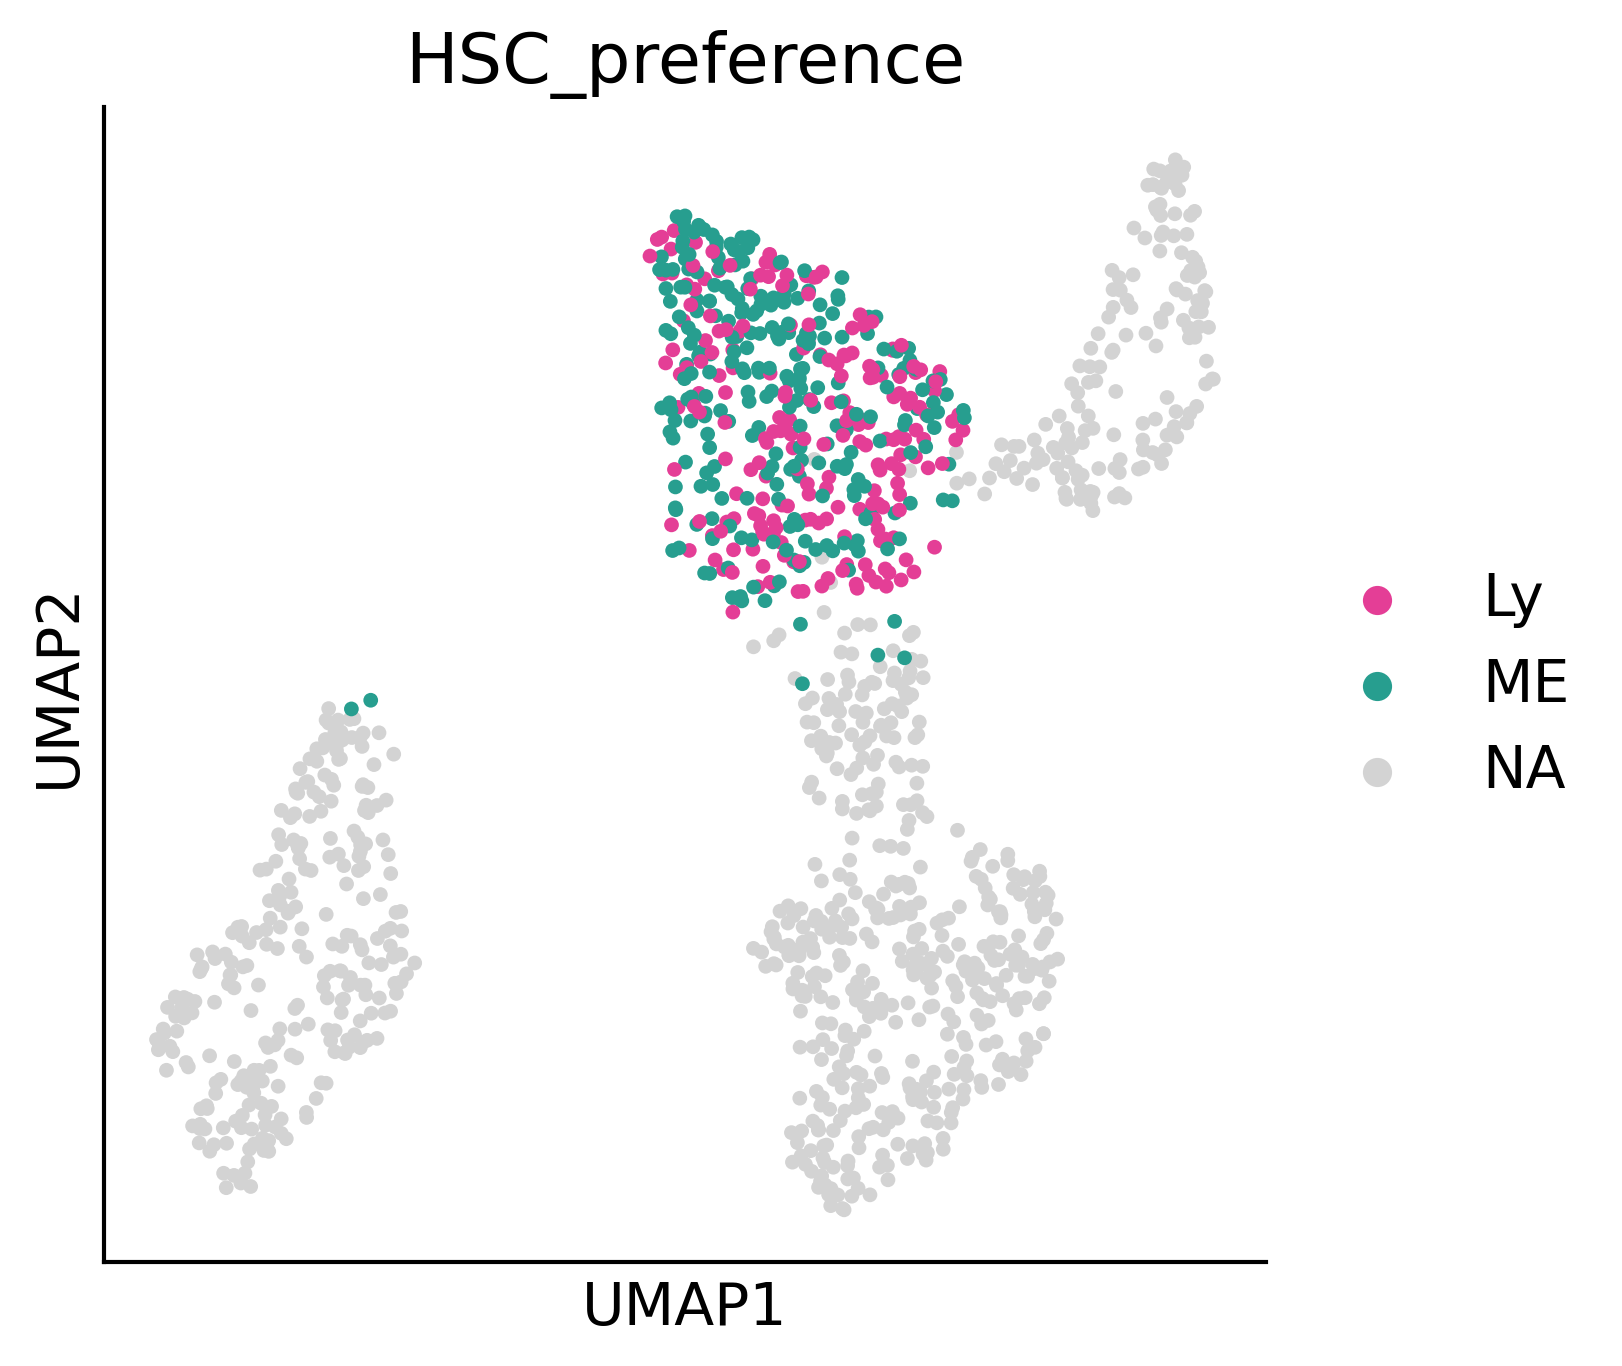

In [697]:
fig,ax=createFig((5,5))
sc.pl.umap(pei_adata, color='HSC_preference', palette={
 'Ery': '#2A9E27',
 'Lymphoid': '#E43E96',
 'Mast': '#B5BD61',
 'My': '#279E9E',
 'Mo': '#50C3C6',
 'Neu': '#FAA339',
 'ME': '#279E8F',
 'Ly': '#E43E96',
 'HSC': '#E6DCD9'
}, ax=ax, s=50)
fig.savefig('/home/zhengtuo/songtao/DestinyNet/pei_figure/pca_GT_0.043.pdf', dpi=300, bbox_inches='tight')


/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


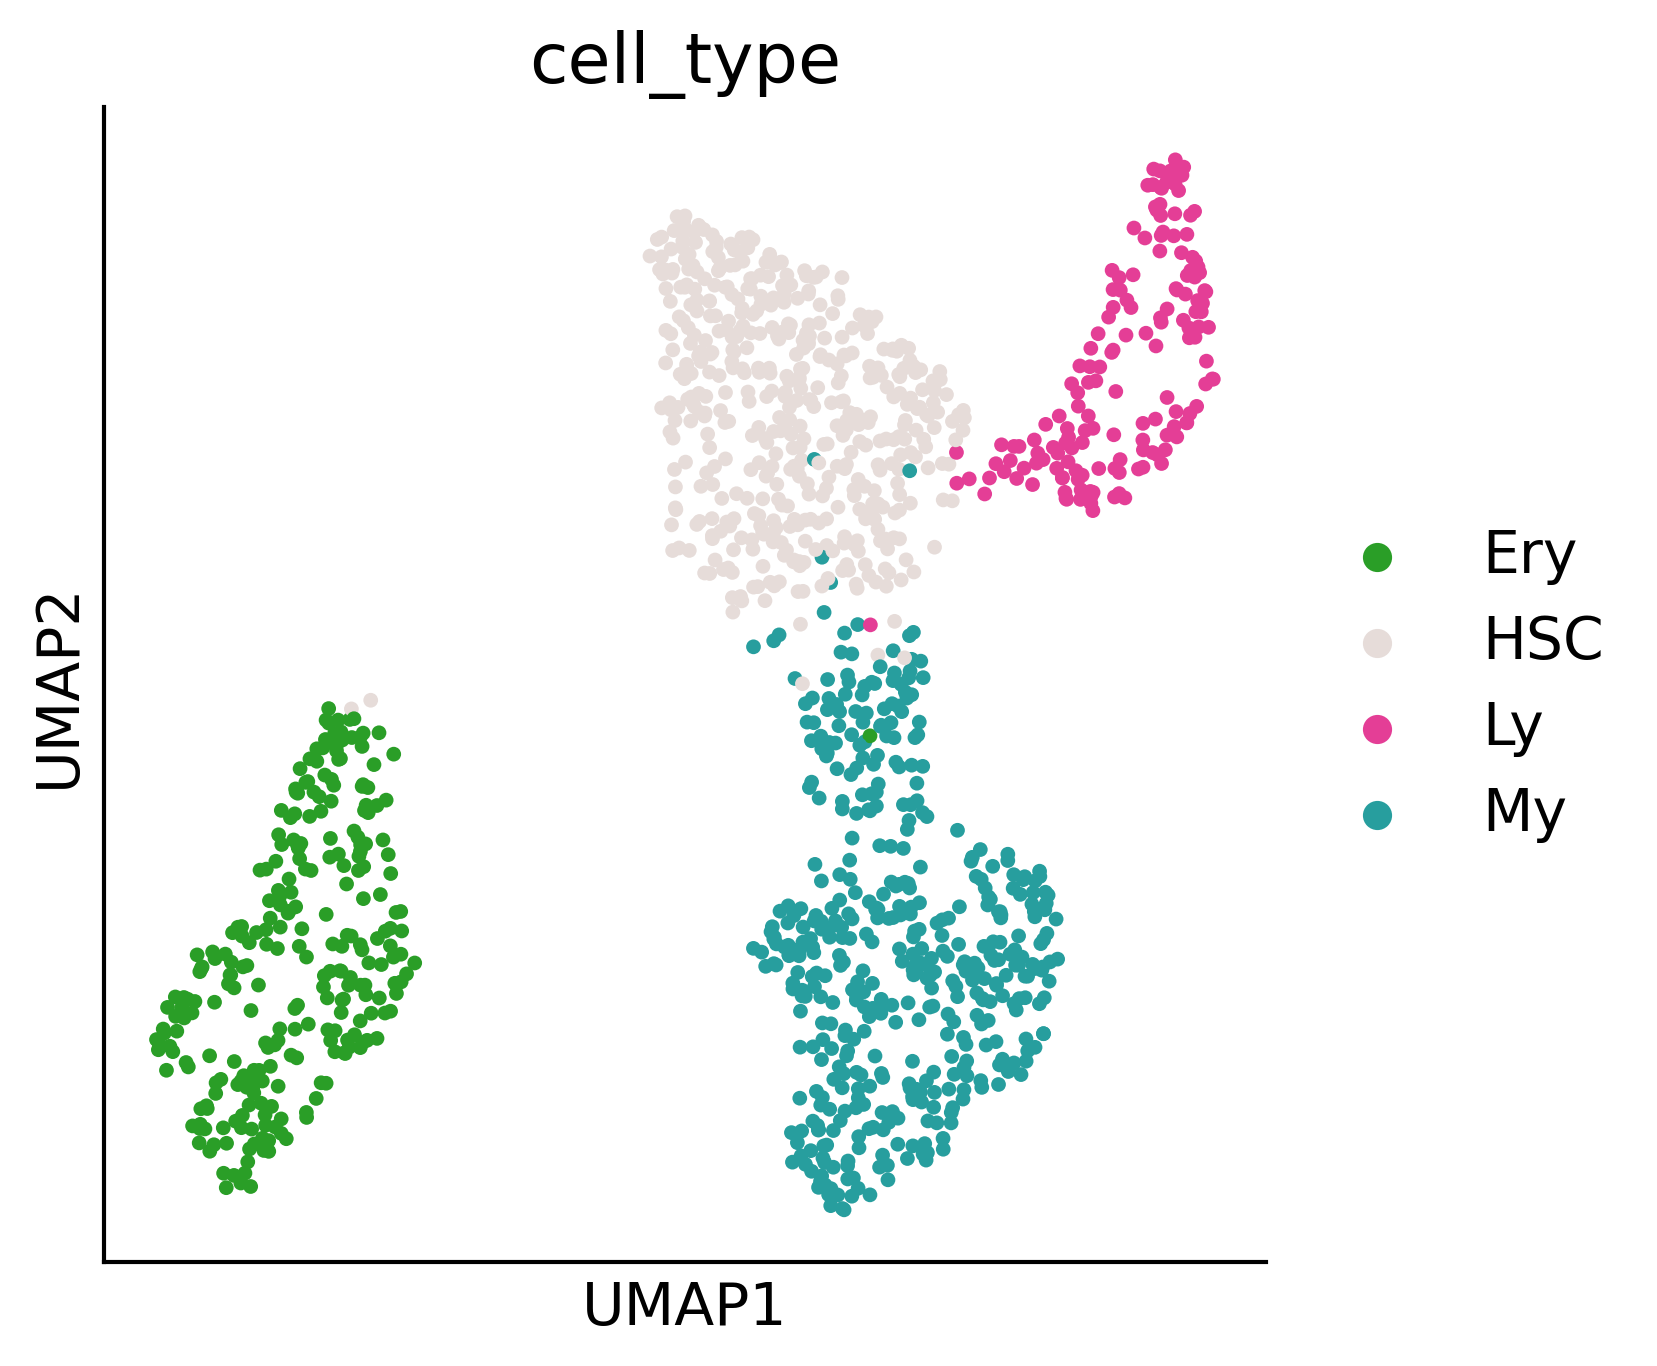

In [696]:
fig,ax=createFig((5,5))
sc.pl.umap(pei_adata, color='cell_type', palette={
 'Ery': '#2A9E27',
 'Lymphoid': '#E43E96',
 'Mast': '#B5BD61',
 'My': '#279E9E',
 'Mo': '#50C3C6',
 'Neu': '#FAA339',
 'ME': '#279E8F',
 'Ly': '#E43E96',
 'HSC': '#E6DCD9'
}, ax=ax, s=50)
fig.savefig('/home/zhengtuo/songtao/DestinyNet/pei_figure/pca_clustering.pdf', dpi=300, bbox_inches='tight')


In [403]:
import sklearn
sklearn.metrics.silhouette_score(
    pei_adata[pei_adata.obs['HSC_preference'].isin(['Ly','ME'])].obsm["X_umap"],
    pei_adata[pei_adata.obs['HSC_preference'].isin(['Ly','ME'])].obs['HSC_preference']
)

0.0431101

In [699]:
true/len(all_cell1)

0.0

In [296]:
pei_adata.obs['prob']=None
sum=0
for i in all_cell1:
    pei_adata.obs.loc[pei_adata.obs['index']==i, 'prob'] = float(matrix1[sum][1]/(matrix1[sum][1]+matrix1[sum][0]))
    sum+=1


In [585]:
from colour import Color
from matplotlib.colors import LinearSegmentedColormap
def make_colormap( colors, show_palette = False ): 
    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in colors ] )
    if show_palette:
        plt.figure( figsize = (15,3))
        plt.imshow( [list(np.arange(0, len( colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
        plt.xticks([])
        plt.yticks([])
    return color_ramp

In [589]:
pei_adata=adata2.copy()

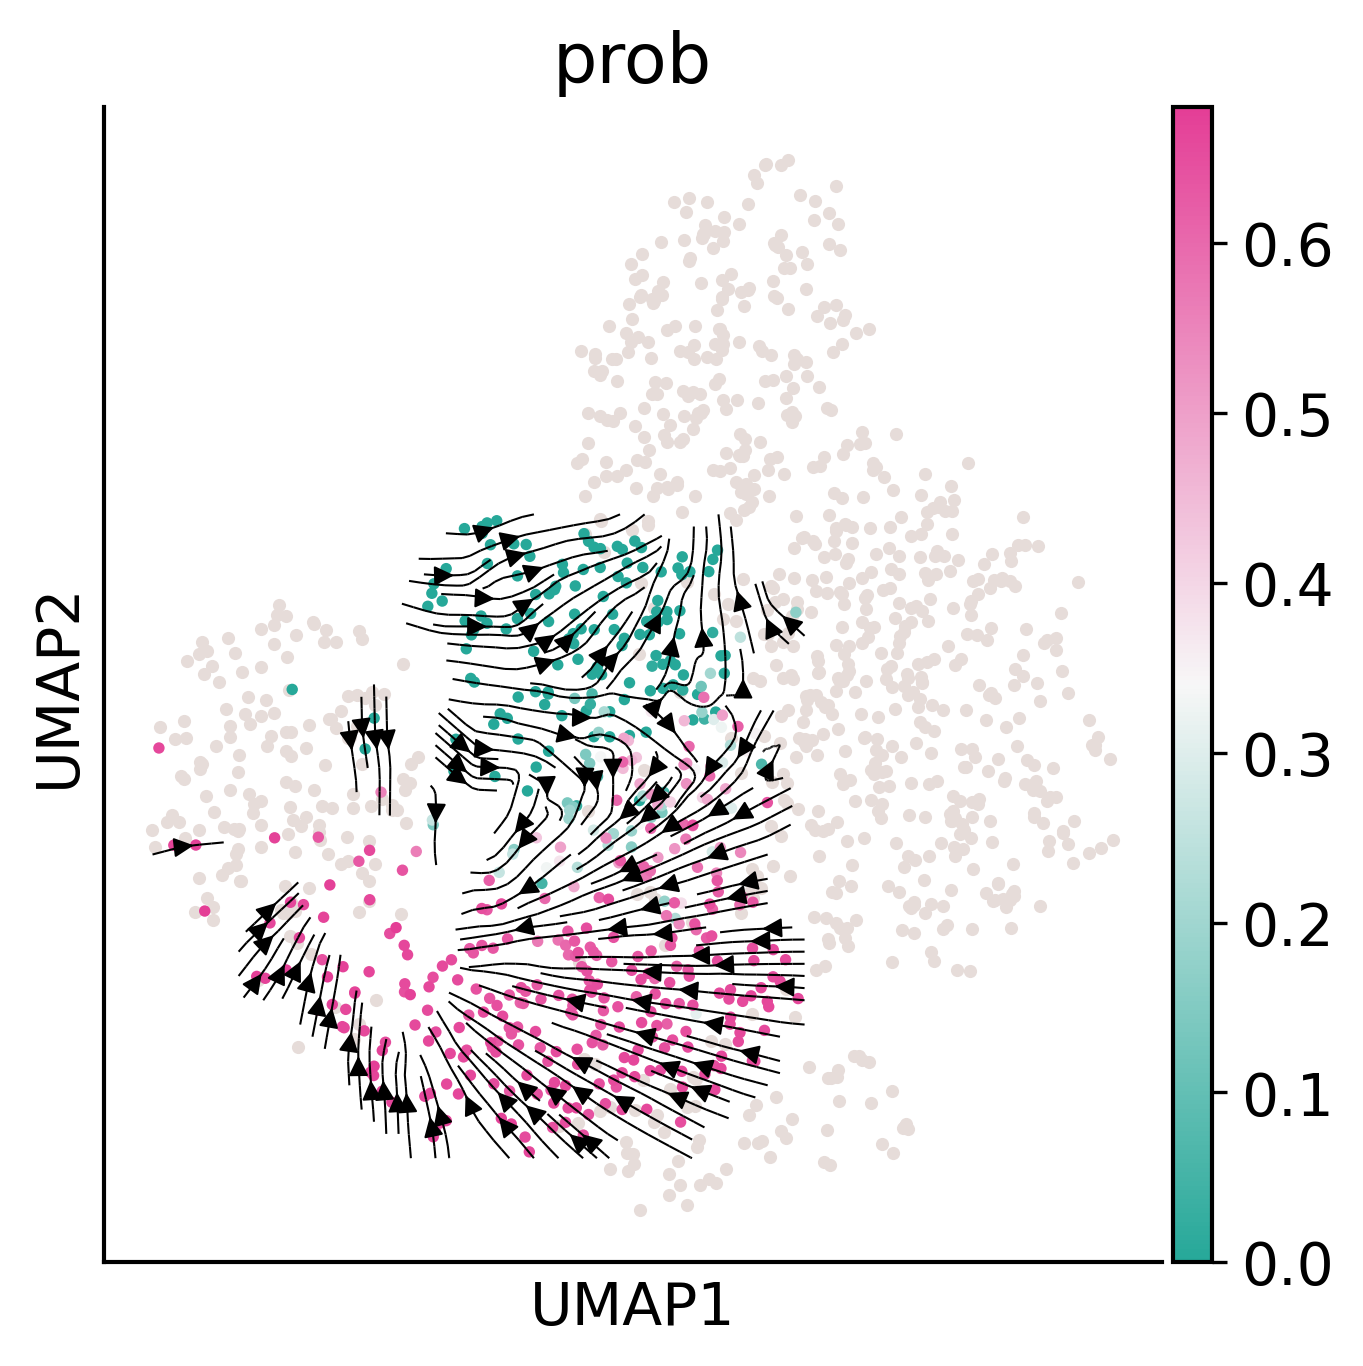

In [691]:
fig,ax=createFig()
fig.set_size_inches(5,5)
pei_adata.obs['prob'] =  list(map(lambda x: 0 if not x or x == 'None' else float(x), pei_adata.obs['prob']))
ax.scatter(
    pei_adata[list(map(lambda x: x != 'HSC', pei_adata.obs['cell_type']))].obsm["X_umap"][:,0],
    pei_adata[list(map(lambda x: x != 'HSC', pei_adata.obs['cell_type']))].obsm["X_umap"][:,1],
    s = 10, color='#E6DCD9', linewidth=0
)
sc.pl.umap(
    pei_adata[list(map(lambda x: x == 'HSC', pei_adata.obs['cell_type']))], 
    ax=ax, 
    color='prob', 
    s=30, 
    cmap=make_colormap(['#26A899','#F7F7F7','#E43E96']),
    show=False
)
ax.streamplot(gE[0],gE[1],gdE[0],gdE[1],**stream_kwargs)
ax.figure.savefig('/home/zhengtuo/songtao/DestinyNet/pei_figure/flow.pdf', bbox_inches='tight')  # 修改为您的目标路径


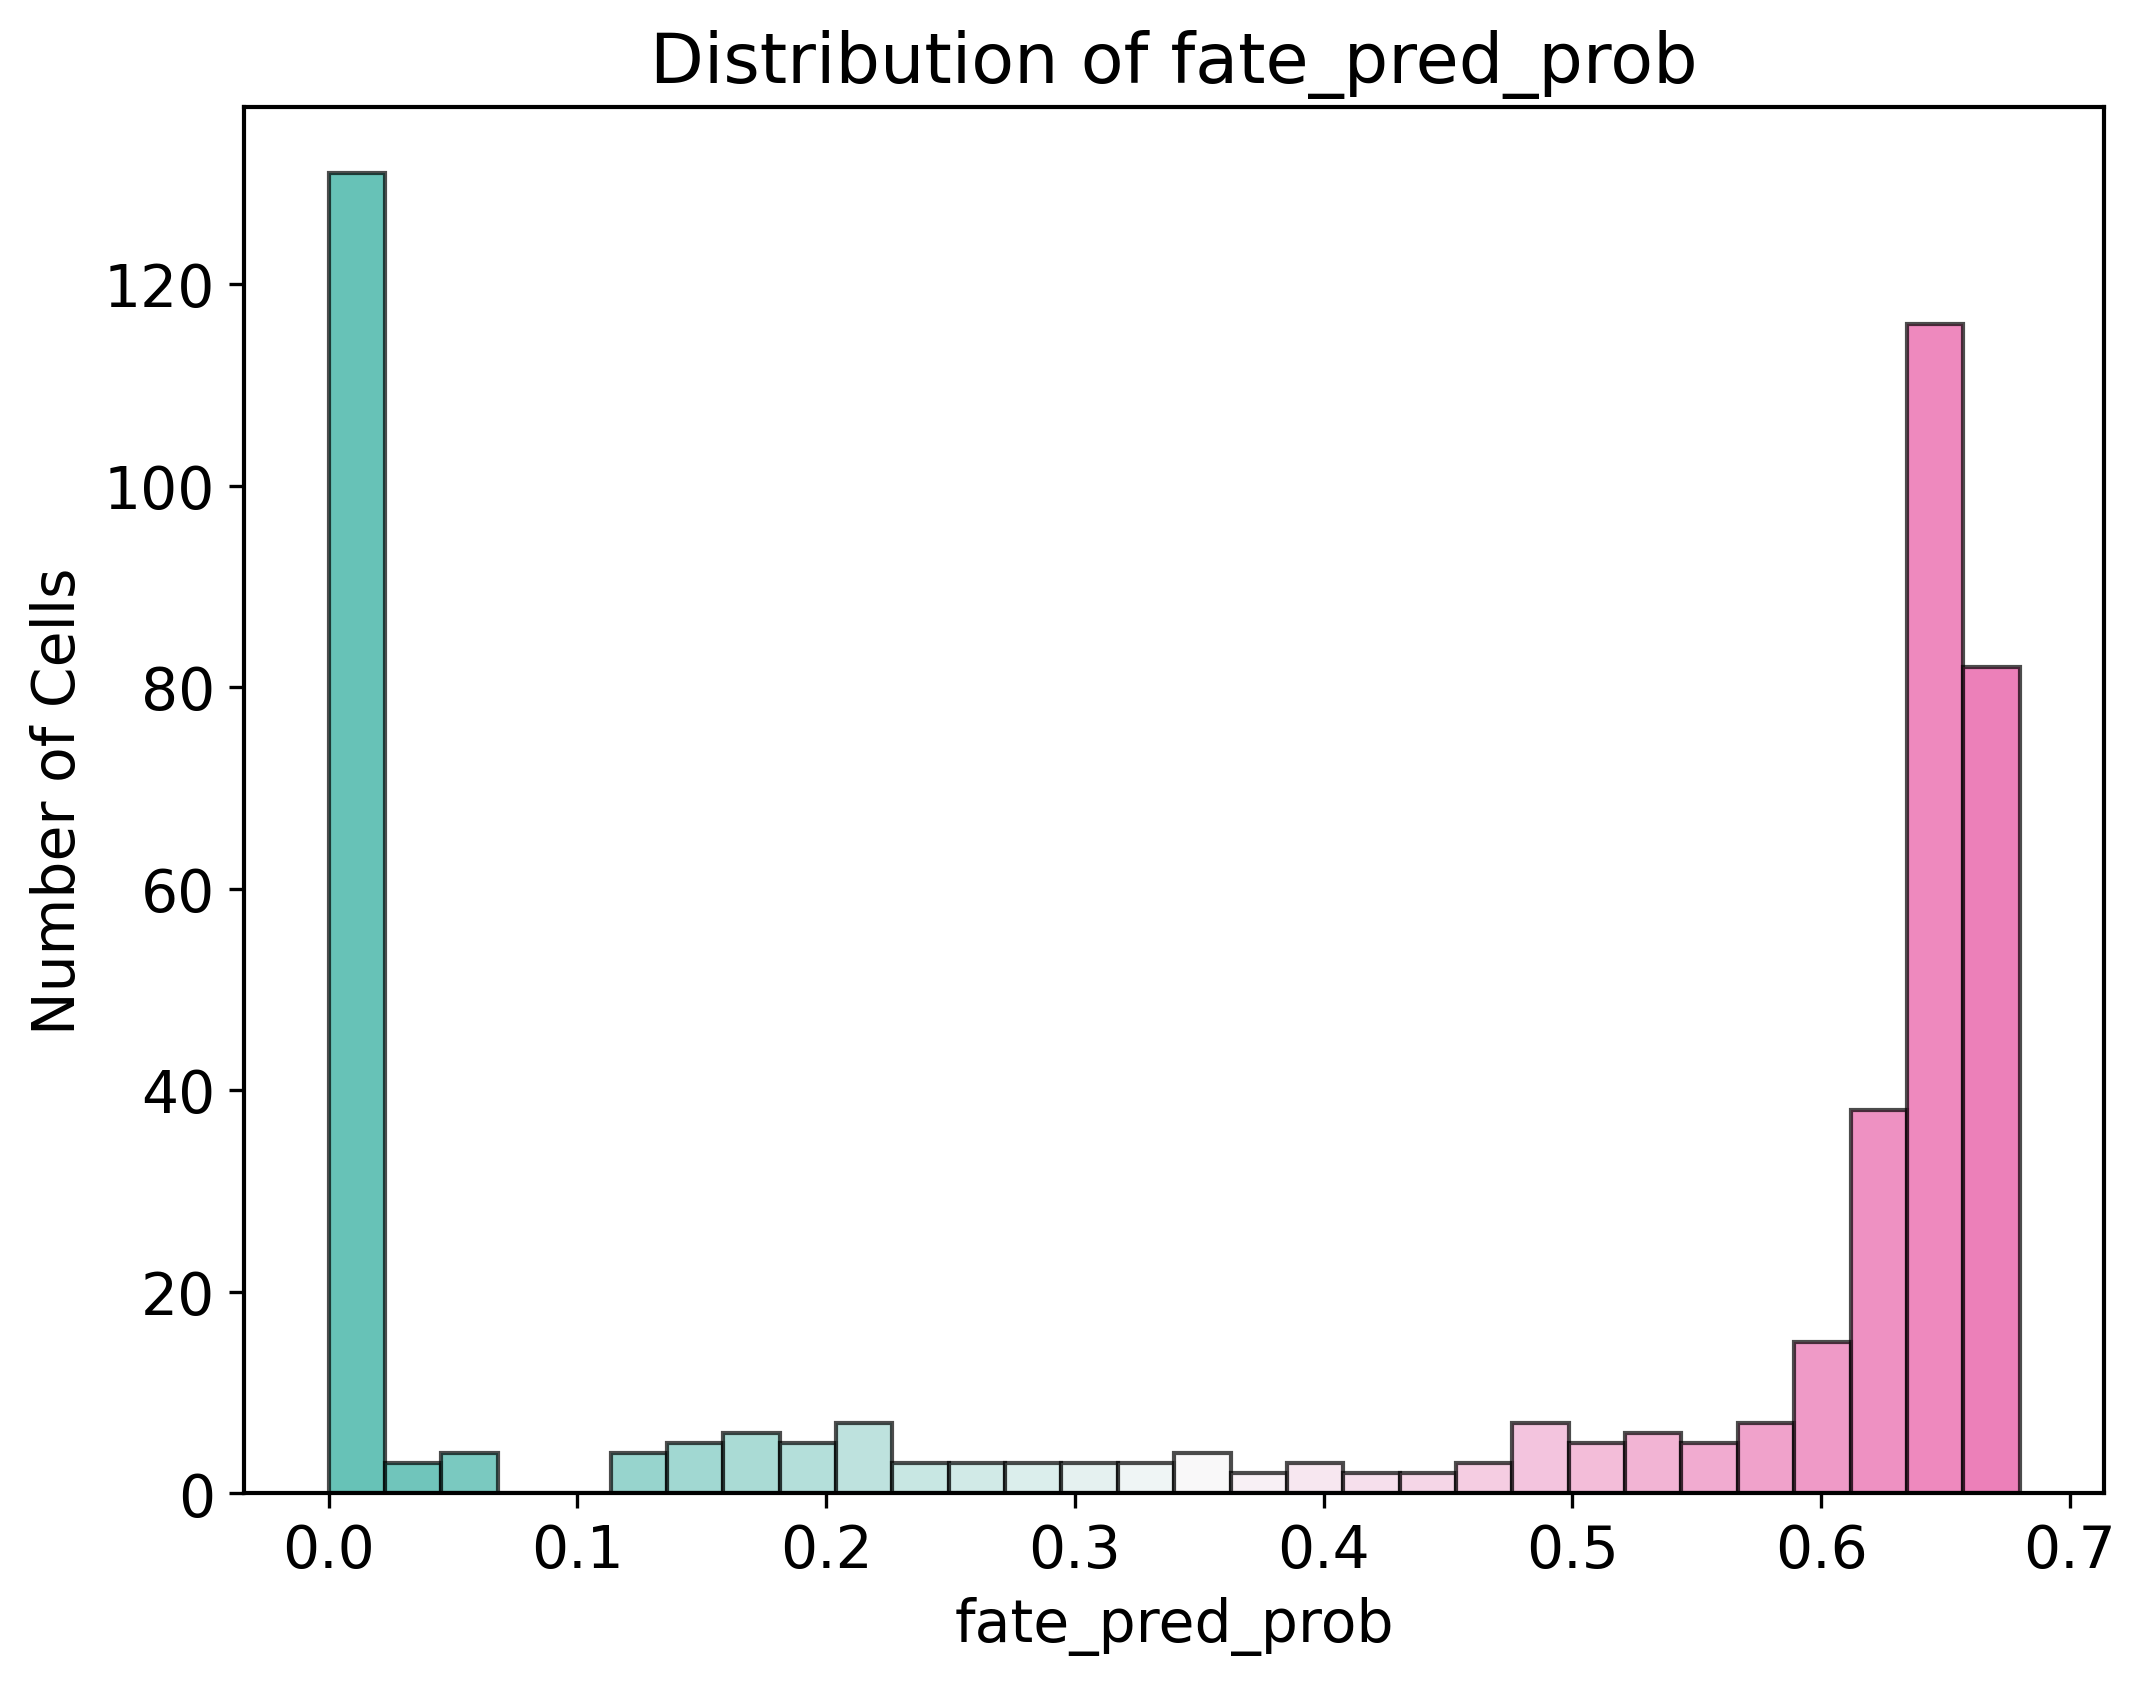

In [692]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

colormap=make_colormap(['#26A899','#F7F7F7','#E43E96'])
data = pei_adata[pei_adata.obs['cell_type']=='HSC'].obs['prob']

plt.figure(figsize=(8, 6))

n, bins, patches = plt.hist(data, bins=30, edgecolor='black', alpha=0.7)

norm = plt.Normalize(data.min(), data.max())

for thisbin, thispatch in zip(bins, patches):
    color = colormap(norm(thisbin))
    thispatch.set_facecolor(color)

plt.title("Distribution of fate_pred_prob")
plt.xlabel("fate_pred_prob")
plt.ylabel("Number of Cells")
plt.savefig("/home/zhengtuo/songtao/DestinyNet/pei_figure/hisgram_pei.pdf", bbox_inches='tight')

plt.show()


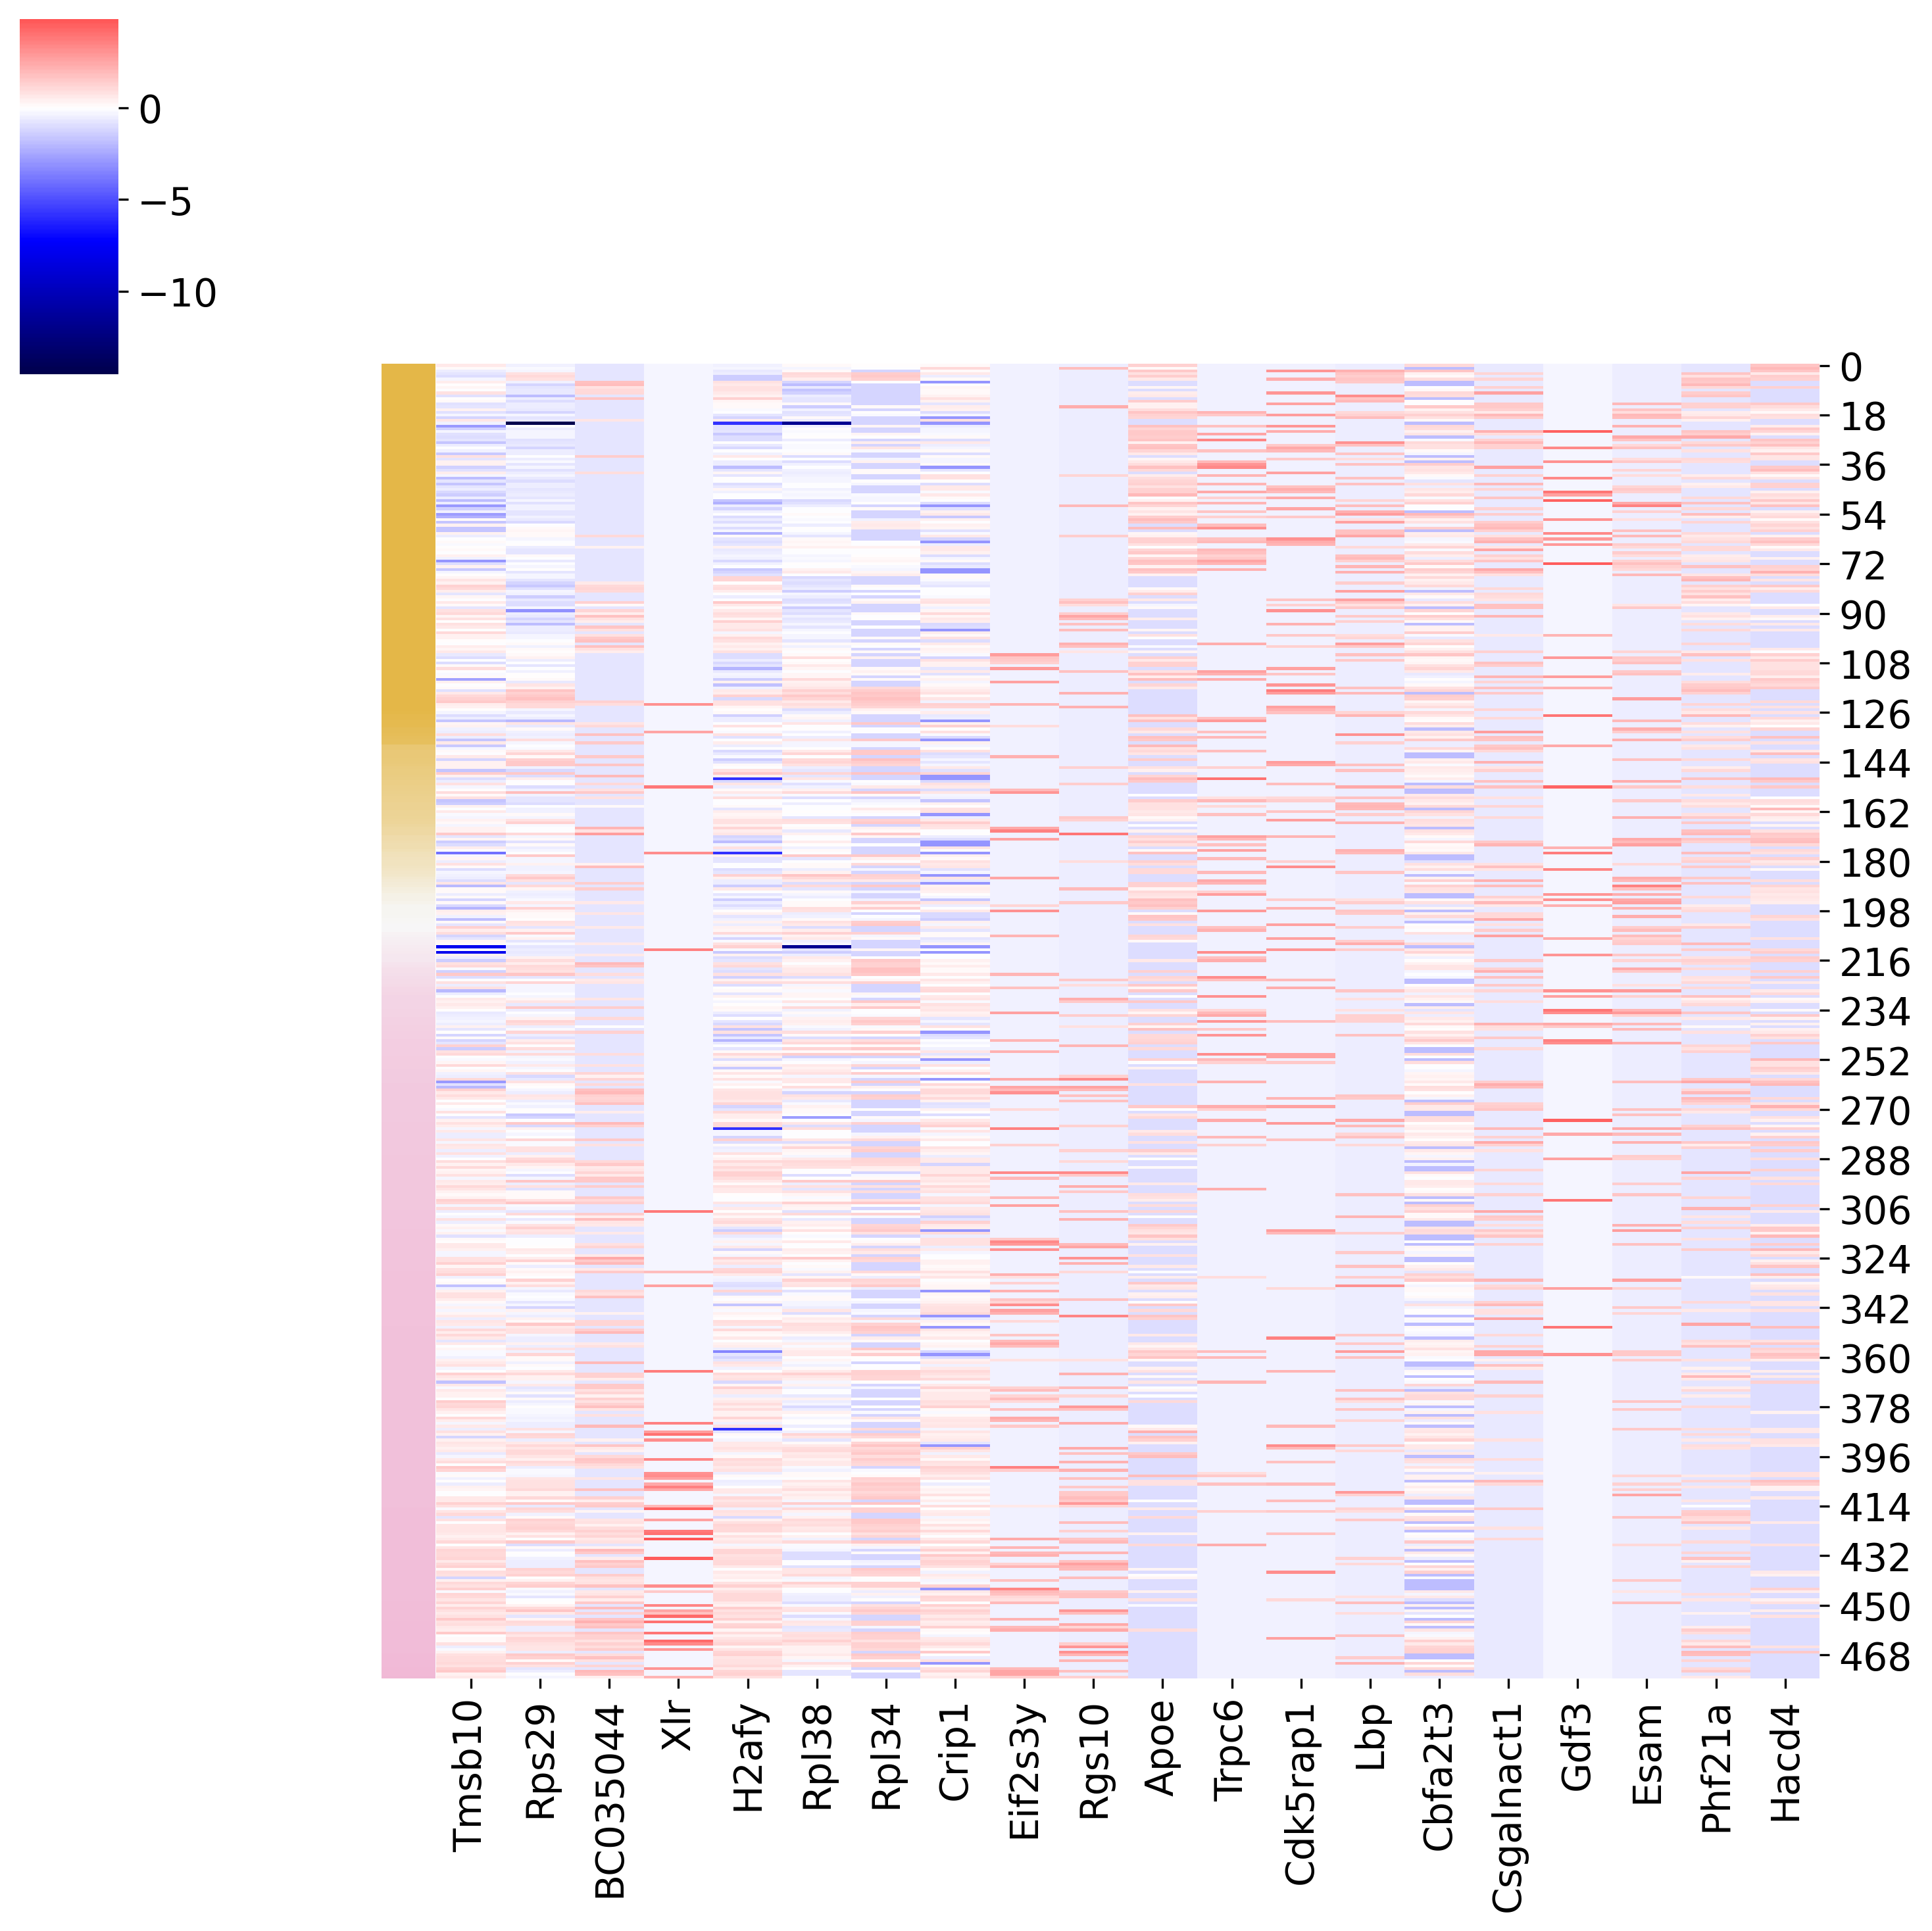

In [799]:
adata3=adata2[adata2.obs['prob']!='None']
x_indices = list(map(lambda x: x[0], sorted(enumerate(adata3.obs['prob']), key=lambda x: x[1])))
var_names = genes_index
y_indices = list(map(lambda x: list(adata3.var.index).index(x), var_names))

expr = adata3.X[x_indices,:,][:,y_indices].toarray()
expr = pd.DataFrame(expr, columns=var_names)
cmap = make_colormap(['#E4B748','#F7F7F7','#E5499B'])

fig=sns.clustermap(
    expr, 
    row_cluster=False, 
    col_cluster=False, 
    z_score=1, 
    
#     vmin=-2,
#     vmax=2,
    cmap='seismic', 
    #col_colors=['#E5499B'] * 10 + ['#E4B748'] * (len(var_names) - 10), 
    row_colors = list(map(lambda x: cmap(float(x) ), adata3.obs['prob'][x_indices])),
    center=0
)
#fig.savefig('/home/zhengtuo/songtao/DestinyNet/carlin_figure/heatmap.pdf')
# fig.savefig("/Users/snow/Downloads/20230914_LT_Pseudotime_Biddy_prob_gene_exp/heatmap.png")

In [793]:
pd.DataFrame(adata3_GT.uns['rank_genes_groups']['names']).head(10)

Ly          ME
0    Tmsb10        Apoe
1     Rps29       Trpc6
2  BC035044    Cdk5rap1
3       Xlr         Lbp
4     H2afy     Cbfa2t3
5     Rpl38  Csgalnact1
6     Rpl34        Gdf3
7     Crip1        Esam
8   Eif2s3y      Phf21a
9     Rgs10       Hacd4

In [786]:
'Tmod3' in adata3.var.index

False

In [795]:
import pandas as pd

genes_df = pd.DataFrame(adata3_GT.uns['rank_genes_groups']['names'])

GT_10_genes_group_0 = genes_df.iloc[:10, 0]
GT_10_genes_group_1 = genes_df.iloc[:10, 1]

GT_20_genes = GT_10_genes_group_0.append(GT_10_genes_group_1)

genes_index = pd.Index(GT_20_genes)


/tmp/ipykernel_111981/922251399.py:11: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  GT_20_genes = GT_10_genes_group_0.append(GT_10_genes_group_1)


In [798]:
genes_index

Index(['Tmsb10', 'Rps29', 'BC035044', 'Xlr', 'H2afy', 'Rpl38', 'Rpl34',
       'Crip1', 'Eif2s3y', 'Rgs10', 'Apoe', 'Trpc6', 'Cdk5rap1', 'Lbp',
       'Cbfa2t3', 'Csgalnact1', 'Gdf3', 'Esam', 'Phf21a', 'Hacd4'],
      dtype='object')

In [723]:

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def mask_expression_except_for_celltype(adata, gene_name, cell_type='HSC'):
    new_col_name = gene_name + "_masked"
    
    adata.obs[new_col_name] = np.nan
    
    expression_values = adata[adata.obs['cell_type'] == cell_type, gene_name].X.A[:, 0]
    
    adata.obs.loc[adata.obs['cell_type'] == cell_type, new_col_name] = expression_values
    
    return new_col_name

def create_umap_for_gene(adata, gene_name):
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    
    masked_gene_name = mask_expression_except_for_celltype(adata, gene_name)
    
    sc.pl.umap(
        adata, ax=ax,
        color=masked_gene_name,
        cmap='Reds',
        s=50,
        vmin=0
    )
    return fig


with PdfPages('/home/zhengtuo/songtao/DestinyNet/pei_figure/topgenes_plots.pdf') as pdf:
    for gene_name in top_genes:
        fig = create_umap_for_gene(adata2, gene_name)
        pdf.savefig(fig)  
        plt.close(fig)  


In [598]:
top_genes1 = list(top_genes.values)+(['Mycn', 'Mllt3','Flt3','Apoe','Rpl34'])
top_genes1=list(set(top_genes1))

In [597]:
len(set(top_genes1))

23

In [79]:

logFC_threshold = 1
adj_pval_threshold = 0.05
result_dict = adata3.uns['rank_genes_groups']
groups = result_dict['names'].dtype.names
markers_list = []
for group in groups:
    markers_df = pd.DataFrame(
        {
            'names': result_dict['names'][group],
            'scores': result_dict['scores'][group],
            'logfoldchanges': result_dict['logfoldchanges'][group],
            'pvals': result_dict['pvals'][group],
            'pvals_adj': result_dict['pvals_adj'][group],                
            'group': group,
        }
    )
 # Filter the table by log fold change and adjusted p-value thresholds
    filtered_markers_df = markers_df[(markers_df['logfoldchanges'] > 1) & (markers_df['pvals_adj'] < adj_pval_threshold)]
    markers_list.append(filtered_markers_df)

all_markers_df = pd.concat(markers_list, axis=0)


all_markers_df.to_csv(f'/home/zhengtuo/songtao/pei_marker_pred.csv', index=False)
#all_markers_df.to_csv(f'/home/songtaojiang/deng/peaks_marker_withpeaks.csv', index=False)
